# Named Entity Recognition

This project is done by:
- Enrico Simionanto, 1098193
- Michael Vitali, 10730463
- Elia Feltrin, 10698684

<br>
The purpose of this notebook is to test some of the main NLP techniques using the KIND dataset explained in the next sections. We conducted a preliminary analysis of the datasets to better understand their content, performing clustering and indexing. 

The main purpose of the project is to perform named entity recognition using different datasets containing separated tokens and the respectively labels.
We used CRFs and transformers to perform Name Entity Recognition. The project is interesting because there are not many useful datasets available to train NER models in the Italian language.

In [1]:
# Cloning the GitHub repository with the material used in the following sections
! git clone https://github.com/EliaFeltrin/KIND_project

Cloning into 'KIND_project'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 275 (delta 14), reused 28 (delta 5), pack-reused 232
Receiving objects: 100% (275/275), 11.41 MiB | 4.69 MiB/s, done.
Resolving deltas: 100% (118/118), done.


## Downloads and imports

### Package Installation

In [2]:
# Installing the library needed in the following part of the project

# Installing the utlity packages
#! pip install scipy
#! pip install numpy
! pip install pandas
! pip install pickle

# Installing a package for having the progress bar
!pip install tqdm

# Installing a natural language processing package
! pip install nltk

# Installing the packages for creating amazing plots
#! pip install matplotlib
! pip install wordcloud
! pip install plotly
! pip install --upgrade nbformat

# Installing a package for sequence labeling, used for POS tagging and NER
! pip install -U spacy

# Installing the packages for creating the word embeddings
! pip install --upgrade gensim
! pip install fasttext

# Installing one of the main machine learning libraries
! pip install sklearn

# Installing the packages for embedding representation of the sentences with transformers
!pip install -U sentence-transformers

# Installing the packages for doing dimensionality reduction
! pip install umap-learn

# Installing packages for indexing the dataset
! pip install python-terrier

# Installing packages implementing conditional random fields
! pip install git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git#egg=sklearn_crfsuite
! pip install eli5

# Installing packages for transformers
! pip install transformers==4.28.0
! pip install datasets
! pip install evaluate
! pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 43.0 MB/s 

### Models download

In [3]:
# Dowloading an italian model from spacy
! spacy download it_core_news_lg

2023-05-28 20:41:10.557484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 20:41:11.743816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 807.5 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')


### Package import

In [4]:
# Importing the main packages

# Importing the utlity packages
import string
import numpy as np
import random
import pandas as pd
from collections import Counter
from itertools import combinations
import pickle
from math import pi
from sklearn import metrics

# Importing a package for having the progress bar
from tqdm import tqdm

# Importing a natural language processing library
import nltk

# Importing the packages for creating amazing plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

# Importing the packages for embedding representation of the sentences with transformers
from sentence_transformers import SentenceTransformer

# Importing the packages for creating the word embeddings
from gensim.models.word2vec import Word2Vec
import fasttext
import fasttext.util

# Importing the packages for doing dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import umap

# Importing a package for the tf-idf representation of the sentences
from sklearn.feature_extraction.text import TfidfVectorizer

# Importing a package for clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Importing the packages for POS tagging
import spacy as spc
import it_core_news_lg

# Importing packages for indexing the dataset
import pyterrier as pt
if not pt.started():
  pt.init()

# Importing packages implementing conditional random fields
from sklearn_crfsuite import metrics as crf_metrics
from sklearn_crfsuite import CRF
import eli5

# Importing packages for Transformers
from datasets import Dataset, DatasetDict
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.model_selection import train_test_split
import torch
import evaluate
import locale
locale.getpreferredencoding = lambda: "UTF-8"

terrier-assemblies 5.7 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.7 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



## Data loading

In this section the datasets are loaded from the repository.

In [5]:
# Defining the names of the datasets
dataset_names_train_IO = ['degasperi_train.tsv', 'fiction_train.tsv', 'moro_train.tsv', 'wikinews_train.tsv']
dataset_names_test_IO = ['degasperi_test.tsv', 'fiction_test.tsv', 'moro_test.tsv', 'wikinews_test.tsv']
dataset_names_train_BIO = ['degasperi_train_BIO.tsv', 'fiction_train_BIO.tsv','moro_train_BIO.tsv', 'wikinews_train_BIO.tsv']
dataset_names_test_BIO = ['degasperi_test_BIO.tsv', 'fiction_test_BIO.tsv','moro_test_BIO.tsv', 'wikinews_test_BIO.tsv']

# Defining the path to datasets
PATH_TO_DATASETS_IO = '/content/KIND_project/datasets/Inside_outside_NER_notation'
PATH_TO_DATASETS_BIO = '/content/KIND_project/datasets/BIO_tag_NER_notation'

# Importing all the datasets in a dictionary
datasets_train_dict_IO = {name: pd.read_csv(PATH_TO_DATASETS_IO+'/'+name, sep='[\t|\n]', names=['Token', 'Entity'], engine='python') for name in dataset_names_train_IO}
datasets_test_dict_IO = {name: pd.read_csv(PATH_TO_DATASETS_IO+'/'+name, sep='[\t|\n]', names=['Token', 'Entity'], engine='python') for name in dataset_names_test_IO}
datasets_train_dict_BIO = {name: pd.read_csv(PATH_TO_DATASETS_BIO+'/'+name, sep='[\t|\n]', names=['Token', 'Entity'], engine='python') for name in dataset_names_train_BIO}
datasets_test_dict_BIO = {name: pd.read_csv(PATH_TO_DATASETS_BIO+'/'+name, sep='[\t|\n]', names=['Token', 'Entity'], engine='python') for name in dataset_names_test_BIO}

## Functions for dealing with the datasets

In this session generale funcitions are created. They will be used along the entire notebook to pre-process the dataset.
The most used is the one that creates the list of sentences starting from the DataFrame.


In [6]:
def get_string_from_df(dataframe_df, puntuaction, column_names=['Token', 'Entity']):
  '''
  Transforms the tokenized dataset into a single string.
  It is assumed that the dataframe has two columns: one column containing the 
  tokens, so the words of the various sentences, by default it is named 'Token',
  and the second containing the labels associated with that tokens, by default 
  it is named 'Entity'.

  Parameters
  ----------
  dataframe_df: DataFrame
    dataframe containing the tokenized dataset.
  puntuaction: list
    list containing the puntuaction, it is used in order to manage in a better
    way the spaces in case of an element of puntuaction.
  column_names: list, optional
    ordered names of the columns, the one with index zero is used for extracting
    the text from the DataFrame.

  Returns
  -------
  text: str
    string concatenating all the tokens of the dataset.

  '''

  text_df = dataframe_df.loc[:,column_names[0]]
  text = text_df[0]
  for token in text_df[1:]:
    text += (' ' + token) if token not in puntuaction else token
  return text

In [7]:
def get_sentences_list_from_df(dataset_df, key=None, column_names=['Token', 'Entity'],
                               lower=False):
  '''
  Extracts and returns the sentences from the DataFrame given as input.
  It is assumed that the dataframe has two columns: one column containing the 
  tokens, so the words of the various sentences, by default it is named 'Token',
  and the second containing the labels associated with that tokens, by default 
  it is named 'Entity'.

  Parameters
  ----------
  dataset_df: DataFrame
    dataframe containing the tokenized dataset
  key: str, optional
    name of the dataset from which the dataframe comes from.
  column_names: list, optional
    ordered names of the columns, the one with index zero is used for extracting
    the text from the DataFrame.
  lower: bool, optional
    if True, the all the words will be transformed into lowercase words, if
    False, they will not.

  Returns
  -------
  sentences_list: list
    list of the sentences contained in the dataset.
  labels_list: list
    list of lists of labels associated to the words of the sentences contained 
    in the dataset.
  keys_list: list
    list containing an entry for each sentence with the name of the dataset it
    comes from.

  '''
  
  print('Converting the DataFrame of the dataset' + key if key != None else '' \
        + 'into a list of strings')
  
  punctuation = string.punctuation
  sentences_list = [[]]
  labels_list = [[]]
  keys_list = None
  count = 0

  for element in tqdm(dataset_df.iterrows()):
    if str(element[1]['Token']) == '.':
      sentences_list.append([])
      labels_list.append([])
      count += 1
    elif str(element[1]['Token']) not in punctuation:
      sentences_list[count].append(element[1]['Token'].lower() if lower else element[1]['Token'])
      labels_list[count].append(element[1]['Entity'])
  if key != None:
    keys_list = [key for sentence in range(len(sentences_list))]
  return sentences_list, labels_list, keys_list

################################################################################

def remove_short_sentences(sentences_list, labels_list, keys_list = None, min_length=3):
  '''
  Removes the sentences with a length lower than a certain threshold.

  Parameters
  ----------
  sentences_list: list
    list of the sentences to be analyzed.
  labels_list: list
    list of lists of labels associated to the sentences.
  keys_list: list, optional
    list containing the name of the dataset from which each sentence.
  min_lenght: int, optional
    minimum number of words a sentence has to have to be kept.

  Returns
  -------
  new_sentences_list: list
    list of the sentences contained in the dataset.
  new_labels_list: list
    list of lists of labels associated to the words of the sentences contained 
    in the dataset.
  new_keys_list: list
    list containing an entry for each sentence with the name of the dataset it
    comes from.

  '''

  print('Removing short sentences from the dataset')
    
  new_sentences_list = list()
  new_labels_list = list()
  new_keys_list = list()
  for idx in tqdm(range(len(sentences_list))):
    if len(sentences_list[idx]) >= min_length:
      new_sentences_list.append(sentences_list[idx])
      new_labels_list.append(labels_list[idx])
      if keys_list != None:
        new_keys_list.append(keys_list[idx])
  return new_sentences_list, new_labels_list, new_keys_list

################################################################################

def get_all_sentences_from_datasets(datasets, lower=False, short=True):
  '''
  Extracts and returns the sentences from every DataFrame in the dictionary
  given as input.

  Parameters
  ----------
  datasets: dict
    dictionary of DataFrames containing the tokenized datasets.
  lower: bool, optional
    if True, the all the words will be transformed into lowercase words, if
    False, they will not.
  short: bool, optional
    if True, all the short sentences will be removed; if False won't.
  
  Returns
  -------
  overall_sentences: list
    list of the sentences contained in the datasets given in input.
  overall_labels: list
    list of lists of labels associated to the words of the sentences contained 
    in the datasets.
  overall_keys: list
    list containing an entry for each sentence with the name of the dataset it
    comes from.

  '''

  overall_sentences = list()
  overall_labels = list()
  overall_keys = list()
  for key in datasets.keys():
    print(key)
    sentences, labels, keys = get_sentences_list_from_df(datasets[key], key=key, lower=lower)
    if short:
      sentences, labels, keys = remove_short_sentences(sentences, labels, keys_list=keys)
    overall_sentences += sentences
    overall_labels += labels
    overall_keys += keys
  return overall_sentences, overall_labels, overall_keys

In [8]:
def remove_stopwords(sentences, labels, stopwords):
  '''
  Removes the stopwords from the dataset updating the label list.

  Parameters
  ----------
  sentences: list
    list of the tokenized sentences.
  labels: list
    list of lists of labels associated to the sentences.
  stopwords: list
    list of stopwords.

  Returns
  -------
  overall_sentences: list
    list of the sentences contained in the datasets given in input.
  overall_labels: list
    list of lists of labels associated to the words of the sentences contained 
    in the datasets.

  '''

  sentences_no_stopwords = []
  labels_no_stopwords = []

  for i,sentence in enumerate(sentences):
    new_sentence = []
    new_labels = []
    for j,word in enumerate(sentence):
      if word not in stopwords:
        new_sentence.append(word)
        new_labels.append(labels[i][j])
    
    sentences_no_stopwords.append(new_sentence)
    labels_no_stopwords.append(new_labels)
  return sentences_no_stopwords, labels_no_stopwords

In [9]:
# Defining some function useful for having the correct structure of the dataset
# in order to define the tf-idf representation

def concatenate_sentences_tokens(sentences):
  '''
  Recombines the tokenized senteces into complete strings concatenating the
  tokens of each sentence.

  Parameters
  ----------
  sentences: list
    list of tokenized sentences.

  Returns
  -------
  concatenated_sentences: list
    list of sentences.

  '''
  
  concatenated_sentences = list()
  for sentence in sentences:
    new_sentence = ''
    for token in sentence:
      new_sentence += (token + ' ')
    concatenated_sentences.append(new_sentence)
  return concatenated_sentences

In [10]:
def get_datasets_names():
  '''
  Returns a list containing the names of the datasets
  
  '''
  
  return ['degasperi', 'fiction', 'moro', 'wikinews']

In [11]:
def get_numerical_mapping():
  '''
  Returns a dictionary containing the mapping between the names of the datasets 
  and a numerical value

  '''

  return {'degasperi': 0, 'fiction': 1, 'moro': 2, 'wikinews': 3}

In [60]:
def get_metrics(predictions, true_labels, metrics_df=None, class_label='NotLabeled'):
  '''
  Computes and print metrics TP, TN, FP, FN, AC, RC, PC, F1

  Parameters
  ----------
  predictions: ndarray
    predictions of samples obtained with a model
  true_labels: ndarray
    true labels of the samples
  metrics_df: DataFrame, optional
    DataFrame to which the computed statistics have to be put
  class_label: str, optional
    label identifing the belonging of the statistcs to its class

  Returns
  -------
  metrics_df: DataFrame
    DataFrame containing the statistics contained in the parameter metrics_df
    plus the statistics computed on the new predictions

  '''

  TP = np.sum(np.logical_and(predictions == 1., true_labels == 1.)) # Attacks accurately flagged as attacks
  TN = np.sum(np.logical_and(predictions == 0., true_labels == 0.)) # Normal traffic accurately flagged as normal
  FP = np.sum(np.logical_and(predictions == 1., true_labels == 0.)) # Normal traffic incorrectly flagged as attacks
  FN = np.sum(np.logical_and(predictions == 0., true_labels == 1.)) # Attacks incorrectly flagged as normal 

  AC = ((TN + TP) / len(predictions)) * 100 # Accuracy
  RC = (TP / (FN + TP)) * 100 # Recall or sensitivity
  PR = (TP / (FP + TP)) * 100 # Precision
  F1 = 2 * PR * RC / (PR + RC) # F1-Score

  if metrics_df is None:
    columns = ['Set of features', 'TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score']
    metrics_df = pd.DataFrame([[class_label, TP, TN, FP, FN, AC, RC, PR, F1]], columns=columns)
  else:
    columns = ['Set of features', 'TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score']
    metrics_df = pd.concat([metrics_df,pd.DataFrame([[class_label, TP, TN, FP, FN, AC, RC, PR, F1]], columns=columns)])
  
  return metrics_df

################################################################################

def performance_metrics(predicted_labels, real_labels):
  '''
  Computes performance metrics given the predictions and the true labels

  Parameters
  ----------
  predictions: ndarray
    predictions of samples obtained with a model
  true_labels: ndarray
    true labels of the samples

  Returns
  -------
  metrics_df: DataFrame
    DataFrame containing the statistics contained in the parameter metrics_df
    plus the statistics computed on the new predictions

  '''
  
  metrics_df = None
  classes = set(element for sentence in real_labels for element in sentence)
  for tag in classes:
    new_predicted_labels = np.array([1 if element == tag else 0 for sentence in predicted_labels for element in sentence])
    new_real_labels = np.array([1 if element == tag else 0 for sentence in real_labels for element in sentence])
    metrics_df = get_metrics(new_predicted_labels, new_real_labels, metrics_df=metrics_df, class_label=tag)
  
  return metrics_df

## Functions for doing some plots
In this session we define some funtions used to create interactive 3D plots.

In [12]:
def plot_3D(x, y, z, labels, mapping=None, title=''):
  '''
  Makes the 3D plot of some vectors using different colors for different classes
  of labels.

  Parameters
  ----------
  x: ndarray
    coordinates on x of the points.
  y: ndarray
    coordinates on x of the points.
  z: ndarray
    coordinates on x of the points.
  labels: list
    list of labels, one label for each point.
  mapping: dict
    mapping between each label and numerical value.
  title: str
    title of the plot.

  '''

  # Mapping the textual labels of the datasets to a number each in order to 
  # display them using different colors
  label_mapping = {}
  inverse_label_mapping = {}
  if mapping == None:
    for i, label in enumerate(list(set(labels))):
      label_mapping[label] = i
      inverse_label_mapping[i] = label
  else:
    label_mapping = mapping
    for key in label_mapping:
      value = label_mapping[key]
      inverse_label_mapping[value] = key
  numeric_labels = [label_mapping[label] for label in labels]

  # Creating an empty list to store the traces
  traces = []
  # Iterating over the numbers labelling the datasets and creating the traces of
  # their points
  for numeric_label in np.unique(numeric_labels):
    # Keeping only the points having the label considered in the iteration
    label_indices = np.where(numeric_labels == numeric_label)[0]
    x_label = x[label_indices]
    y_label = y[label_indices]
    z_label = z[label_indices]

    # Creating a trace for the 3D scatter plot
    trace = go.Scatter3d(
        x=x_label,
        y=y_label,
        z=z_label,
        mode='markers',
        marker=dict(
            size=3,
            color=numeric_label,
            opacity=0.9
        ),
        name=str(inverse_label_mapping[numeric_label]),
        #text=labels[inverse_label_mapping[numeric_label]],
        #legendgroup=labels[inverse_label_mapping[numeric_label]]
    )
    traces.append(trace)

  # Creating the layout
  layout = go.Layout(
      scene=dict(
          xaxis=dict(title='x'),
          yaxis=dict(title='y'),
          zaxis=dict(title='z')
      ),
      title=title,
      showlegend=True
  )

  # Creating the figure and add the trace
  fig = go.Figure(data=traces, layout=layout)

  # Enabling scene manipulation
  fig.update_layout(scene=dict(camera=dict(eye=dict(x=1, y=1, z=1))))

  # Showing the plot
  fig.show()

## KIND dataset

### Dataset Description
KIND (Kessler Italian Named-entities Dataset) is a dataset released in 2022 by researchers from Fondazione Bruno Kessler and the University of Trento. It contains 1 million tokens, of which 600K name-entities are manually annotated. The entities belong to 3 classes (people, location, organization). The texts come from various sources of the Italian language, such as news articles, literature, and political speeches, making it a multi-domain dataset. 

The following table shows the dataset composition:

<table>
  <thead>
    <tr>
      <th rowspan="2">Dataset</th>
      <th rowspan="2">Documents</th>
      <th rowspan="2">Tokens</th>
      <th colspan="4">Train</th>
      <th colspan="4">Test</th>
    </tr>
    <tr>
      <th>Total</th>
      <th>PER</th>
      <th>ORG</th>
      <th>LOC</th>
      <th>Total</th>
      <th>PER</th>
      <th>ORG</th>
      <th>LOC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Wikinews</td>
      <td>1,000</td>
      <td>308,622</td>
      <td>247,528</td>
      <td>8,928</td>
      <td>7,593</td>
      <td>6,862</td>
      <td>61,094</td>
      <td>1,802</td>
      <td>1,823</td>
      <td>1,711</td>
    </tr>
    <tr>
      <td>Fiction</td>
      <td>86</td>
      <td>192,448</td>
      <td>170,942</td>
      <td>3,439</td>
      <td>182</td>
      <td>733</td>
      <td>21,506</td>
      <td>636</td>
      <td>284</td>
      <td>463</td>
    </tr>
    <tr>
      <td>Aldo Moro</td>
      <td>250</td>
      <td>392,604</td>
      <td>309,798</td>
      <td>1,459</td>
      <td>4,842</td>
      <td>2,024</td>
      <td>82,806</td>
      <td>282</td>
      <td>934</td>
      <td>807</td>
    </tr>
    <tr>
      <td>Alcide De Gasperi</td>
      <td>158</td>
      <td>150,632</td>
      <td>117,997</td>
      <td>1,129</td>
      <td>2,396</td>
      <td>1,046</td>
      <td>32,635</td>
      <td>253</td>
      <td>533</td>
      <td>274</td>
    </tr>
    <tr>
      <td><strong>Total</strong></td>
      <td><strong>1494</strong></td>
      <td><strong>1,044,306</strong></td>
      <td><strong>846,265</strong></td>
      <td><strong>14,955</strong></td>
      <td><strong>15,013</strong></td>
      <td><strong>10,665</strong></td>
      <td><strong>198,041</strong></td>
      <td><strong>2,973</strong></td>
      <td><strong>3,574</strong></td>
      <td><strong>3,255</strong></td>
    </tr>
  </tbody>
</table>
<br>

### Annotation Tagging scheme
The tokens of all datasets, except for Aldo Moro, have been manually labeled using the BIO (Beginning-Inside-Outside) convention: each entity is labeled as begin-of-entity (B-[ent]) or continuation-of-entity (I-[ent]). The annotations of the Aldo Moro dataset, instead, were carried out with a mixed process that used both manual and automatic annotations (subsequently checked by hand); due to some differences in the convention for annotation, this dataset does not contain information for composite entities (beginning, continuation).

The GitHub repository of KIND dataset provides also a script to insert the BIO tags starting from the dataset manually annotated with IO.

For more details, please refer to the paper related with the dataset release: https://arxiv.org/abs/2112.15099


## Dataset analysis

In the following code will be created some plots that describe the dataset, in particular the distribution of the labels for each dataset. 


In [14]:
BIO_PATH = './KIND_project/datasets/BIO_tag_NER_notation/'
nonBIO_PATH = './KIND_project/datasets/Inside_outside_NER_notation/'

def to_lowerCase(df):
    return pd.DataFrame({'Token': df['Token'].str.lower(), 'Entity': df['Entity']})

def add_column_names(df):
    return  df.rename(columns={0: 'Token', 1: 'Entity'})

def spider_plot(df, group, title, subplot_idx):
    """
    Generate a spider plot based on the given DataFrame.

    Parameters
    ----------
    df : DataFrame
        The input DataFrame containing the data for the spider plot.
    group : list
        A list of group names corresponding to each line in the plot.
    title : str
        The title of the spider plot.
    subplot_idx : int
        The index of the subplot in the figure.

    Returns
    -------
    None

    """
    SPIDER_ROW_N = 2
    SPIDER_COL_N = 2


    plt.rcParams["figure.figsize"] = (12,12)
    categories=list(df)[:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(SPIDER_ROW_N, SPIDER_COL_N, subplot_idx, polar=True)
    
    # first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    min = df.min().min()
    max = df.max().max()
    plt.ylim(min -(max-min)/10, max + (max-min)/10)
 
    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable
    
    for i in range(len(group)):
        values=df.loc[i].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=group[i])
        ax.fill(angles, values, 'b', alpha=0.1)

    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(title)

def stacked_bar_plot(col_names, data, labels_name, title, subplot_idx):
    BAR_ROW_N = 1 
    BAR_COL_N = 2
    '''
    Create a stacked bar plot to visualize data across multiple categories.

    Parameters
    ----------
    col_names : list
        A list of column names representing the categories for the x-axis.
    data : list of lists
        A nested list containing the data values for each category.
        Each inner list corresponds to a specific group and contains the data values for the corresponding category.
    labels_name : list
        A list of labels representing the names of the groups.
        The length of this list should match the number of groups in the data.
   title : str
       The title of the plot.
   subplot_idx : int
        The index of the subplot for the plot.

    Returns
    -------
    None

    '''

    # Names of group and bar width
    barWidth = 1
    bars = np.zeros(len(col_names))
    n_col = np.arange(len(col_names))
    plt.subplot(BAR_ROW_N, BAR_COL_N, subplot_idx)

    for i in range(len(data)):
        plt.bar(n_col, data[i], bottom=bars, edgecolor='white', width=barWidth, label=labels_name[i])
        bars = np.add(bars, data[i]).tolist()

    bars = np.add(bper, iper).tolist()
    
    # Custom X axis
    plt.xticks(n_col, col_names, fontweight='bold')
    plt.legend()
    plt.title(title)




In [15]:
############ reading datasets ############

ds = {#'ds_mr'           : pd.read_csv(nonBIO_PATH + 'moro_train.tsv', sep='\t', header=None),
      #'ds_mr_test'      : pd.read_csv(nonBIO_PATH + 'moro_test.tsv', sep='\t', header=None),
      
      'ds_dg_IOB'       : pd.read_csv(BIO_PATH + 'degasperi_train_BIO.tsv', sep='\t', header=None),
      'ds_fc_IOB'       : pd.read_csv(BIO_PATH + 'fiction_train_BIO.tsv', sep='\t', header=None),
      'ds_wn_IOB'       : pd.read_csv(BIO_PATH + 'wikinews_train_BIO.tsv', sep='\t', header=None),
      'ds_mr_IOB'       : pd.read_csv(BIO_PATH + 'moro_train_BIO.tsv', sep='\t', header=None),
      'ds_dg_IOB_test'  : pd.read_csv(BIO_PATH + 'degasperi_test_BIO.tsv', sep='\t', header=None),
      'ds_fc_IOB_test'  : pd.read_csv(BIO_PATH + 'fiction_test_BIO.tsv', sep='\t', header=None),
      'ds_wn_IOB_test'  : pd.read_csv(BIO_PATH + 'wikinews_test_BIO.tsv', sep='\t', header=None),
      'ds_mr_IOB_test'       : pd.read_csv(BIO_PATH + 'moro_test_BIO.tsv', sep='\t', header=None)
}

############ calculating stats ############
'''
    computing a dictionary containing statistics for each dataset.
    The keys of the dictionary correspond to the dataset keys in the input dictionary.
    Each value in the dictionary is a nested dictionary with the following statistics:
    - 'doc_len': The total number of tokens in the dataset.
    - 'voc_size': The number of unique tokens in the dataset.
    - 'n_punct': The number of tokens that are punctuation.
    - 'n_PER': The total number of 'PER' entities in the dataset.
    - 'n_ORG': The total number of 'ORG' entities in the dataset.
    - 'n_LOC': The total number of 'LOC' entities in the dataset.
    If the dataset key contains 'IOB', additional statistics related to IOB tagging are included.

'''

stats = {}

for i in ds.keys():     
    ds[i] = add_column_names(ds[i])
    ds[i] = to_lowerCase(ds[i])

    stats[i] = {
        'doc_len' : ds[i]['Token'].count(),
        'voc_size' : ds[i]['Token'].nunique(),
        'n_punct': sum(1 for k in ds[i]['Token'] if all(char in string.punctuation for char in k))
    }

    if('IOB' in str(i)):
        
        stats[i]['n_I-PER'] = sum(1 for k in ds[i]['Entity'] if k == 'I-PER') 
        stats[i]['n_I-ORG'] = sum(1 for k in ds[i]['Entity'] if k == 'I-ORG')
        stats[i]['n_I-LOC'] = sum(1 for k in ds[i]['Entity'] if k == 'I-LOC')

        stats[i]['n_B-PER'] = sum(1 for k in ds[i]['Entity'] if k == 'B-PER') 
        stats[i]['n_B-ORG'] = sum(1 for k in ds[i]['Entity'] if k == 'B-ORG')
        stats[i]['n_B-LOC'] = sum(1 for k in ds[i]['Entity'] if k == 'B-LOC')

        stats[i]['n_PER'] = stats[i]['n_I-PER'] + stats[i]['n_B-PER']
        stats[i]['n_ORG'] = stats[i]['n_I-ORG'] + stats[i]['n_B-ORG']
        stats[i]['n_LOC'] = stats[i]['n_I-LOC'] + stats[i]['n_B-LOC']
        
    else:
        stats[i]['n_PER'] = sum(1 for k in ds[i]['Entity'] if k == 'PER') 
        stats[i]['n_ORG'] = sum(1 for k in ds[i]['Entity'] if k == 'ORG')
        stats[i]['n_LOC'] = sum(1 for k in ds[i]['Entity'] if k == 'LOC')

    stats[i]['n_O'] = sum(1 for k in ds[i]['Entity'] if k == 'O')
        

avg_doc_len = sum(stats[i]['doc_len'] for i in stats.keys()) / len(stats.keys())
avg_voc_size = sum(stats[i]['voc_size'] for i in stats.keys()) / len(stats.keys())

############ preparing data for plotting ############
'''
Extract and organize various statistics from the 'stats' dictionary for analysis.

The code separates the statistics into different lists based on specific conditions.
The code distinguishes between training and test datasets using the presence of the keyword 'test' in the dataset key.
'''

# Values of each group
iper = [stats[i]['n_I-PER'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
iorg = [stats[i]['n_I-ORG'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
iloc = [stats[i]['n_I-LOC'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]

bper = [stats[i]['n_B-PER'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
borg = [stats[i]['n_B-ORG'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
bloc = [stats[i]['n_B-LOC'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]

iob_punct = [stats[i]['n_punct'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
iob_o = [stats[i]['n_O'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
iob_o = [iob_o[i] - iob_punct[i] for i in range(len(iob_o))]

iper_test = [stats[i]['n_I-PER'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
iorg_test = [stats[i]['n_I-ORG'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
iloc_test = [stats[i]['n_I-LOC'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]

bper_test = [stats[i]['n_B-PER'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
borg_test = [stats[i]['n_B-ORG'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
bloc_test = [stats[i]['n_B-LOC'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]

iob_punct_test = [stats[i]['n_punct'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
iob_o_test = [stats[i]['n_O'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
iob_o_test = [iob_o_test[i] - iob_punct_test[i] for i in range(len(iob_o_test))]

iob_voc_size = [stats[i]['voc_size'] for i in stats.keys() if 'IOB' in str(i)]

per = [stats[i]['n_PER'] for i in stats.keys() if 'test' not in str(i)]
org = [stats[i]['n_ORG'] for i in stats.keys() if 'test' not in str(i)]
loc = [stats[i]['n_LOC'] for i in stats.keys() if 'test' not in str(i)]

per_test = [stats[i]['n_PER'] for i in stats.keys() if 'test' in str(i)]
org_test = [stats[i]['n_ORG'] for i in stats.keys() if 'test' in str(i)]
loc_test = [stats[i]['n_LOC'] for i in stats.keys() if 'test' in str(i)]

voc_size = [stats[i]['voc_size'] for i in stats.keys() if 'test' not in str(i)]
voc_size_test = [stats[i]['voc_size'] for i in stats.keys() if 'test' in str(i)]

doc_len = [stats[i]['doc_len'] for i in stats.keys() if 'test' not in str(i)]
doc_len_test = [stats[i]['doc_len'] for i in stats.keys() if 'test' in str(i)]

n_punct = [stats[i]['n_punct'] for i in stats.keys() if 'test' not in str(i)]
n_punct_test = [stats[i]['n_punct'] for i in stats.keys() if 'test' in str(i)]

o = [stats[i]['n_O'] for i in stats.keys() if 'test' not in str(i)]
punct = [stats[i]['n_punct'] for i in stats.keys() if 'test' not in str(i)]


o_test = [stats[i]['n_O'] for i in stats.keys() if 'test' in str(i)]
punct_test = [stats[i]['n_punct'] for i in stats.keys() if 'test' in str(i)]

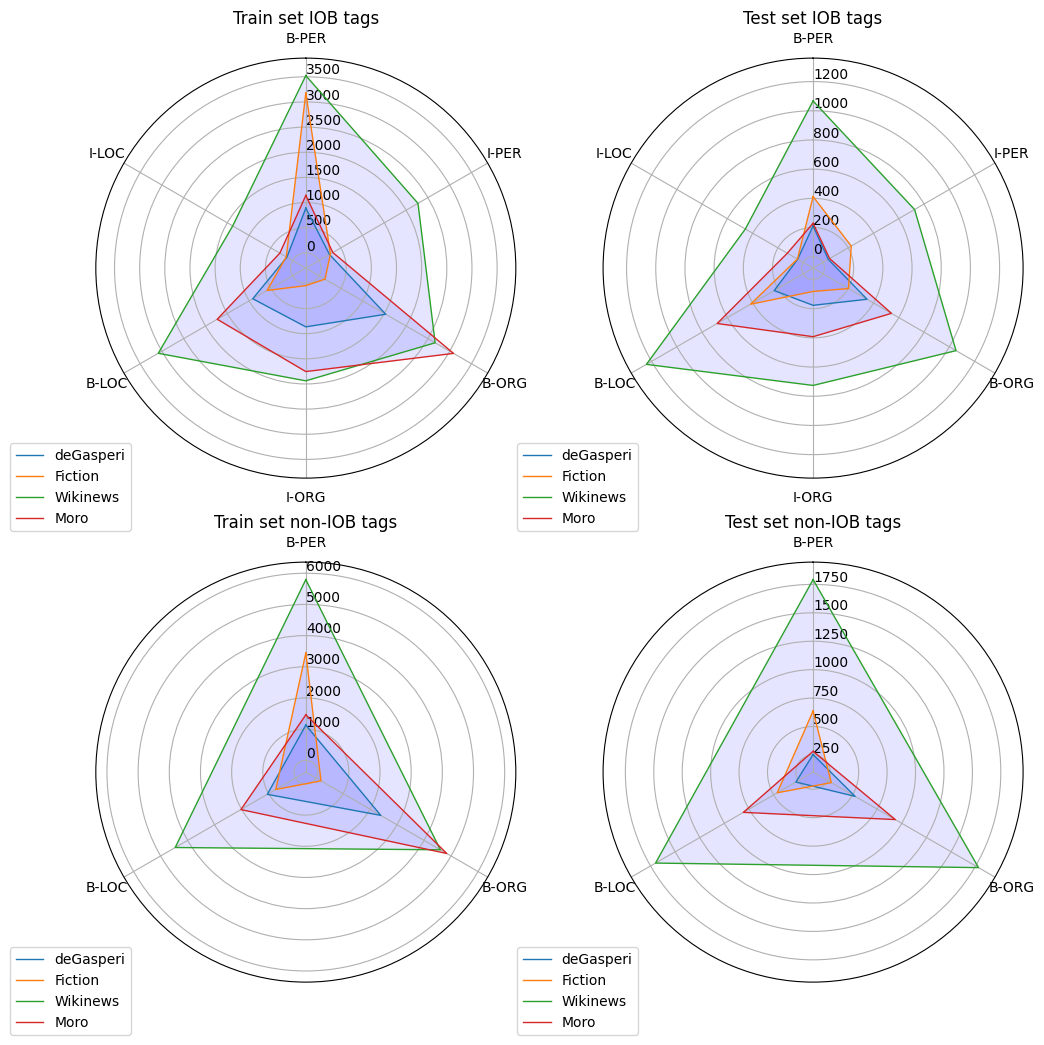

In [16]:
############ spider plots ############

spider_plot( pd.DataFrame({
    'B-PER': bper,
    'I-PER': iper,
    'B-ORG': borg,
    'I-ORG': iorg,
    'B-LOC': bloc,
    'I-LOC': iloc }),
    ['deGasperi', 'Fiction', 'Wikinews', 'Moro'],
    'Train set IOB tags',
    1)

spider_plot( pd.DataFrame({
    'B-PER': bper_test,
    'I-PER': iper_test,
    'B-ORG': borg_test,
    'I-ORG': iorg_test,
    'B-LOC': bloc_test,
    'I-LOC': iloc_test }),
    ['deGasperi', 'Fiction', 'Wikinews', 'Moro'],
    'Test set IOB tags',
    2)

spider_plot( pd.DataFrame({
    'PER': per,
    'ORG': org,
    'LOC': loc}),
    ['deGasperi', 'Fiction', 'Wikinews', 'Moro'],
    'Train set non-IOB tags',
    3)

spider_plot( pd.DataFrame({
    'PER': per_test,
    'ORG': org_test,
    'LOC': loc_test}),
    ['deGasperi', 'Fiction', 'Wikinews', 'Moro'],
    'Test set non-IOB tags',
    4)


plt.show()

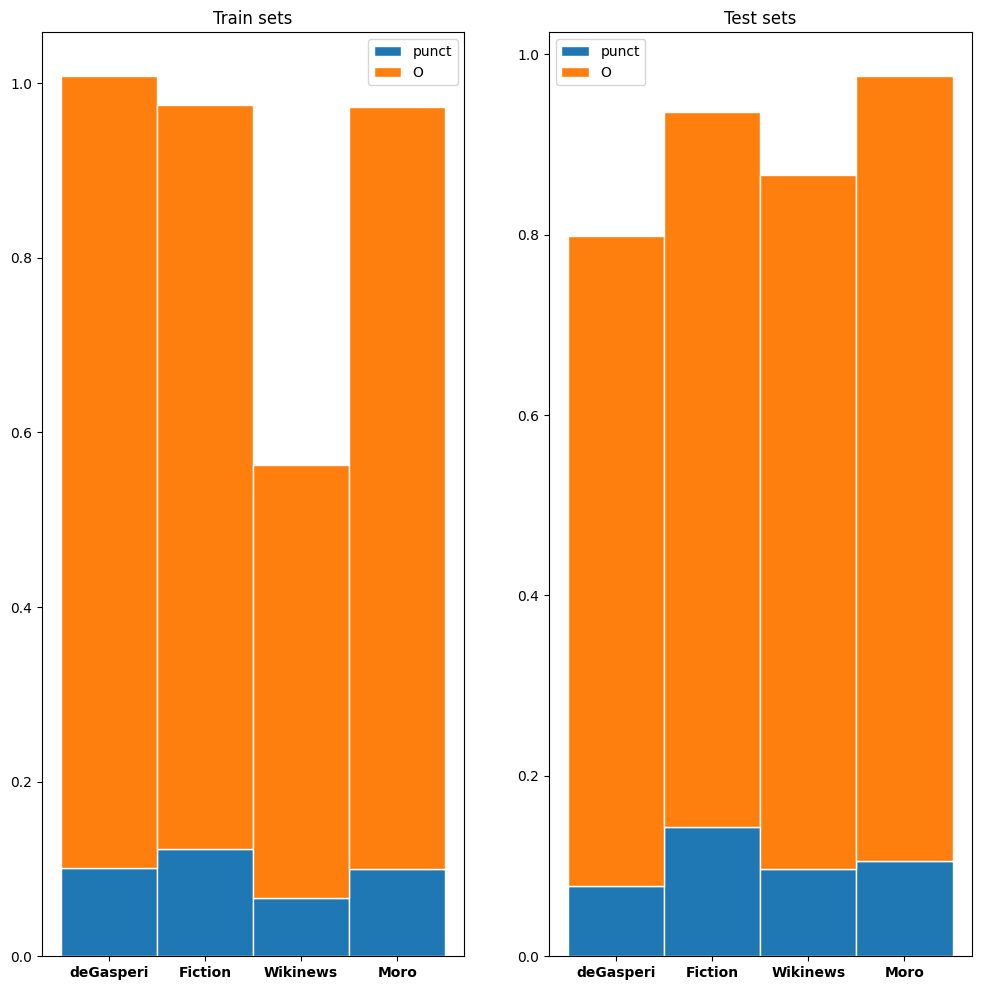

In [17]:
stacked_bar_plot(['deGasperi', 'Fiction', 'Wikinews', 'Moro'],
                 [[punct[i]/doc_len[i] for i in range(len(o))], [(o[i]-punct[i])/doc_len[i] for i in range(len(o))]],
                 ['punct', 'O'],
                 'Train sets',
                 1)

stacked_bar_plot(['deGasperi', 'Fiction', 'Wikinews', 'Moro'],
                 [[punct_test[i]/doc_len_test[i] for i in range(len(o))], [(o_test[i]-punct_test[i])/doc_len_test[i] for i in range(len(o_test))]],
                 ['punct', 'O'],
                 'Test sets',
                 2)

plt.show()

#### Observations
We can observe that all the datasets are heavily biased towards the 'O' class (as was easily predictable). The most balanced dataset in terms of entity classes is Wikinews, while the other three are strongly biased towards one class. The test sets provide a good representation of the train sets, with the exception of the 'moro' dataset, where the 'organization' class is poorly represented compared to the train set. However, overall, the test set is balanced across the classes.

## Word embeddings representation

A word embedding is the vectorial representation of a word that contains its sintactic and semantic information. It is used for achieving a numerical and dense representation of the words in an high dimensional space. Other types of representation of the words, such as the bag-of-words one, are sparse compared to word embeddings.
The word embeddings allow to achieve better results in many fields of natural language processing.

In this section, a Word2Vec is trained model in order to obtain the word embeddings of the words contained in the dataset and we also load a FastText italian model and find the representation of the dataset in terms of its vectors.

The basic version of the word embeddings model is a artificial neural network composed by two layers.

The inputs of the neural network are the words of the sentence to convert into the word embeddings representation.
The first layer of the neural network is a fully connected linear layer with a number of neurons equals to the dimension of the embeddings.
This layer is used to feed the last layer of the neural network that has the same number of outputs as inputs. On the output layer is applied a softmax function.

The neural network is then trained in order to make it predict, for each word in input, the next word in a sentence.
This is done, in the basic implementation, by setting the input corresponding to the considered word to 1 and the other inputs to 0 and expecting as result the probability 1 on the expected word (the output of the softmax layer can be interpreted as a probability).
The training can be performed using the cross entropy as loss function. At the end of the training the weights connecting each input to the first hidden layer are the values of the dimensions of the word embedding corresponding to the input word.

Two of the most used architecture of the Word2Vec embedding model are CBOW and Skip-Gram.

The Continuous Bag of Words (CBOW) method uses many words surrounding the considered word for predicting it. In the training step, the model sets to 1 the inputs corresponding to the words in the context of a word, the neural network has to predict the word inside the context. In this way the embedding is used to embed the context of a word for representing it.

The Skip-gram uses a word to predict the words in the surroundings. In the training step, the input of the considered word will be set to 1 and the outputs the neural network has to learn are the probabilities of the words in its context, so the probabilities of the words in the surroundings.

There are then optimizations of the training such as the negative sampling method or the computation of only some selected and meaningful outputs for each word in the train set.

The distribution of the embeddings in the various dimensions is based on the similarity of the words in terms of semantics and usage. With word embeddings we can embed the context of the word inside its representation.


### Word embeddings trained on all the data

The chosen pipeline for the creation of the embeddings starts from the dataframe containing the tokens of the datasets.

The pre-processing applied to the datasets in order to define the input of the Word2vec model is the following:
- tokenization of the dataset (previously done by the providers of the datasets);
- transformation of the input DataFrame into a list of lists of tokens. This is done merging the elements of the datasets into sentences. Since the datasets did not contain specific separator for the sentences, it is assumed that a sentence ends when in the DataFrame there is a dot. Therefore, the split in sentences of the tokens is done considering the single dots;
- possibly lowercasing all the tokens to reduce the vocabulary dimension.

We choose to try the definition of the word embeddings model on different portions of the dataset in order to compare the results. We expect that the more data are considered in the model definition, the better will be the model in terms of information catched inside it.

Firstly, the word embeddings are defined on the entire data, so using the train and test sets togethers.

In [18]:
# Merging the dictionaries of the trainsets and testsets
datasets_for_embeddings = datasets_train_dict_IO.copy()
datasets_for_embeddings.update(datasets_test_dict_IO)
# Merging the lists of the names of the trainsets and testsets
dataset_names_for_embeddings = dataset_names_train_IO + dataset_names_test_IO

# Getting the sentences, the labels and the origin dataset of the sentences in
# the correct format in order to create the embeddings representation of the words
sentences, labels, sentences_keys = get_all_sentences_from_datasets(datasets_for_embeddings)

# Printing 10 lists of token
print('\n\nHere some examples of the shape of the sentences:\n')
for i in range(10):
  print(str(sentences[i]))

degasperi_train.tsv
Converting the DataFrame of the datasetdegasperi_train.tsv


123504it [00:14, 8331.12it/s]


Removing short sentences from the dataset


100%|██████████| 3793/3793 [00:00<00:00, 738853.57it/s]


fiction_train.tsv
Converting the DataFrame of the datasetfiction_train.tsv


170942it [00:15, 11119.85it/s]


Removing short sentences from the dataset


100%|██████████| 7479/7479 [00:00<00:00, 953877.02it/s]


moro_train.tsv
Converting the DataFrame of the datasetmoro_train.tsv


309798it [00:41, 7412.09it/s]


Removing short sentences from the dataset


100%|██████████| 8747/8747 [00:00<00:00, 257203.99it/s]


wikinews_train.tsv
Converting the DataFrame of the datasetwikinews_train.tsv


249077it [00:29, 8540.89it/s] 


Removing short sentences from the dataset


100%|██████████| 7522/7522 [00:00<00:00, 1099402.54it/s]


degasperi_test.tsv
Converting the DataFrame of the datasetdegasperi_test.tsv


27128it [00:02, 9822.66it/s]


Removing short sentences from the dataset


100%|██████████| 837/837 [00:00<00:00, 952681.80it/s]


fiction_test.tsv
Converting the DataFrame of the datasetfiction_test.tsv


21506it [00:03, 6278.50it/s]


Removing short sentences from the dataset


100%|██████████| 807/807 [00:00<00:00, 921536.44it/s]


moro_test.tsv
Converting the DataFrame of the datasetmoro_test.tsv


82806it [00:11, 7438.15it/s]


Removing short sentences from the dataset


100%|██████████| 2203/2203 [00:00<00:00, 333648.14it/s]


wikinews_test.tsv
Converting the DataFrame of the datasetwikinews_test.tsv


59220it [00:03, 14808.90it/s]


Removing short sentences from the dataset


100%|██████████| 1804/1804 [00:00<00:00, 340542.98it/s]



Here some examples of the shape of the sentences:

['Il', 'ministro', 'degli', 'Esteri', 'al', 'commissario', 'capo', 'della', 'Commissione', 'alleata', 'Sono', 'informato', 'che', "l'", 'ordine', 'n.', '14', 'emesso', 'il', '10', 'settembre', 'dal', 'Governo', 'Militare', 'Alleato', 'di', 'Trieste', 'che', 'istituisce', 'speciali', '«', 'carte', "d'", 'identità', '»', 'per', 'le', 'persone', 'che', 'vivono', 'nella', '«', 'Zona', 'A', '»', 'è', 'giunto', 'nella', 'fase', "dell'", 'applicazione', 'pratica']
['Sono', 'in', 'possesso', 'del', 'testo', 'italiano', 'di', 'detto', 'ordine', 'soltanto', 'come', 'stampato', 'nei', 'quotidiani', 'di', 'Trieste', 'vedi', 'allegato']
['Mi', 'consenta', 'caro', 'Ammiraglio', 'Stone', 'di', 'esporle', 'brevemente', 'alcune', 'impressioni', 'e', 'alcune', 'preoccupazioni', 'relative', 'a', 'tale', 'ordine', 'che', 'mi', 'sono', 'giunte', 'da', 'varie', 'fonti', 'da', 'esso', 'toccate']
["L'", 'ordine', 'n.', '14', 'è', 'senza', 'dubbio', 'una', '

In [19]:
# To check that there are no tabs or new lines inside the tokens
# It was used because there were issues with the reading of the datasets
found = False
for name in dataset_names_for_embeddings:
  for i, el in datasets_for_embeddings[name].iterrows():
    if '\t' in el['Token'] or '\n' in el['Token']:
      found = True
      print(el['Token'])
if found:
  print('There is something wrong, there tab or new line characters, are check the import of the dataset :(')
else:
  print('No tab or new line characters found, Great job!')

No tab or new line characters found, Great job!


In [20]:
# Printing some information about the list of lists of token
print('The total number of sentences in the dataset is ' + str(len(sentences)))
length_list= []
for idx,i in enumerate(sentences):
  length_list.append(len(i))
print('The maximum lenght of a sentence is ' + str(max(length_list)))

The total number of sentences in the dataset is 32882
The maximum lenght of a sentence is 284


In [21]:
# Definition of the Word2Vec model
embeddings_model = Word2Vec(sentences, vector_size=50, min_count=5, window=10)
# Printing the length of the vocabulary
print('The length of the vocabulary is ' + str(len(embeddings_model.wv)) + ' words')

The length of the vocabulary is 14488 words


In [22]:
# Searching the most similar word to a specific word
term = 'governo'
embeddings_model.wv.most_similar(term.lower())

[('Governo', 0.9361634254455566),
 ('popolo', 0.9112427830696106),
 ('Partito', 0.8274871110916138),
 ('comunismo', 0.82584547996521),
 ('diritto', 0.8206125497817993),
 ('rapporto', 0.8151477575302124),
 ('potere', 0.8149696588516235),
 ('partito', 0.8005226254463196),
 ('impegno', 0.7992692589759827),
 ('quadro', 0.795203447341919)]

The code above finds the most similar words to the give ones.

Using different values it is understandable that the model is quite good and retrives words very related to the selected one.

In [50]:
# Definition of a function to get the word2vec vector representation of a word
def get_word2vec_vector(word, model):
  '''
  Returns the word2vec vector representation of a word.
  
  Parameters
  ----------
  word: str
    word to convert into its vectorial representation.
  model: Word2Vec
    word2Vec model from gensim library for creating the embedding.

  Returns
  -------
  word_vector: ndarray
    word2Vec vector representation of a word.

  '''
  
  word_vector = np.zeros(model.vector_size)
  try:
    word_vector = model.wv[word]
  except KeyError:
    try:
      word_vector = model.wv[model.wv.most_similar(word)[0][0]]
    except:
      return word_vector
    return word_vector
  return word_vector

In [24]:
# Choosing a subset of embedding vectors
word_samples = random.sample(list(embeddings_model.wv.key_to_index), 500)
word_vectors = embeddings_model.wv[word_samples]

# Computing the dimensionality reduction of the word embeddings space
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embeddings = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embeddings)

In [25]:
# Plotting the word embeddings of the model
fig = px.scatter_3d(x=x, y=y, z=z, text=word_samples)
fig.update_traces(marker=dict(size=3, line=dict(width=2)), textfont_size=6)
fig.show()

The second analysis is done on the word embeddings trained only on the training datasets that could be useful in the next part of the project since they can be used for performing named entity recognition. 

This is indeed a more realistic scenario, since train set and test set must be kept separate in order to have an unbiased assessment of the models when evaluating it on the test set.

In [51]:
# Getting the sentences, the labels and the origin dataset of the sentences in
# the correct format in order to create the embeddings representation of the words
sentences_train, labels_train, sentences_keys_train = get_all_sentences_from_datasets(datasets_train_dict_IO, lower=False)

# Definition of the Word2Vec model
embeddings_model_train = Word2Vec(sentences_train, vector_size=50, min_count=5, window=10)

degasperi_train.tsv
Converting the DataFrame of the datasetdegasperi_train.tsv


123504it [00:09, 13284.56it/s]


Removing short sentences from the dataset


100%|██████████| 3793/3793 [00:00<00:00, 1045200.39it/s]


fiction_train.tsv
Converting the DataFrame of the datasetfiction_train.tsv


170942it [00:09, 18627.52it/s]


Removing short sentences from the dataset


100%|██████████| 7479/7479 [00:00<00:00, 1230116.45it/s]


moro_train.tsv
Converting the DataFrame of the datasetmoro_train.tsv


309798it [00:23, 12933.98it/s]


Removing short sentences from the dataset


100%|██████████| 8747/8747 [00:00<00:00, 599597.58it/s]


wikinews_train.tsv
Converting the DataFrame of the datasetwikinews_train.tsv


249077it [00:24, 10201.83it/s]


Removing short sentences from the dataset


100%|██████████| 7522/7522 [00:00<00:00, 1329297.83it/s]


In [27]:
# Printing the length of the vocabulary
print('The length of the vocabulary is ' + str(len(embeddings_model_train.wv)) + ' words')

The length of the vocabulary is 12611 words


In [28]:
# Searching the most similar word to a specific word
term = 'governo'
embeddings_model_train.wv.most_similar(term.lower())

[('Governo', 0.9338332414627075),
 ('popolo', 0.928443193435669),
 ('potere', 0.8812846541404724),
 ('partito', 0.8691940307617188),
 ('Partito', 0.8676647543907166),
 ('paese', 0.8650661110877991),
 ('comunista', 0.8509954810142517),
 ('sistema', 0.8451961874961853),
 ('Paese', 0.8447995781898499),
 ('comunismo', 0.8382607698440552)]

In [29]:
# Choosing a subset of embedding vectors
word_samples_train = random.sample(list(embeddings_model_train.wv.key_to_index), 500)
word_vectors_train = embeddings_model_train.wv[word_samples_train]

# Computing the dimensionality reduction of the word embeddings space
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embeddings = tsne.fit_transform(word_vectors_train)
x_train, y_train, z_train = np.transpose(tsne_embeddings)

In [30]:
# Plotting the word embeddings of the model
fig = px.scatter_3d(x=x_train, y=y_train, z=z_train, text=word_samples_train)
fig.update_traces(marker=dict(size=3, line=dict(width=2)), textfont_size=6)
fig.show()

The dictionary is a bit smaller but still big and the results are quite similar to the previous ones, in terms of understanding and search of the similar words and also the embedding space has a similar shape. 

However it has to be noticed that the vocabulary is a bit smaller with respect to the one of the model trained over all the data. This is believable since the test set can have tokens that the train set doesn't have. 
This is a problem when the model has to create the embeddings of words that doesn't know.


The last trained embedding models are the ones computed on the train datasets separately.

In [13]:
# Separating the train sets and collecting their sentences, labels and origin
# dataset into a dictionary
sentences_train_separate = {}
labels_train_separate = {}
embeddings_model_train_separate = {}
keys_train_separate = {}
for name in dataset_names_train_IO:
  # Getting the sentences, the labels and the origin dataset of the sentences in
  # the correct format in order to create the embeddings representation of the words
  sentences_train_sep, labels_train_sep, keys_train_sep = get_all_sentences_from_datasets({name:datasets_train_dict_IO[name]})
  sentences_train_separate[name] = sentences_train_sep
  labels_train_separate[name] = labels_train_sep
  keys_train_separate[name]  = keys_train_sep 

  # Definition of the Word2Vec models
  embeddings_model_train_separate[name] = Word2Vec(sentences_train_sep, vector_size=50, min_count=3, window=10)

degasperi_train.tsv
Converting the DataFrame of the datasetdegasperi_train.tsv


123504it [00:18, 6698.59it/s] 


Removing short sentences from the dataset


100%|██████████| 3793/3793 [00:00<00:00, 798003.36it/s]


fiction_train.tsv
Converting the DataFrame of the datasetfiction_train.tsv


170942it [00:28, 5969.33it/s]


Removing short sentences from the dataset


100%|██████████| 7479/7479 [00:00<00:00, 462938.85it/s]


moro_train.tsv
Converting the DataFrame of the datasetmoro_train.tsv


309798it [00:25, 11969.84it/s]


Removing short sentences from the dataset


100%|██████████| 8747/8747 [00:00<00:00, 734824.39it/s]


wikinews_train.tsv
Converting the DataFrame of the datasetwikinews_train.tsv


249077it [00:34, 7179.52it/s] 


Removing short sentences from the dataset


100%|██████████| 7522/7522 [00:00<00:00, 755967.67it/s]


In [14]:
# Printing the length of the vocabularies of the various datasets
for name in dataset_names_train_IO:
    print('The dictionary of the dataset ' + name + ' is long ' + str(len(embeddings_model_train_separate[name].wv)) + ' words')

The dictionary of the dataset degasperi_train.tsv is long 4579 words
The dictionary of the dataset fiction_train.tsv is long 5669 words
The dictionary of the dataset moro_train.tsv is long 7321 words
The dictionary of the dataset wikinews_train.tsv is long 9184 words


In [15]:
# Searching the most similar word to a specific word
for name in dataset_names_train_IO:
    term = 'governo'
    print(name + ':' + str(embeddings_model_train_separate[name].wv.most_similar(term.lower())))

degasperi_train.tsv:[('ad', 0.9995263814926147), ('invece', 0.9995022416114807), ('quale', 0.9994946122169495), ('nostro', 0.9994931221008301), ('come', 0.9994851350784302), ('suo', 0.9994646310806274), ('ogni', 0.9994558691978455), ('il', 0.9994412064552307), ('È', 0.9994308352470398), ('o', 0.9994275569915771)]
fiction_train.tsv:[('tutto', 0.9986589550971985), ('ad', 0.9986431002616882), ('dei', 0.998591423034668), ("d'", 0.998579204082489), ('a', 0.9985185861587524), ('ogni', 0.9985163807868958), ('nel', 0.9985067248344421), ('due', 0.9985060691833496), ('dal', 0.9984578490257263), ('giorno', 0.9984146356582642)]
moro_train.tsv:[('popolo', 0.9911399483680725), ('Movimento', 0.9826390147209167), ('Segretario', 0.9781293272972107), ('assicurato', 0.9774661660194397), ('riconfermato', 0.9771328568458557), ('gruppo', 0.9733055233955383), ('Mediterraneo', 0.9732494354248047), ('rappresentante', 0.9728216528892517), ('nome', 0.9712291955947876), ('Tesoro', 0.9710830450057983)]
wikinews_tr

It is easy to understand that the dictionaries in this case are smaller since the overall words are splitted and analysed in different models.

Trying to search the most similar embeddings to a given word of many different topics and for the different datasets, it can be seen that better performace are achieved by the datasets that are specialized in that specific field, e.g. fiction_train finds worst results (less related word embeddings) for the word 'governo' than the other datasets, which deal with news and politics.

In [16]:
points_train_separate = {}
word_samples_train_separate = {}
for key in embeddings_model_train_separate:
  # Choosing a subset of embedding vectors
  word_samples_train_separate[key] = random.sample(list(embeddings_model_train_separate[key].wv.key_to_index), 500)
  model_separate = embeddings_model_train_separate[key]
  word_vector_train_separate = model_separate.wv[word_samples_train_separate[key]]

  # Computing the dimensionality reduction of the word embeddings space
  tsne = TSNE(n_components=3, n_iter=1000)
  tsne_embeddings = tsne.fit_transform(word_vector_train_separate)
  points_train_separate[key] = np.transpose(tsne_embeddings)

In [17]:
# Plotting the word embeddings of the model
for key in points_train_separate:
  fig = px.scatter_3d(x=points_train_separate[key][0], y=points_train_separate[key][1],
                      z=points_train_separate[key][2], text=word_samples_train_separate[key], title='Dataset ' + key)
  fig.update_traces(marker=dict(size=3, line=dict(width=2)), textfont_size=6)
  fig.show()

The shapes of the embedding spaces are complex and not globular, the differs a lot from the ones computed on the data compesed by the merged datasets.

### Computing the embeddings using a pretrained FastText model

In [ ]:
# Downloading the pretrained model from the fasttext library
!wget http://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.bin.gz
!gzip -d cc.it.300.bin.gz

In [ ]:
# Instantiating the model
ft_embedding_model = fasttext.load_model('cc.it.300.bin')

In [ ]:
# Printing some statistics about the model
print('The size of the vocabulary is ' + str(len(ft_embedding_model.get_words())))
print('The length of the embeddings is '+ str(ft_embedding_model.get_dimension()))

In [ ]:
# Searching the most similar word to a specific word
term = 'legge'
ft_embedding_model.get_nearest_neighbors(term.lower())

In [ ]:
def get_fasttext_vector(word, model=None):
  '''
  Returns the fastText vector representation of a word.
  
  Parameters
  ----------
  word: str
    word to convert into its vectorial representation.
  model: fasttext.FastText._FastText
    fastText model for creating the embedding. Providing it the computation of 
    the embedding is faster.

  Returns
  -------
  word_vector: ndarray
    fastText vector representation of a word.

  '''
  
  if model == None:
    print('ciao')
    model = fasttext.load_model('cc.it.300.bin')
  word_vector = model.get_word_vector(model.get_nearest_neighbors(word.lower())[0][1])
  return word_vector

In [ ]:
# Finding the embedding representation of a word, assuming to represent a word
# with its similar word in the model
term = 'legge'
get_fasttext_vector(term, ft_embedding_model)

The following snippet of code tries to transform the whole dataset in its FastText embedding representation. The time required to run this code is very long and so this part has been commented.

The idea was to use these vectors instead of the Word2Vec ones in the NER performed by means of CRF since the FastText model is trained on more data than the one trained on the KIND dataset.

In [ ]:
# Creating the embedding representation of the dataset
#ft_embedding_train = []
#for sentence in sentences_train:
#  sentence_embeddings = []
#  for word in sentence:
#    sentence_embeddings.append(get_fasttext_vector(word, ft_embedding_model))
#    print(word)
#  ft_embedding_train.append(sentence_embeddings)
# This operation takes a very long time to be computed but when it is done the 
# embeddings can be saved and loaded whenever they are needed

## Clustering

The clustering is an unsupervised machine learning technique used to inspect non-labeled data in order to find inside them hidden patterns or other information.
In our case clustering is not needed for performing the named entity recognition on the data but it could useful for gain some additional knowledge about the dataset before proceeding in the sequence labeling task.

Given the KIND dataset it is not possible to identify the different documents because there are no document separators in the data. Since it is not possible to identify the various documents, we decide to apply the clustering techniqes on the sentences. As done in the embeddings section, it is assumed that the sentences are separated by the dot.

In this section it is investigated whether the four datasets are distinguishable basing on the representation of their sentences and so, in some way, they have different characteristics.


### Importing the italian stopwords

In [18]:
# Importing the italian stopwords (taken from https://github.com/stopwords-iso/stopwords-it.git)
with open('/content/KIND_project/notebook/stopwords-it.txt', 'r', encoding='utf-8') as f:
    italian_stopwords = f.read()
italian_stopwords_github = italian_stopwords.split('\n')
print('Number of stopwords in the repository https://github.com/stopwords-iso/stopwords-it.git: ' + str(len(italian_stopwords_github)))

Number of stopwords in the repository https://github.com/stopwords-iso/stopwords-it.git: 632


In [19]:
# Downloading and importing the italian stopwords in the package nltk
nltk.download('stopwords')
italian_stopwords_nltk = nltk.corpus.stopwords.words('italian')
print('Number of stopwords in the nltk library: ' + str(len(italian_stopwords_nltk)))

[nltk_data] Downloading package stopwords to /root/nltk_data...


Number of stopwords in the nltk library: 279


[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
# Checking that all the stopwords of nltk are in the other dataset, better result with more stopwords
count = 0
for i in italian_stopwords_nltk:
    if i in italian_stopwords_github:
        count += 1
print(str(count) + ' stopwords of the nltk library are in the Github repository')
italian_stopwords = italian_stopwords_github

279 stopwords of the nltk library are in the Github repository


In [21]:
# Getting the sentences, the labels and the origin dataset of the sentences in
# the correct format in order to create the embeddings representation of the words
sentences, labels, sentences_keys = get_all_sentences_from_datasets(datasets_train_dict_BIO, lower=False)

# Defining the labels of the clustering
for i, key in enumerate(sentences_keys):
  sentences_keys[i] = key.replace('_train_BIO.tsv','').replace('_test_BIO.tsv', '')

degasperi_train_BIO.tsv
Converting the DataFrame of the datasetdegasperi_train_BIO.tsv


123504it [00:07, 16711.61it/s]


Removing short sentences from the dataset


100%|██████████| 3793/3793 [00:00<00:00, 585233.78it/s]


fiction_train_BIO.tsv
Converting the DataFrame of the datasetfiction_train_BIO.tsv


170942it [00:13, 12855.46it/s]


Removing short sentences from the dataset


100%|██████████| 7479/7479 [00:00<00:00, 1106068.18it/s]


moro_train_BIO.tsv
Converting the DataFrame of the datasetmoro_train_BIO.tsv


309798it [00:26, 11480.33it/s]


Removing short sentences from the dataset


100%|██████████| 8747/8747 [00:00<00:00, 671810.60it/s]


wikinews_train_BIO.tsv
Converting the DataFrame of the datasetwikinews_train_BIO.tsv


249077it [00:15, 15673.74it/s]


Removing short sentences from the dataset


100%|██████████| 7522/7522 [00:00<00:00, 689140.79it/s]


### Clustering TF-IDF vectors

The Term Frequency-Inverse Document Frequency is a numerical statistic used to evaluate the importance of a term within a document or a corpus. In this case, it is evaluated the importance of the words in the sentences.

The first step is done to obtain a TF-IDF representation of the datasets. From the collection of text it is obtained a matrix representation containing the TF-IDF values of each word in each sentence.

In [22]:
# Defining the vectorizer model
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words=italian_stopwords_github, use_idf=True)
# Fitting the vectorizer model
vectorizer.fit(concatenate_sentences_tokens(sentences))

TfidfVectorizer(max_df=0.8, min_df=5,
                stop_words=['a', 'abbastanza', 'abbia', 'abbiamo', 'abbiano',
                            'abbiate', 'accidenti', 'ad', 'adesso', 'affinché',
                            'agl', 'agli', 'ahime', 'ahimè', 'ai', 'al',
                            'alcuna', 'alcuni', 'alcuno', 'all', 'alla', 'alle',
                            'allo', 'allora', 'altre', 'altri', 'altrimenti',
                            'altro', 'altrove', 'altrui', ...])

In [23]:
# Extracting the vocabulary
vocabulary = vectorizer.get_feature_names_out()

print('The vocabulary is long ' + str(len(vocabulary)) + ' words')

The vocabulary is long 11146 words


In [24]:
# The words look reasonable and the vocabulary seems to not have many stopwords inside
sorted(random.sample(vocabulary.tolist(), 100))

['abile',
 'aggiungere',
 'agricolo',
 'alza',
 'amavo',
 'ambizione',
 'andati',
 'annuale',
 'anticipate',
 'assetto',
 'attendiamo',
 'attualità',
 'auspicata',
 'batteva',
 'borse',
 'calciatore',
 'cammino',
 'carattere',
 'carlo',
 'colasanti',
 'com',
 'compiti',
 'concorsi',
 'condotti',
 'contraddittoria',
 'contrariamente',
 'coraggioso',
 'costituisca',
 'cresce',
 'cronache',
 'dimenticata',
 'diritti',
 'disinvolto',
 'dovuti',
 'duplice',
 'energetica',
 'equa',
 'esaurita',
 'fisiche',
 'francisco',
 'fumai',
 'giancarlo',
 'giro',
 'gradevole',
 'gradita',
 'gratuito',
 'imbecille',
 'immediata',
 'impegna',
 'imporre',
 'imporsi',
 'improvvisa',
 'indipendenti',
 'innegabile',
 'lesioni',
 'localizzato',
 'marcello',
 'medicina',
 'meeting',
 'mica',
 'minimo',
 'moralità',
 'muraglia',
 'naso',
 'onu',
 'pessimo',
 'poesia',
 'premere',
 'presentare',
 'provvisoria',
 'rassicurato',
 'realismo',
 'reggio',
 'regolarmente',
 'relativi',
 'renderla',
 'restar',
 'ricord

In [25]:
# Converting the strings into vectors
sentences_vector = vectorizer.transform(concatenate_sentences_tokens(sentences))

In [26]:
sentences_vector[0].multiply(sentences_vector[0]).sum()

1.0000000000000004

In [27]:
max_score = 0
sentence_idx = 20
for i in range(sentences_vector.shape[0]):
    if i != sentence_idx:
        score = sentences_vector[sentence_idx].multiply(sentences_vector[i]).sum()
        if score > max_score:
            max_score = score
            max_score_idx = i
print('Sentence index ' + str(sentence_idx) + ': ' + str(sentences[sentence_idx]))
print('Most similar sentence is the one with index ' + str(max_score_idx) + ': ' + str(sentences[max_score_idx]))
print('The score is ' + str(max_score))

Sentence index 20: ['In', 'fatti', 'il', 'comma', 'a', 'tratta', 'della', 'residenza', 'per', 'la', 'legge', 'italiana', 'questo', 'termine', 'definisce', 'la', 'dimora', 'abituale', 'di', 'una', 'persona', 'mentre', 'il', 'comma', 'b', 'tratta', 'del', 'domicilio', 'sempre', 'per', 'la', 'legge', 'italiana', 'questo', 'termine', 'significa', 'il', 'centro', 'principale', 'degli', 'interessi', 'e', 'delle', 'attività', 'del', 'soggetto']
Most similar sentence is the one with index 11455: ['Non', 'di', 'questo', 'si', 'tratta']
The score is 0.3376689613586904


Trying to find the most similar sentences to a given sentence, it is possible to see that the metrics of similarity are not very high.

Even if some retrieved sentences have some sort of similarities, usually they are not very related in terms of semantics or and field of application.



The second step is to actual cluster the TF-IDF representation of the sentences.
In general it is not known the number of clusters that are present. It is possible to approximately define a range or deduce the number from the problem.
In the considered case, the clustering is applied to check whether the 4 inputs datasets are distinguishable in some way, so initially 4 cluster are considered.

The K-means clustering method is the one used in the following part.

In [28]:
num_clusters= len(set(sentences_keys))
# Defining the K-means model
kmeans_model = KMeans(n_clusters=num_clusters, max_iter=1000, n_init=3, verbose=True,
                      random_state=2307)
# Applying K-means clustering to the tf-idf representation of the sentences
kmeans_model.fit(sentences_vector)

Initialization complete
Iteration 0, inertia 53620.786094430325.
Iteration 1, inertia 26962.024298033022.
Iteration 2, inertia 26955.271703932573.
Iteration 3, inertia 26952.463416455885.
Iteration 4, inertia 26950.073677198852.
Iteration 5, inertia 26949.6145518639.
Iteration 6, inertia 26949.29039919666.
Iteration 7, inertia 26948.96120126525.
Iteration 8, inertia 26948.68999701029.
Iteration 9, inertia 26948.508560109538.
Iteration 10, inertia 26948.346335716524.
Iteration 11, inertia 26947.93962829783.
Iteration 12, inertia 26947.502097432756.
Iteration 13, inertia 26947.284127919644.
Iteration 14, inertia 26946.979625943983.
Iteration 15, inertia 26945.751957500164.
Iteration 16, inertia 26943.738710816284.
Iteration 17, inertia 26942.85179316864.
Iteration 18, inertia 26942.81241841963.
Iteration 19, inertia 26942.805470006333.
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 53687.938111568874.
Iteration 1, inertia 26947.057278756503.
I

KMeans(max_iter=1000, n_clusters=4, n_init=3, random_state=2307, verbose=True)

In [29]:
# Displaying the centroids in terms of their words with highest score
for i in range(num_clusters):
  # Getting the centroid for the cluster of index i
  centroid = kmeans_model.cluster_centers_[i]
  sorted_terms = centroid.argsort()[::-1]
  
  print('Centroid of cluster ' + str(i)+':')
  print([vocabulary[j] for j in sorted_terms[:20]])

Centroid of cluster 0:
['severa', 'rispose', 'esclamò', 'guardò', 'miriam', 'madre', 'occhi', 'nacque', 'voce', 'stanza', 'replicò', 'continuò', 'barra', 'entrava', 'inutile', 'sorella', 'ripeté', 'aiuto', 'voleva', 'stupita']
Centroid of cluster 1:
['partito', 'democrazia', 'cristiana', 'comunista', 'socialista', 'politica', 'popolare', 'sinistra', 'democratico', 'partiti', 'italiana', 'democratica', 'sociale', 'politico', 'funzione', 'responsabilità', 'realtà', 'nazionale', 'libertà', 'posizione']
Centroid of cluster 2:
['politica', 'italia', 'presidente', 'essa', 'casa', 'ch', 'situazione', 'paesi', 'cose', 'libertà', 'via', 'politico', 'altra', 'né', 'lavoro', 'forze', 'europa', 'crisi', 'punto', 'sociale']
Centroid of cluster 3:
['governo', 'politica', 'parlamento', 'italiano', 'responsabilità', 'partiti', 'presidente', 'legge', 'programma', 'partito', 'forze', 'situazione', 'crisi', 'politiche', 'azione', 'maggioranza', 'esso', 'fronte', 'sinistra', 'opposizione']


Even if some differences in the words of the centroids of the clusters can be seen, it is evident that the centroids are not very different one from the others meaning that the clustering of the sentences in 4 clusters does not obtain very good results.




In [30]:
# Printing the number of sentences contained in the various datasets
print('Number of sentences in the various datasets: ')
counter = Counter(sentences_keys)
for dataset_name, count in counter.items():
  print('Dataset ' + dataset_name + ': ' + str(count))

Number of sentences in the various datasets: 
Dataset degasperi: 3715
Dataset fiction: 7360
Dataset moro: 8702
Dataset wikinews: 7489


In [31]:
# Printing the number of sentences contained in the various clusters
print('Number of sentences in: ')
for i in range(kmeans_model.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans_model.labels_ == i)}")

Number of sentences in: 
Cluster 0: 126
Cluster 1: 1336
Cluster 2: 24389
Cluster 3: 1415


In [32]:
# Evaluating the clustering performance using intrinsic evaluation measures.
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans_model.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(sentences_vector, kmeans_model.labels_)))
# These metrics assess how much the clusters are internally coherent and how much 
# they are different one with respect to the others

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 26907.125580810454
Silhouette coefficient: 0.0029815048287141874


In [33]:
# Evaluating the clustering performance using extrinsic evaluation measures
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(sentences_keys, kmeans_model.labels_)))
print("Completeness:", str(metrics.completeness_score(sentences_keys, kmeans_model.labels_)))
print("V-measure:", str(metrics.v_measure_score(sentences_keys, kmeans_model.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(sentences_keys, kmeans_model.labels_)))
# These metrics assess how good the clusters have classified the elements of the
# dataset with respect to the known labels

Extrinsic evaluation measures:
Homogeneity: 0.042096444392116836
Completeness: 0.13289097857674909
V-measure: 0.06393874022438108
Adjusted Rand-Index: 0.004123872938371001


In [34]:
# Applying a SVD dimensionality reduction to the embedding representation of the
# sentences, here it is a linear dimensionality reduction operator for computational
# performance reason
svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(sentences_vector)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

[array([0.07515567, 0.04199233, 0.03873308, ..., 0.07595717, 0.07788867,
        0.03176651]),
 array([-0.07221089, -0.02500448, -0.02033574, ..., -0.06945322,
        -0.06989387, -0.02456356]),
 array([ 0.0511207 ,  0.02257818,  0.00821858, ..., -0.05379196,
        -0.07380119,  0.00192668])]

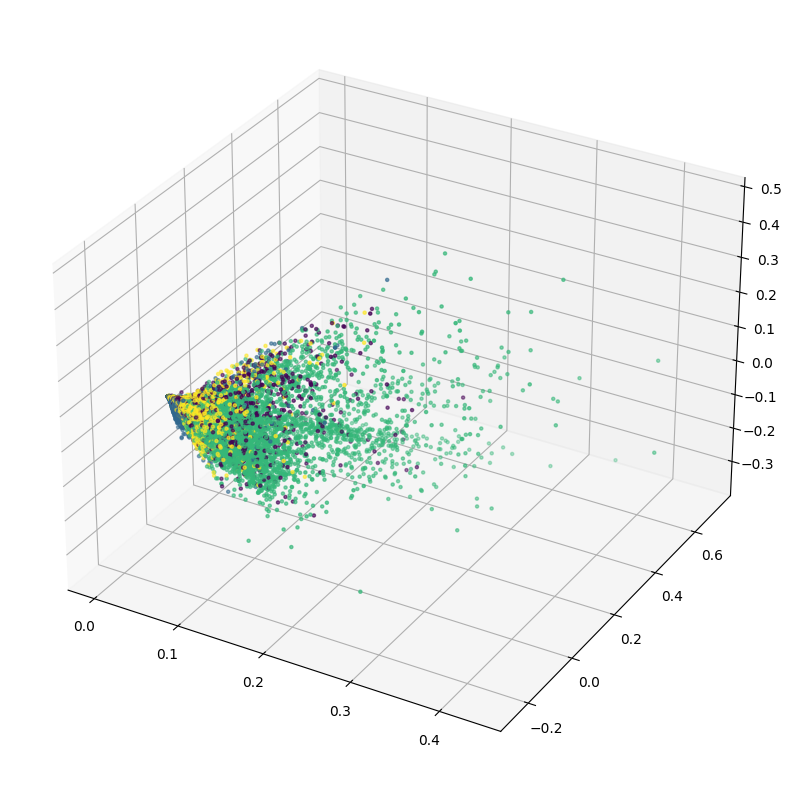

In [35]:
# Plotting the 3D-dimensionality reduction of the the embeddings coloring in 
# different ways data coming from different datasets
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(sentences_keys), marker='.')

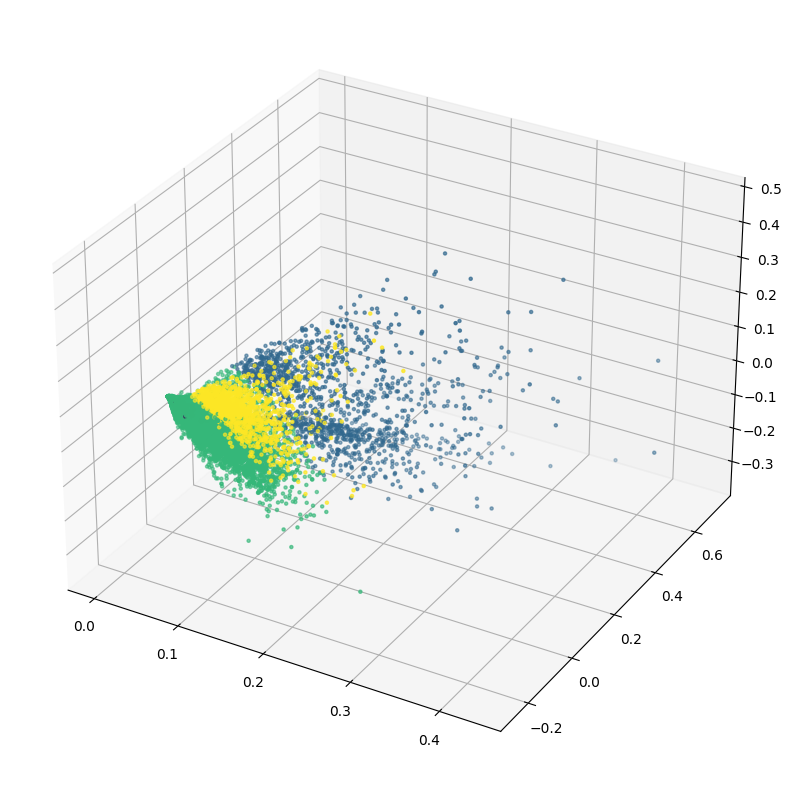

In [36]:
# Plotting the 3D-dimensionality reduction of the the embeddings coloring in 
# different ways the elements of the different clusters
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=kmeans_model.labels_, marker='.')

In [37]:
# Plotting, in interactive mode, the 3D-dimensionality reduction of the the 
# embeddings coloring in different ways data coming from different datasets
plot_3D(x, y, z, sentences_keys, mapping=get_numerical_mapping(), title='3D-dimensionality reduction of the dataset plotted by dataset')

In [38]:
# Plotting, in interactive mode, the 3D-dimensionality reduction of the the 
# embeddings coloring in different ways the elements of the different clusters
plot_3D(x, y, z, kmeans_model.labels_, title='3D-dimensionality reduction of the dataset plotted considering the clusters')

Using TF-IDF vectors it is not possible to distinguish the datasets and this is visible in the plot of the sentences divided by dataset.

Obviously, the clustering won't find 4 clusters that overlap with the previous plot.



### Clustering embedding vectors

In the following section it is provided the application of the clustering to the embeddings representation of the dataset in order to see whether the results are better.

In [17]:
# Removing the italian stopwords from the dataset
#sentences, labels = remove_stopwords(sentences, labels, italian_stopwords)
# Not needed, the embeddings wants the context, transformers works well with them

In [18]:
# Defining the pretrained BERT model used to create the embeddings starting from
# the sentences
sbert_model = SentenceTransformer('dbmdz/bert-base-italian-xxl-cased')
# Joining the tokens of the sentences in order to obtain a list of sentences
sentences_list = [' '.join(sentence) for sentence in sentences]
# Create the embeddings starting from the sentences
sentence_embeddings_bert = sbert_model.encode(sentences_list)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/dbmdz_bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
# Defining the K-means model
kmeans_model_embeddings = KMeans(n_clusters=4, max_iter=2000, n_init=10, verbose=True, random_state=2307)
# Applying K-means clustering to the tf-idf representation of the sentences
kmeans_model_embeddings.fit(sentence_embeddings_bert)

Initialization complete
Iteration 0, inertia 1969994.875.
Iteration 1, inertia 1274794.25.
Iteration 2, inertia 1257828.5.
Iteration 3, inertia 1252773.5.
Iteration 4, inertia 1250111.0.
Iteration 5, inertia 1248391.75.
Iteration 6, inertia 1247224.5.
Iteration 7, inertia 1246327.0.
Iteration 8, inertia 1245181.875.
Iteration 9, inertia 1243077.0.
Iteration 10, inertia 1239933.25.
Iteration 11, inertia 1237474.125.
Iteration 12, inertia 1236226.5.
Iteration 13, inertia 1235868.0.
Iteration 14, inertia 1235813.5.
Iteration 15, inertia 1235803.0.
Iteration 16, inertia 1235803.125.
Iteration 17, inertia 1235799.5.
Iteration 18, inertia 1235797.125.
Iteration 19, inertia 1235797.25.
Iteration 20, inertia 1235797.75.
Iteration 21, inertia 1235798.75.
Converged at iteration 21: center shift 2.9258153517730534e-06 within tolerance 6.539811939001084e-06.
Initialization complete
Iteration 0, inertia 1906934.75.
Iteration 1, inertia 1264664.0.
Iteration 2, inertia 1255730.5.
Iteration 3, inertia

KMeans(max_iter=2000, n_clusters=4, n_init=10, random_state=2307, verbose=True)

In [20]:
# Printing the number of sentences contained in the various datasets
print('Number of sentences in the various datasets: ')
counter = Counter(sentences_keys)
for dataset_name, count in counter.items():
  print('Dataset ' + dataset_name + ': ' + str(count))

Number of sentences in the various datasets: 
Dataset degasperi: 3715
Dataset fiction: 7360
Dataset moro: 8702
Dataset wikinews: 7489


In [21]:
# Printing the number of sentences contained in the various clusters
print('Number of sentences in: ')
for i in range(kmeans_model_embeddings.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans_model_embeddings.labels_ == i)}")

Number of sentences in: 
Cluster 0: 5091
Cluster 1: 7665
Cluster 2: 3245
Cluster 3: 11265


In [22]:
# Evaluating the clustering performance using intrinsic evaluation measures
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans_model_embeddings.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(sentence_embeddings_bert, kmeans_model_embeddings.labels_)))
# These metrics assess how much the clusters are internally coherent and how much 
# they are different one with respect to the others

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 1235794.125
Silhouette coefficient: 0.025573654


In [23]:
# Evaluating the clustering performance using extrinsic evaluation measures
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(sentences_keys, kmeans_model_embeddings.labels_)))
print("Completeness:", str(metrics.completeness_score(sentences_keys, kmeans_model_embeddings.labels_)))
print("V-measure:", str(metrics.v_measure_score(sentences_keys, kmeans_model_embeddings.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(sentences_keys, kmeans_model_embeddings.labels_)))
# These metrics assess how good the clusters have classified the elements of the
# dataset with respect to the known labels

Extrinsic evaluation measures:
Homogeneity: 0.4288986278990264
Completeness: 0.4475067866188438
V-measure: 0.4380051596598411
Adjusted Rand-Index: 0.46059361830143924


In [ ]:
# Applying a SVD dimensionality reduction to the embedding representation of the
# sentences, here it is a linear dimensionality reduction operator for computational
# performance reason
svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(sentence_embeddings_bert)

[x, y, z] = np.transpose(reduced_data)
[x, y, z]

In [ ]:
# Plotting the 3D-dimensionality reduction of the the embeddings coloring in 
# different ways data coming from different datasets
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, c=LabelEncoder().fit_transform(sentences_keys), marker='.')

In [ ]:
# Plotting the 3D-dimensionality reduction of the the embeddings coloring in 
# different ways the elements of the different clusters
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, c=kmeans_model_embeddings.labels_, marker='.')

In [ ]:
# Plotting, in interactive mode, the 3D-dimensionality reduction of the the 
# embeddings coloring in different ways data coming from different datasets
plot_3D(x, y, z, sentences_keys, mapping=get_numerical_mapping(), title='3D-dimensionality reduction of the dataset plotted by dataset')

In [ ]:
# Plotting, in interactive mode, the 3D-dimensionality reduction of the the 
# embeddings coloring in different ways the elements of the different clusters
plot_3D(x, y, z, kmeans_model_embeddings.labels_, title='3D-dimensionality reduction of the dataset plotted considering the clusters')

The results of the clustering applied to BERT embeddings representation are better w.r.t. the ones of TF-IDF representation. They are better in terms of both extrinsic and intrinsic metrics.

In spite of this the results are very poor.

To summarize, it is possible to see that the dataset is not meant to apply on it clustering and we cannot state that the sentences in the various datasets are distinguishable.

Here it is done a brief analysis about the number of clusters that could be find in the problem.

In [ ]:
# Applying multiple times the K-means with mini-batch using a different number
# of clusters in different iterations
performance = [MiniBatchKMeans(n_clusters=k, batch_size=500, n_init=2, random_state=2307).fit(sentence_embeddings_bert).inertia_ for k in range(1,50)]

In [ ]:
# Plotting the performances for various values of the number of clusters
plt.figure()
plt.plot(performance[:15])
plt.ylabel('Within-cluster sum-of-squares')
plt.xlabel('k')
plt.grid()
plt.show()

It can be seen that the elbow is approximatively in the interval [4,7].

## POS tagging

**Part-of-speech** tagging is the process of marking up a word in a text with the corresponding part of speech tag, e.g. noumn, verb, based on both its definition and its context.
The POS Tagging here plays a crucial role to understand in what context the word is used in the sentence.

We will perform POS tagging using the **spaCy** libary.
After the tokenization, spaCy can parse and tag a given Doc. This is made thanks to a trained pipeline and its statistical models, which enable spaCy to make predictions of which tag o label most likely applies in this context.


### Creation of the POS tags files

In the following part of code we created some files containing the POS tags for each dataset and also che combination of them. This to improve the performances for the next steps and to avoid every time to do everything from the start.

In [ ]:
def write_pos_tags_on_file(filename, dataset):

  '''
  Takes as input a dataset and writes into a file the pos tags for each sentence

  Parameters
  ----------
  filename: Str
    File name that has to be used to save the pos tags

  dataset: DataFrame
    Dataset that contains the tokens of the text.

  '''

  sentences, labels, _ = get_sentences_list_from_df(dataset, lower=False)
  pos_tags = get_pos_tags(sentences)
  with open(f'{filename}.txt', 'w+') as f:
    for line in pos_tags:
      f.write(' '.join(line)+'\n')
  f.close()

The following snippets were used to write the pos tags of all the datasets into file. From, now on the pos tags will be loaded always from file.

In [ ]:
# For every dataset it writes the respective file with the pos tags
#for dataset_name, dataset in datasets_train_dict_BIO.items():
#  write_pos_tags_on_file(f'POS_tags_{dataset_name[:-4]}', dataset)

In [ ]:
# Write the pos tags for the train and test datasets merged
#df_merged_train = pd.concat(datasets_train_dict_BIO.values(), ignore_index=True)
#df_merged_test = pd.concat(datasets_test_dict_BIO.values(), ignore_index=True)

#write_pos_tags_on_file('POS_tags_trainsets', df_merged_train)
#write_pos_tags_on_file('POS_tags_testsets', df_merged_test)

### Plot stats POS tags


In [14]:
# Importing the model here for being sure the model is available
import it_core_news_lg

def get_pos_tags(sentences):
  
  '''
  Computes and returns the pos tags of the sentences of the dataset.

  Parameters
  ----------
  sentences: list
    list of lists of words that is the list of the tokenized sentences.

  Returns
  -------
  pos_tags: list
    list of lists of part-of-speech tags, in the same format of the input 
    sentences, there is a mapping one-to-one between words and tags.

  '''

  # Loading the model for POS tagging
  model = it_core_news_lg.load()
  
  # Join the tokens into sentences
  sentences_tokens_merged = [' '.join(sentence) for sentence in sentences]

  pos_tags = []
  for sentence in sentences_tokens_merged: 
    # Process the sentence with SpaCy
    doc = model(sentence)
    sentence_pos = []
    for token in doc:
      sentence_pos.append(token.pos_)
    pos_tags.append(sentence_pos)

  return pos_tags

In [15]:
def get_pos_tags_file(train_or_test=True, short=False):
  '''
  Retrieves the part-of-speech tags of the dataset in a format easy to use in
  our analysis.

  Parameters
  ----------
  train_or_test: bool, optional
    if True, the method returns the tags of the train set, if False, the method 
    returns the tags of the test set.

  Returns
  -------
  pos_tags: list
    part-of-speech tags of the requested dataset.

  '''

  with open('/content/KIND_project/pos_tags/POS_tags_'+('train' if train_or_test else 'test')+'sets' + ('_without_shorts' if short else '') + '.txt', 'r') as f:
    pos_tags = [line.replace('\n', '').split(' ') for line in f]
    return pos_tags
  f.close()

def get_pos_tags_specific_file(dataset_name):

  '''
  Retrieves the part-of-speech tags of a specific dataset in a format easy to use in our analysis.

  Parameters
  ----------
  file_name: Str
    Name of the dataset

  Returns
  -------
  pos_tags: list
    part-of-speech tags of the requested dataset.

  '''

  with open(f'/content/KIND_project/pos_tags/POS_tags_{dataset_name}.txt', 'r') as f:
    pos_tags = [line.replace('\n', '').split(' ') for line in f]
    return pos_tags
  f.close()

In [16]:
def merge_counters(counter1, counter2):

  '''
  Takes 2 counters with different shapes and in the smallest one ad also the key that are currently inside with a value of 0

  Parameters
  ----------
  counter1: Counter
    Counter with smallest shape that has to be incremented
  counter2: Counter
    Counter with the larger shape

  Returns
  -------
  new_counter: Counter
    Counter containing all the tuple of the smallest one and the tuples (key, 0) of the larger one that were no present in the small one
  
  '''
  
  new_counter = counter1    

  for key, value in counter2.items():
    if key not in new_counter.keys():
      new_counter[key] = 0 

  return new_counter

In [17]:
def plot_wordCloud_counters(counters):

  '''
  Takes as input a list of counters and it plots the wordCloud

  Parameters
  ----------
  cunters: list(Counter)
    List of counters that has to be plotted. It does not require that all the counters has the same shape

  '''

  word_cloud_counter = Counter()
  for counter in list_counters:
    word_cloud_counter.update(counter)
  # Generate a word cloud from the POS counts
  wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_cloud_counter)

  # Plot the word cloud
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [18]:
def plot_groupedBar_counters(counters):

  '''
  Takes as input a list of counters and it plots in the same bar chart the counts

  Parameters
  ----------
  cunters: list(Counter)
    List of counters that has to be plotted. It does not require that all the counters has the same shape

  '''
  
  max_length = max(map(len, list_counters))                         # max length of the counters
  max_position = list(map(len, list_counters)).index(max_length)    # position in the list of the counter with max length

  # For each counter that is not the one of maximum dimension I merge it with all the other ones. The result is a list with counters having all the same keys
  for i in range(len(list_counters)):
    if i != max_position:
      list_counters[i] = merge_counters(list_counters[i], list_counters[max_position])

  # We plot each counter inside the bar chart
  x = np.arange(max_length)
  width=0.2
  multiplier = 0
  for counter in list_counters:
    offset = width * multiplier
    labels, values = zip(*sorted(counter.items()))
    plt.bar(x + offset, values, width=width)
    multiplier += 1

  plt.title("POS Tag Frequency Distribution for datasets")
  plt.xlabel("POS Tag")
  plt.ylabel("Frequency")
  plt.xticks(x + width, sorted(list_counters[max_position]), rotation='vertical')
  plt.legend(get_datasets_names())
  plt.show()

In the following code, we load all the tags for considering all the datasets of train as a unique one and we count the number of occurrence for each of them.
After that, we plot their occurrences.

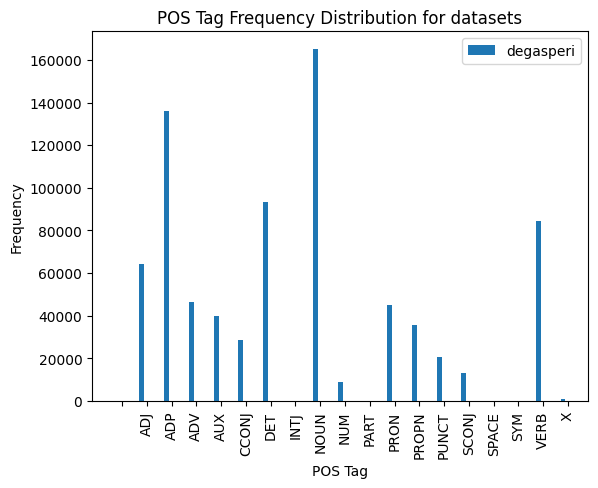

In [19]:
# Count the occurrences of each tag and plot them
pos_freq_all_datasets = Counter([tag for sentence in get_pos_tags_file() for tag in sentence])
list_counters = [pos_freq_all_datasets]
plot_groupedBar_counters(list_counters)

Here we do the same as before, but for any training dataset to visualize the 
differences between the datasets.

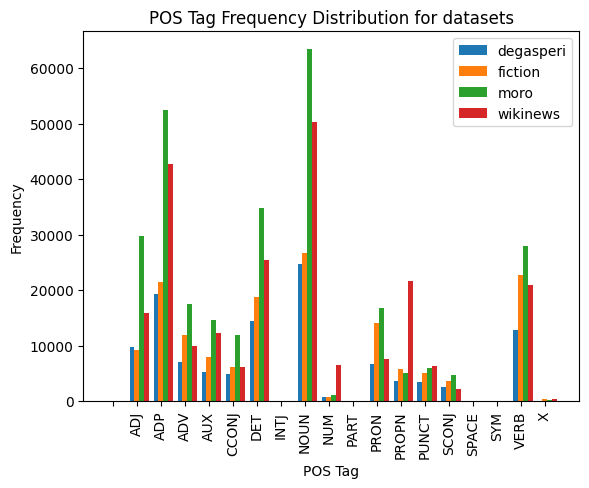

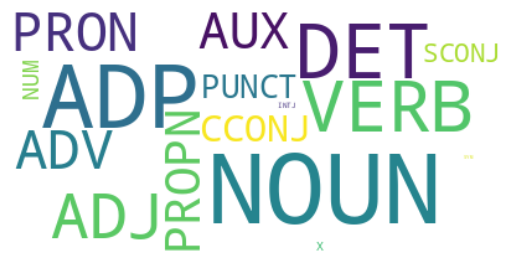

In [20]:
list_counters = []
# For each train dataset we take the save the occurrences of the tags
for dataset_name in datasets_train_dict_BIO.keys():
  tags = get_pos_tags_specific_file(dataset_name[:-4])
  pos_freq = Counter([tag for sentence in tags for tag in sentence])
  list_counters.append(pos_freq)

# Plot of all the counter in the same plot to compare them
plot_groupedBar_counters(list_counters)
plot_wordCloud_counters(list_counters)

## Indexing

Indexing is the process by which search engines organize information before a search to enable super-fast responses to queries. 
Searching through individual pages for keywords and topics would be a very slow process for search engines to identify relevant information. Instead, search engines use an inverted index, also known as a reverse index.
An inverted index is a system wherein a database of text elements is compiled along with pointers to the documents which contain those elements.



First of all, since we don't have a dataset of documents we decided to index the sentences inside our datasets.
To do that we have to create the sentences from the dictionary of datasets.

In [ ]:
sentences, labels, keys = get_all_sentences_from_datasets(datasets_train_dict_BIO)

degasperi_train_BIO.tsv
Converting the DataFrame of the datasetdegasperi_train_BIO.tsv


123504it [00:07, 15552.45it/s]


Removing short sentences from the dataset


100%|██████████| 3793/3793 [00:00<00:00, 1046782.15it/s]


fiction_train_BIO.tsv
Converting the DataFrame of the datasetfiction_train_BIO.tsv


170942it [00:08, 20565.18it/s]


Removing short sentences from the dataset


100%|██████████| 7479/7479 [00:00<00:00, 1112106.91it/s]


moro_train_BIO.tsv
Converting the DataFrame of the datasetmoro_train_BIO.tsv


309798it [00:16, 18341.33it/s]


Removing short sentences from the dataset


100%|██████████| 8747/8747 [00:00<00:00, 760127.98it/s]


wikinews_train_BIO.tsv
Converting the DataFrame of the datasetwikinews_train_BIO.tsv


249077it [00:13, 18863.66it/s]


Removing short sentences from the dataset


100%|██████████| 7522/7522 [00:00<00:00, 1544805.11it/s]


Then, we create the dataset of sentences adding also the Id to indetify them while the query part.

In [ ]:
sentences_df = pd.DataFrame(columns=['docno', 'text'])

for i in range(len(sentences)):
    sentences_df.loc[i] = [f's{i}', ' '.join(sentences[i])]

In the following cell, we index the sentences dataframe. The index, with all its data structures, is written into a directory that we will call `index`.
`Index_Ref` provides the location where the index is stored.

In [ ]:
index_path = "./index"

indexer = pt.DFIndexer(index_path, overwrite=True)
index_ref = indexer.index(sentences_df['text'], sentences_df['docno'])
index_ref.toString()

/usr/local/lib/python3.10/dist-packages/pyterrier/index.py:628: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, value in meta_column[1].iteritems():


'./index/data.properties'

Now we can now load the index and print it.
This is a Terrier index structure, which provides methods such as:
 - `getCollectionStatistics()`
 - `getInvertedIndex()`
 - `getLexicon()`

 Let's see what is returned by the `CollectionStatistics()` method.

In [ ]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

Number of documents: 27266
Number of terms: 45323
Number of postings: 605784
Number of fields: 0
Number of tokens: 672683
Field names: []
Positions:   false



Now that we have indexed our documents, we can run a search over the document collection.
Here we used the TF-IDF weighting formula to rank the results. 

The `search()` method returns a dataframe with columns:
 - `qid`: the query identifier
 - `docid`: integer identifier for document 
 - `docno`: string identifier for document
 - `rank`: rank position
 - `score`: tf-idf score
 - `query`: the input query

In [ ]:
br = pt.BatchRetrieve(index, wmodel="TF_IDF")

queries = pd.DataFrame([["query1", "festa"], ["query2", "ammiraglio"], ["query3", "messaggio audio"]], columns=["qid", "query"])
br(queries)

qid  docid   docno  rank     score            query
0    query1   2676   s2676     0  8.325796            festa
1    query1   9552   s9552     1  7.073557            festa
2    query1  10985  s10985     2  7.006632            festa
3    query1  10986  s10986     3  6.903667            festa
4    query1   2675   s2675     4  6.741746            festa
..      ...    ...     ...   ...       ...              ...
111  query3  20924  s20924    29  3.229611  messaggio audio
112  query3  26693  s26693    30  3.075286  messaggio audio
113  query3  11503  s11503    31  2.712377  messaggio audio
114  query3   2639   s2639    32  2.444511  messaggio audio
115  query3  25627  s25627    33  1.954528  messaggio audio

[116 rows x 6 columns]

## Conditional random fields

The conditional random fields model is a type of discriminative probabilistic model. It can be seen as an extention of the Hidden Markov Models.

HMM take a sequence of data, in the case of NER a sequence of words, and assumes that the observations are given by a set of not observable states which have to be tagged. There are transition probabilities between the states in the sequence (probability of going into a specific next state) and there are emission probability for each state that states which is the probability of a observation in a given state.

HMM is a generative model: it aims to model the joint probability of hidden state and observation simultaniously. In this framework the aim is to understand the way the data we have are generated.

HMM has some limitation:
- transition and emission probabilities are static, in every position of the sentence in our case;
- each state depends only on the previous state but in natural language processing this is not the case, also the observations can depend on previous states in the speech.

Conditional random fields model can be imagined as an extension of the HMM where it is possible to define whatever dependency between the states and between the states and the observations. The graphical representation is an undirected graph where the nodes are the states and the observations. The states are connected with each other in an arbitrary way and a state depends on the state to which it is connected through an edge.

It is clear that it is a more general framework for catching the dependencies between the state and also between states and observations.

Conditional random fields want to model the probability of the state conditioned the observations. The model is not generative. In the case of named entity recognition the model has to discriminate whether a token is part of an entity or not, given the words of a sentence.
Often a variant of the method, called linear chain CRF, is used, in particular when dealing with big datasets. In case of LCCRF only the dependencies between consequent states are considered whereas all the relations between observations and hidden states are possible.

The underlying idea is similar to the one of the logistic regression.

<br>
$\textbf{Mathematical model}$

Consider a set generic function, in this setting called feature function $$f_{j}(\textbf{x}, y_{i-1}, y_{i}, i),$$
with $\textbf{x}$ observations of the problem, so in the NER case the words of the sentences, $y_{i-1}$ the i-1-th state in the hidden states of the CRF, so the previous state, $y_{i}$ the i-th state in the hidden states of the CRF, so subsequent to $y_{i-1}$, and $i$ is the index of the current state in the states chain, in the NER task it is the position in the sentence.

The $f_{j}$ functions can be any possible function defined over that inputs, obviously for obtaining good results in the sequence labeling task they should be meaningful to the application.

Given a set of feature functions, is then possible to define $F_j$ as
$$F_j(\textbf{y},\textbf{x}) = \sum_{i=1}^{N} f_j(\textbf{x}, y_{i-1}, y_{i}, i)$$
with $N$ length of the provided sequence of observations.

In this setting, we define $\theta_j$ as the weights of each function $F_j$, so $\theta_j$ is giving more or less importance to some functions with respect to others. These will be the variables to optimize in the optimization step.

The conditioned probability of the sequence of states $\textbf{y}$ given the observations $\textbf{x}$ and the parameters $\boldsymbol{\theta}$ is

$$p(\textbf{y}|\textbf{x}, \boldsymbol{\theta}) = \frac{1}{Z(\textbf{x})}e^{\boldsymbol{\theta}^T \cdot \textbf{F}(\textbf{y},\textbf{x})},$$

considering that $\textbf{F}(\textbf{y},\textbf{x})$ is the vectorial representation of the $F_j$ and $\boldsymbol{\theta}$ is the vectorial representation of the $\theta_j$ and $Z(\textbf{x})$ a normalizing factor used to obtain a probability distribution.

The weights of the feature funtions are determined in the training phase of the CRF, e.g. through gradient descent.



### Application of the CRF to the dataset

In this section the CRF method for named entity recognition is applied.

The model that is used is the one coming from the library sklearn-crfsuite tha provides the funcitons for defining the model, for training and using it.

The conditional random fields of sklearn-crfsuite requires as input a list o list of dictionaries. In the case of the named entity recognition task, each dictionary is a word, the elements of the dictionary are the features of the word that will be considered in the training and prediction step. A single list of dictionaries is a sentence.

To summarize the input of the CRF training method will be a list of sentences, each one shaped as a list of dictionaries.

In the following some function for creating this representation are defined and then it is done the actual training and usage of the CRF.

The choise that has been done is to embed some features, defined "standard", in each trial and then enrich the representation by adding more elaborated features.

The features defined as "standard" are:
- word,
- lowercased word,
- whether the first letter is capitalized or not,
- whether the whole word is capitalized or not,
- whether the whole word is a number,
- position of the word in the sentence.

The additional features that can be added are:
- whether the word contains symbol of punctuation or not,
- features of the words that come before and after the considered word.

In the following snippets of code are analyzed additional, in principle promising, features:
- part-of-speech tags of the words,
- belonging of the words and of the sequence of words to the provided gazetteer,
- word2Vec embeddings of the words.

The analysis is provided for the BIO-tagged dataset but at the end a single CRF model is trained and tested on the not BIO-tagged dataset.

#### Function definition

Here we define some function needed for performing the named entity recognition task using crf-suite.

In [39]:
def standard_features_from_word(sentence, position, prefix='', punctuation_evaluation=False):
  '''
  Converts a word of the sentence into its representation given by a standard
  set of features that we consider the basis from which the feature vector can
  be enlarged

  This method has been implemented for having a crfsuite format representation
  of the dataset in order to apply use the conditional random fields framework
  provided by the sklearn_crfsuite package.

  Parameters
  ----------
  sentence: list
    list of the words composing the sentence.
  position: integer
    position in the list of the word that has to be converted into its feature 
    vector representation.
  prefix: str, optional
    string that can be appended before the names of the attributes of the 
    dictionary of features for specifying additional information.
  punctuation_evaluation: bool, optional
    True, to insert a feature about the fact that the word contains some
    punctiation elments, False to avoid inserting it.

  Returns
  -------
  standard_word_features: dict
    dictionary of the standard features of the word

  '''

  standard_word_features = None
  if position < len(sentence) and position >= 0:
    word = sentence[position]
    standard_word_features = {
          prefix+'word' : word,
          prefix+'word_lowercase' : word.lower(),
          prefix+'first_letter_upper' : word[0].isupper(),
          prefix+'all_letters_upper' : word.isupper(),
          prefix+'all_digits' : word.isdigit(),
          prefix+'position' : position,
    }
    if punctuation_evaluation:
      contains_punctuation = False
      for character in word:
        if character in string.punctuation:
          contains_punctuation = True
          break
      
      standard_word_features.update({prefix+'punctuation_inside' : contains_punctuation})

  return standard_word_features

################################################################################

def get_gazetteer_features(sentence, position, gazetteer_dict, gazetteer_entity_lenght=3,
                           prefix='', bio_tags=True):
  '''
  Returns the features related to the belonging of a word of the sentence to the 
  list of known entities.

  This method has been implemented for having a crfsuite format representation
  of the dataset in order to apply use the conditional random fields framework
  provided by the sklearn_crfsuite package.

  Parameters
  ----------
  sentence: list
    list of the words composing the sentence.
  position: integer
    position in the list of the word that has to be converted into its feature 
    vector representation.
  gazetteer_dict: dict
    dictionary containing a elements the sets of the known entities, each set 
    contains a different type of entity.
  gazetteer_entity_lenght: integer
    maximum length, in terms of number of words, of the known named entities.
    Incresing the length of the names of the entities will end up in a bigger 
    computational complexity but could end up in better results.
  prefix: str, optional
    string that can be appended before the names of the attributes of the 
    dictionary of features for specifying additional information.
  bio_tags: bool, optional
    True, for having a sort of begin-inside-outside notation in features related
    to the known entities, False, for having only the inside-outside notation.

  Returns
  -------
  gazetteer_features: dict
    dictionary of the features of the word reguarding the belonging of the word
    to the know entity lists.
    
  '''

  gazetteer_features = {}
  for key in gazetteer_dict:
    found = False
    for ent_len in range(1, gazetteer_entity_lenght+1):
      for i in range(ent_len):
        if position - i >= 0 and position + ent_len - i - 1 < len(sentence):
          entity = ' '.join(sentence[(position - i):(position + ent_len - i - 1 + 1)])
          if i == 0:
            if entity in gazetteer_dict[key]:
              if bio_tags:
                gazetteer_features.update({prefix+'B-'+key: True})
              else:
                gazetteer_features.update({prefix+key: True})
              found = True
          else:
            if entity in gazetteer_dict[key]:
              if bio_tags:
                gazetteer_features.update({prefix+'I-'+key: True})
              else:
                gazetteer_features.update({prefix+key: True})
              found = True
    if not found:
      gazetteer_features.update({key: False})

  return gazetteer_features
    
################################################################################

def transform_word_to_features(sentence, position, postags=None, embeddings=None,
                               previous_words_to_embed=1, next_words_to_embed=1,
                               gazetteer=None, gazetteer_entity_lenght=3, bio_tags=True,
                               punctuation_evaluation=False):
  '''
  Converts a word of the sentence into its representation given by a set of
  features. Some features are inserted by default some others can be requested
  through setting the optional parameters.

  This method has been implemented for having a crfsuite format representation
  of the dataset in order to apply use the conditional random fields framework
  provided by the sklearn_crfsuite package.

  Parameters
  ----------
  sentence: list
    list of the words composing the sentence.
  position: integer
    position in the list of the word that has to be converted into its feature 
    vector representation.
  postags: list, optional
    list of the part-of-speech tags related to the words of the sentence. This
    list has to be of the same length of the sentence list.
  embeddings: list, optional
    list of the embeddings related to the words of the sentence. This list has 
    to be of the same length of the sentence list.
  previous_words_to_embed: integer, optional
    number of words preceeding the considered word that hava to be embedded in 
    the feature representation of the considered word.
  next_words_to_embed: integer, optional
    number of words following the considered word that hava to be embedded in 
    the feature representation of the considered word.
  gazetteer: dict, optional
    dictionaty containing the known named entities. If None, it is assumed that
    gazetteer cannot be used.
  gazetteer_entity_lenght: integer, optional
    maximum length, in terms of number of words, of the known named entities.
    Incresing the length of the names of the entities will end up in a bigger 
    computational complexity but could end up in better results.
  bio_tags: bool, optional
    True, for having a sort of begin-inside-outside notation in features related
    to the known entities, False, for having only the inside-outside notation.
  punctuation_evaluation: bool, optional
    True, to insert a feature about the fact that the word contains some
    punctiation elments, False to avoid inserting it.

  Returns
  -------
  word_features: dict
    dictionary of the features of the word

  '''

  word_features = None
  if position < len(sentence) and position >= 0:
    # Getting the standard features for the word to convert into features
    word_features = standard_features_from_word(sentence, position, punctuation_evaluation=punctuation_evaluation)

    # Adding the embedding representation of the word to the features
    if embeddings != None:
      embedding = embeddings[position]
      length = len(embedding)
      for i in range(length):
        word_features.update({'dim'+str(i)+'-embedding' : embedding[i]})

    # Adding the POS tag to the features of the word
    if postags != None:
      word_features.update({'postag': postags[position]})
    
    # Embedding the context of the sentence inside the feature representation of
    # the word, adding the features of the previous words in the sentence
    if previous_words_to_embed > 0:
      i = 1
      while i < previous_words_to_embed + 1 and position-i >= 0:
        word_features.update(standard_features_from_word(sentence, position-i, prefix='-'+str(i)+':', punctuation_evaluation=punctuation_evaluation))
        if postags != None:
          word_features.update({'-'+str(i)+':postag': postags[position-i]})
        i += 1

    # Embedding the context of the sentence inside the feature representation of
    # the word, adding the features of the previous words in the sentence
    if next_words_to_embed > 0:
      i = 1
      while i < next_words_to_embed + 1 and position+i <= len(sentence)-1:
        word_features.update(standard_features_from_word(sentence, position+i, prefix='+'+str(i)+':', punctuation_evaluation=punctuation_evaluation))
        if postags != None:
          word_features.update({'+'+str(i)+':postag': postags[position+i]})
        i += 1

    if gazetteer != None:
      word_features.update(get_gazetteer_features(sentence, position, gazetteer, bio_tags=bio_tags))
  else:
    print('Wrong input, the index of the word in the sentence is not valid.')
  return word_features 

################################################################################

def transform_sentences_to_features(sentences, postags=None, embeddings=None, 
                                    previous_words_to_embed=1, next_words_to_embed=1,
                                    gazetteer=None, gazetteer_entity_lenght=3, bio_tags=True,
                                    punctuation_evaluation=False):
  '''
  Converts the sentences into their representation given by a list of 
  dictionaries of features. Some features are inserted by default some others 
  can be requested through setting the optional parameters.

  This method has been implemented for having a crfsuite format representation
  of the dataset in order to apply use the conditional random fields framework
  provided by the sklearn_crfsuite package.

  Parameters
  ----------
  sentence: list
    list of lists of the words composing the sentences.
  postag: list, optional
    list of lists of the part-of-speech tags related to the words of the 
    sentences. This list of lists has to have the same dimensions of the 
    sentence list.
  embeddings: list, optional
    list of lists of the embeddings related to the words of the sentences. This 
    list of lists has to have the same dimensions of the sentence list.
  previous_words_to_embed: integer, optional
    number of words preceeding the considered word that have to be embedded in 
    the feature representation of the considered word.
  next_words_to_embed: integer, optional
    number of words following the considered word that havae to be embedded in 
    the feature representation of the considered word.
  gazetteer: dict, optional
    dictionaty containing the known named entities. If None, it is assumed that
    gazetteer cannot be used.
  gazetteer_entity_lenght: integer, optional
    maximum length, in terms of number of words, of the known named entities.
    Incresing the length of the names of the entities will end up in a bigger 
    computational complexity but could end up in better results.
  bio_tags: bool, optional
    True, for having a sort of begin-inside-outside notation in features related
    to the known entities, False, for having only the inside-outside notation.
  punctuation_evaluation: bool, optional
    True, to insert a feature about the fact that the word contains some
    punctiation elments, False to avoid inserting it.

  Returns
  -------
  sentence_features: list
    representation of the sentences as a list of lists of dictionaries of features
  
  '''
  
  all_sentences_features = []
  for index,sentence in tqdm(enumerate(sentences)):
    sentence_features = []
    for i in range(len(sentence)):
      sentence_features.append(transform_word_to_features(sentence, i, postags=(postags[index] if postags != None else None), 
            embeddings=(embeddings[index] if embeddings != None else None), previous_words_to_embed=previous_words_to_embed, 
            next_words_to_embed=next_words_to_embed, gazetteer=gazetteer,
            gazetteer_entity_lenght=gazetteer_entity_lenght, bio_tags=bio_tags,
            punctuation_evaluation=punctuation_evaluation))
    all_sentences_features.append(sentence_features)
  return all_sentences_features


In [40]:
# Providing example of the format of input that takes the functions generating
# the features from the datasets
sentences_input_example = [
    ['Mark', 'Carman', 'è', 'fantastico!'],
    ['Anche', 'il', 'dottor', 'Scotti', 'è', 'fantastico!'], 
    ['Ciao', 'sono', 'Mike', 'e', 'sono', 'a', 'Milano']]

# Providing example of the output given by the functions generating the features
# from the datasets
output_features_example = transform_sentences_to_features(sentences_input_example, punctuation_evaluation=True)
output_features_example

3it [00:00, 3207.47it/s]


[[{'word': 'Mark',
   'word_lowercase': 'mark',
   'first_letter_upper': True,
   'all_letters_upper': False,
   'all_digits': False,
   'position': 0,
   'punctuation_inside': False,
   '+1:word': 'Carman',
   '+1:word_lowercase': 'carman',
   '+1:first_letter_upper': True,
   '+1:all_letters_upper': False,
   '+1:all_digits': False,
   '+1:position': 1,
   '+1:punctuation_inside': False},
  {'word': 'Carman',
   'word_lowercase': 'carman',
   'first_letter_upper': True,
   'all_letters_upper': False,
   'all_digits': False,
   'position': 1,
   'punctuation_inside': False,
   '-1:word': 'Mark',
   '-1:word_lowercase': 'mark',
   '-1:first_letter_upper': True,
   '-1:all_letters_upper': False,
   '-1:all_digits': False,
   '-1:position': 0,
   '-1:punctuation_inside': False,
   '+1:word': 'è',
   '+1:word_lowercase': 'è',
   '+1:first_letter_upper': False,
   '+1:all_letters_upper': False,
   '+1:all_digits': False,
   '+1:position': 2,
   '+1:punctuation_inside': False},
  {'word': '

#### Creation of the sentences and of the gazetteer sets

In [41]:
# Getting the sentences and the labels from the training dataset
sentences_merged_train_BIO, labels_merged_train_BIO, _ = get_all_sentences_from_datasets(datasets_train_dict_BIO, lower=False)
# Getting the sentences and the labels from the test dataset
sentences_merged_test_BIO, labels_merged_test_BIO, _ = get_all_sentences_from_datasets(datasets_test_dict_BIO, lower=False)

degasperi_train_BIO.tsv
Converting the DataFrame of the datasetdegasperi_train_BIO.tsv


123504it [00:08, 13957.01it/s]


Removing short sentences from the dataset


100%|██████████| 3793/3793 [00:00<00:00, 676144.12it/s]


fiction_train_BIO.tsv
Converting the DataFrame of the datasetfiction_train_BIO.tsv


170942it [00:11, 15188.03it/s]


Removing short sentences from the dataset


100%|██████████| 7479/7479 [00:00<00:00, 787023.93it/s]


moro_train_BIO.tsv
Converting the DataFrame of the datasetmoro_train_BIO.tsv


309798it [00:20, 15012.64it/s]


Removing short sentences from the dataset


100%|██████████| 8747/8747 [00:00<00:00, 560552.14it/s]


wikinews_train_BIO.tsv
Converting the DataFrame of the datasetwikinews_train_BIO.tsv


249077it [00:34, 7132.21it/s] 


Removing short sentences from the dataset


100%|██████████| 7522/7522 [00:00<00:00, 1351853.40it/s]


degasperi_test_BIO.tsv
Converting the DataFrame of the datasetdegasperi_test_BIO.tsv


27128it [00:01, 18150.60it/s]


Removing short sentences from the dataset


100%|██████████| 837/837 [00:00<00:00, 737837.84it/s]


fiction_test_BIO.tsv
Converting the DataFrame of the datasetfiction_test_BIO.tsv


21506it [00:01, 18326.32it/s]


Removing short sentences from the dataset


100%|██████████| 807/807 [00:00<00:00, 808021.80it/s]


moro_test_BIO.tsv
Converting the DataFrame of the datasetmoro_test_BIO.tsv


82806it [00:05, 16406.11it/s]


Removing short sentences from the dataset


100%|██████████| 2203/2203 [00:00<00:00, 802157.45it/s]


wikinews_test_BIO.tsv
Converting the DataFrame of the datasetwikinews_test_BIO.tsv


59220it [00:05, 11185.22it/s]


Removing short sentences from the dataset


100%|██████████| 1804/1804 [00:00<00:00, 656189.79it/s]


In [42]:
# Definition of a gazetteer sets
PATH_TO_GAZETTEER = '/content/KIND_project/datasets/Entities'
gazetteer_loc = set(line.replace('LOC','').strip() for line in open(PATH_TO_GAZETTEER + '/it-LOC-wikipedia.txt', encoding='utf-8'))
gazetteer_org = set(line.replace('ORG','').strip() for line in open(PATH_TO_GAZETTEER + '/it-ORG-wikipedia.txt', encoding='utf-8'))
gazetteer_per = set(line.replace('PER','').strip() for line in open(PATH_TO_GAZETTEER + '/it-PER-wikipedia.txt', encoding='utf-8'))
gazetteer_dict = {
    'LOC': gazetteer_loc,
    'ORG': gazetteer_org,
    'PER': gazetteer_per,
}
gazetteer = gazetteer_loc.union(gazetteer_org).union(gazetteer_per)

#### Fitting the model without POS tags and without gazetteer

In [43]:
# Converting the training dataset in the one required for training the model to
# perform the named entity recognition task through the conditional random 
# fields method
sentences_features_merged_train_BIO = transform_sentences_to_features(sentences_merged_train_BIO, 
                                                                      previous_words_to_embed=1,
                                                                      next_words_to_embed=1)

# Converting the test dataset in the one required for performing the named 
# entity recognition task through the conditional random fields method
sentences_features_merged_test_BIO = transform_sentences_to_features(sentences_merged_test_BIO, 
                                                                     previous_words_to_embed=1,
                                                                     next_words_to_embed=1)

27266it [00:05, 4863.74it/s]
5616it [00:01, 3793.83it/s]


In [44]:
#Creating the CRF model for NER
ner_crf_model_BIO = CRF(algorithm='lbfgs',
                    c1=0.1,
                    c2=0.1,
                    max_iterations=170,
                    verbose=True,
                    all_possible_transitions=False)

# Fitting the CRF model using the training set
ner_crf_model_BIO.fit(sentences_features_merged_train_BIO, labels_merged_train_BIO)

loading training data to CRFsuite: 100%|██████████| 27266/27266 [00:17<00:00, 1539.08it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 328414
Seconds required: 3.300

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 170
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=3.36  loss=853627.45 active=327521 feature_norm=0.50
Iter 2   time=0.90  loss=817545.18 active=320213 feature_norm=0.47
Iter 3   time=2.63  loss=626740.53 active=194741 feature_norm=0.18
Iter 4   time=1.77  loss=528115.75 active=296715 feature_norm=0.27
Iter 5   time=0.91  loss=507986.73 active=296780 feature_norm=0.26
Iter 6   time=0.89  loss=482189.39 active=242931 feature_norm=0.35
Iter 7   time=0.89  loss=463346.73 active=258312 feature_norm=0.36
Iter 8   time=0.89  loss=451459.02 active=249782 feature_norm=0.42
Iter 9   time=1.20  loss=374430.53 active=241031 feature_norm=

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    max_iterations=170, verbose=True)

In [45]:
# Defining the labels on which the performance evaluation has to be done
classes_BIO = list(ner_crf_model_BIO.classes_)
# Removing the class of words that are not entities in order to have the 
# evaluation of the performance considering only the classes of the entities
classes_BIO.remove('O')
classes_BIO.sort()

In [46]:
# Predicting the lables on the train set
prediction_merged_train_BIO = ner_crf_model_BIO.predict(sentences_features_merged_train_BIO)
# Predicting the lables on the test set
prediction_merged_test_BIO = ner_crf_model_BIO.predict(sentences_features_merged_test_BIO)

# Computing the flat f1-score on the train set
f1_score_train_BIO = crf_metrics.flat_f1_score(labels_merged_train_BIO, prediction_merged_train_BIO, 
                                               average='weighted', labels=classes_BIO)
# Computing the flat f1-score on the test set
f1_score_test_BIO = crf_metrics.flat_f1_score(labels_merged_test_BIO, prediction_merged_test_BIO,
                                              average='weighted', labels=classes_BIO)

print('Flat f1-score on the train set: ' + str(f1_score_train_BIO))
print('Flat f1-score on the test set: ' + str(f1_score_test_BIO))

Flat f1-score on the train set: 0.971782578366486
Flat f1-score on the test set: 0.7483881760724329


In [47]:
# Computing the main performance metrics on the train set
classification_report_train_BIO = crf_metrics.flat_classification_report(labels_merged_train_BIO, 
                                                                        prediction_merged_train_BIO,
                                                                        labels=classes_BIO)
print('Classification report on the train set: \n')
print(classification_report_train_BIO)

Classification report on the train set: 

              precision    recall  f1-score   support

       B-LOC       0.96      0.97      0.97      8023
       B-ORG       0.95      0.93      0.94      9209
       B-PER       0.99      0.99      0.99     10496
       I-LOC       0.97      0.98      0.98      2621
       I-ORG       0.97      0.96      0.97      5758
       I-PER       1.00      1.00      1.00      4403

   micro avg       0.97      0.97      0.97     40510
   macro avg       0.97      0.97      0.97     40510
weighted avg       0.97      0.97      0.97     40510



In [48]:
# Computing the main performance metrics on the test set
classification_report_test_BIO = crf_metrics.flat_classification_report(labels_merged_test_BIO, 
                                                                        prediction_merged_test_BIO,
                                                                        labels=classes_BIO)
print('Classification report on the test set: \n')
print(classification_report_test_BIO)

Classification report on the test set: 

              precision    recall  f1-score   support

       B-LOC       0.86      0.72      0.78      2573
       B-ORG       0.80      0.67      0.73      2169
       B-PER       0.82      0.69      0.75      1920
       I-LOC       0.71      0.60      0.65       678
       I-ORG       0.73      0.67      0.70      1391
       I-PER       0.80      0.88      0.84      1041

   micro avg       0.80      0.70      0.75      9772
   macro avg       0.79      0.70      0.74      9772
weighted avg       0.80      0.70      0.75      9772



In [49]:
# Displaying the most important features in terms of weights assigned to them
eli5.explain_weights(ner_crf_model_BIO, top=10)

Explanation(estimator="CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,\n    max_iterations=170, verbose=True)", description=None, error=None, method='CRF', is_regression=False, targets=[TargetExplanation(target='O', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='word:Partito', weight=4.949848, std=None, value=None), FeatureWeight(feature='word_lowercase:si', weight=4.903171, std=None, value=None), FeatureWeight(feature='word_lowercase:non', weight=4.669159, std=None, value=None), FeatureWeight(feature='word_lowercase:ma', weight=4.597346, std=None, value=None), FeatureWeight(feature='word_lowercase:è', weight=4.593623, std=None, value=None), FeatureWeight(feature='word_lowercase:da', weight=4.529585, std=None, value=None), FeatureWeight(feature='word_lowercase:in', weight=4.447256, std=None, value=None), FeatureWeight(feature='word_lowercase:ci', weight=4.445688, std=None, value=None), FeatureWeight(feature='word_lowercase:a', weight=4.372412, std=None, value=None), FeatureWeight(feature='word_lowercase:che', weight=4.367753, std=None, value=None)], neg=[], pos_remaining=25772, neg_remaining=6380), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='B-LOC', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='word_lowercase:europa', weight=4.355919, std=None, value=None), FeatureWeight(feature='word:Mezzogiorno', weight=3.909133, std=None, value=None), FeatureWeight(feature='word_lowercase:usa', weight=3.831895, std=None, value=None), FeatureWeight(feature='word_lowercase:mediterraneo', weight=3.770754, std=None, value=None), FeatureWeight(feature='word:Europa', weight=3.645983, std=None, value=None), FeatureWeight(feature='word:Africa', weight=3.572325, std=None, value=None), FeatureWeight(feature='word_lowercase:africa', weight=3.572325, std=None, value=None), FeatureWeight(feature='word_lowercase:turchia', weight=3.529741, std=None, value=None), FeatureWeight(feature='word_lowercase:cosentino', weight=3.477775, std=None, value=None), FeatureWeight(feature='word:cosentino', weight=3.477775, std=None, value=None)], neg=[], pos_remaining=6540, neg_remaining=438), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='I-LOC', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='-1:word_lowercase:ponte', weight=3.206318, std=None, value=None), FeatureWeight(feature='word_lowercase:dc', weight=2.769274, std=None, value=None), FeatureWeight(feature='-1:word_lowercase:ticino', weight=2.699339, std=None, value=None), FeatureWeight(feature='-1:word:Ticino', weight=2.699339, std=None, value=None), FeatureWeight(feature='-1:word_lowercase:piazza', weight=2.694821, std=None, value=None), FeatureWeight(feature='word_lowercase:occidentale', weight=2.694799, std=None, value=None), FeatureWeight(feature='-1:word_lowercase:palazzo', weight=2.617645, std=None, value=None), FeatureWeight(feature='-1:word:San', weight=2.594801, std=None, value=None), FeatureWeight(feature='-1:word_lowercase:san', weight=2.594641, std=None, value=None)], neg=[FeatureWeight(feature='-1:first_letter_upper', weight=-2.635144, std=None, value=None)], pos_remaining=4048, neg_remaining=244), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='B-ORG', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='word_lowercase:pci', weight=5.765747, std=None, value=None), FeatureWeight(feature='word_lowercase:dc', weight=5.467014, std=None, value=None), FeatureWeight(feature='word_lowercase:aeronautica', weight=5.101029, std=None, value=None), FeatureWeight(feature='word_lowercase:pri', weight=4.786177, std=None, value=None), FeatureWeight(feature='word_lowercase:psi', weight=4.549221, std=None, value=None), FeatureWeight(feature='word_lowercase:senato', weight=4.519652, std=None, value=None), FeatureWeight(feature='word_lowercase:pd', weight=4.47489, std=None, value=None), FeatureWeight(feature='word_lowercase:microsoft', weigh

From the metrics it is possible to see that the model reaches good performances even using just the standard features defined before and embedding the features of a single word before and after the considered word inside its features.

Embedding more words of the context improves a bit the results but the marginal improvement, in terms of performance measures, decreases with the number of words embedded. Moreover inserting in the features of a word the ones of a lot of words next to it, increases a lot the computational complexity of the training.

From the tables displayed using the eli5 packet, it is possible to recognise the fact that the transition probability between the BIO tags are catched by the model. In the subsequent table there are the weights associated to the possible values of the features. The model is mainly learning the words to recognise as entities and it is learning also the ones that are not entities, in particular we can identify a lot of stopwords in the outside class.



#### Fitting the model with also gazetteer

In [20]:
# Converting the training dataset in the one required for training the model to
# perform the named entity recognition task through the conditional random 
# fields method, here it is considered also whether a word, or sequence of words,
# is in the set of known entities.
sentences_features_merged_train_gaz_BIO = transform_sentences_to_features(sentences_merged_train_BIO,
                                                                          previous_words_to_embed=1,
                                                                          next_words_to_embed=1,
                                                                          gazetteer = gazetteer_dict,
                                                                          gazetteer_entity_lenght=6)

# Converting the test dataset in the one required for test the model to perform
# the named entity recognition task through the conditional random fields method,
# here it is considered also whether a word, or sequence of words, is in the set
# of known entities.
sentences_features_merged_test_gaz_BIO = transform_sentences_to_features(sentences_merged_test_BIO,
                                                                         previous_words_to_embed=1,
                                                                         next_words_to_embed=1,
                                                                         gazetteer = gazetteer_dict,
                                                                         gazetteer_entity_lenght=6)

27266it [00:18, 1452.80it/s]
5616it [00:03, 1631.67it/s]


In [21]:
#Creating the CRF model for NER
ner_crf_model_gaz_BIO = CRF(algorithm='lbfgs',
                            c1=0.1,
                            c2=0.1,
                            max_iterations=200,
                            verbose=True,
                            all_possible_transitions=False)

# Fitting the CRF model using the training set
ner_crf_model_gaz_BIO.fit(sentences_features_merged_train_gaz_BIO, labels_merged_train_BIO)

loading training data to CRFsuite: 100%|██████████| 27266/27266 [00:15<00:00, 1736.21it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 328477
Seconds required: 2.126

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=2.22  loss=853628.07 active=327563 feature_norm=0.50
Iter 2   time=0.73  loss=817543.22 active=320252 feature_norm=0.47
Iter 3   time=2.69  loss=626692.42 active=194780 feature_norm=0.18
Iter 4   time=2.16  loss=528043.98 active=296767 feature_norm=0.27
Iter 5   time=1.04  loss=507904.27 active=296834 feature_norm=0.26
Iter 6   time=0.74  loss=481964.12 active=242963 feature_norm=0.35
Iter 7   time=0.76  loss=463128.86 active=258359 feature_norm=0.36
Iter 8   time=0.74  loss=451164.93 active=249817 feature_norm=0.42
Iter 9   time=0.73  loss=373180.74 active=241068 feature_norm=

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    max_iterations=200, verbose=True)

In [22]:
# Defining the labels on which the performance evaluation has to be done
classes_gaz_BIO = list(ner_crf_model_gaz_BIO.classes_)
# Removing the class of words that are not entities in order to have the 
# evaluation of the performance considering only the classes of the entities
classes_gaz_BIO.remove('O')
classes_gaz_BIO.sort()

In [23]:
# Predicting the lables on the train set
prediction_merged_train_gaz_BIO = ner_crf_model_gaz_BIO.predict(sentences_features_merged_train_gaz_BIO)
# Predicting the lables on the test set
prediction_merged_test_gaz_BIO = ner_crf_model_gaz_BIO.predict(sentences_features_merged_test_gaz_BIO)

# Computing the flat f1-score on the train set
f1_score_train_gaz_BIO = crf_metrics.flat_f1_score(labels_merged_train_BIO, prediction_merged_train_gaz_BIO,
                                                   average='weighted', labels=classes_gaz_BIO)
# Computing the flat f1-score on the test set
f1_score_test_gaz_BIO = crf_metrics.flat_f1_score(labels_merged_test_BIO, prediction_merged_test_gaz_BIO,
                                                  average='weighted', labels=classes_gaz_BIO)

print('Flat f1-score on the train set: ' + str(f1_score_train_gaz_BIO))
print('Flat f1-score on the test set: ' + str(f1_score_test_gaz_BIO))

Flat f1-score on the train set: 0.9711280671127892
Flat f1-score on the test set: 0.791712600781273


In [24]:
# Computing the main performance metrics on the train set
classification_report_train_gaz_BIO = crf_metrics.flat_classification_report(labels_merged_train_BIO,
                                                                            prediction_merged_train_gaz_BIO,
                                                                            labels=classes_gaz_BIO)
print('Classification report on the train set: \n')
print(classification_report_train_gaz_BIO)

Classification report on the train set: 

              precision    recall  f1-score   support

       B-LOC       0.96      0.97      0.97      8023
       B-ORG       0.95      0.93      0.94      9209
       B-PER       0.99      0.99      0.99     10496
       I-LOC       0.97      0.98      0.98      2621
       I-ORG       0.97      0.96      0.96      5758
       I-PER       1.00      1.00      1.00      4403

   micro avg       0.97      0.97      0.97     40510
   macro avg       0.97      0.97      0.97     40510
weighted avg       0.97      0.97      0.97     40510



In [25]:
# Computing the main performance metrics on the test set
classification_report_test_gaz_BIO = crf_metrics.flat_classification_report(labels_merged_test_BIO,
                                                                                prediction_merged_test_gaz_BIO,
                                                                                labels=classes_gaz_BIO)
print('Classification report on the test set: ')
print(classification_report_test_gaz_BIO)

Classification report on the test set: 
              precision    recall  f1-score   support

       B-LOC       0.87      0.81      0.84      2573
       B-ORG       0.81      0.70      0.75      2169
       B-PER       0.89      0.75      0.82      1920
       I-LOC       0.70      0.67      0.69       678
       I-ORG       0.74      0.69      0.72      1391
       I-PER       0.89      0.87      0.88      1041

   micro avg       0.83      0.76      0.79      9772
   macro avg       0.82      0.75      0.78      9772
weighted avg       0.83      0.76      0.79      9772



In [26]:
# Displaying the most important features in terms of weights assigned to them
eli5.explain_weights(ner_crf_model_gaz_BIO, top=100)

Explanation(estimator="CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,\n    max_iterations=200, verbose=True)", description=None, error=None, method='CRF', is_regression=False, targets=[TargetExplanation(target='O', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='word_lowercase:nel', weight=5.471933, std=None, value=None), FeatureWeight(feature='word_lowercase:che', weight=5.183679, std=None, value=None), FeatureWeight(feature='word_lowercase:questa', weight=4.950292, std=None, value=None), FeatureWeight(feature='word:Egli', weight=4.815529, std=None, value=None), FeatureWeight(feature='word_lowercase:con', weight=4.78167, std=None, value=None), FeatureWeight(feature='word_lowercase:il', weight=4.653694, std=None, value=None), FeatureWeight(feature='word_lowercase:egli', weight=4.483785, std=None, value=None), FeatureWeight(feature='word_lowercase:è', weight=4.468566, std=None, value=None), FeatureWeight(feature='word_lowercase:dal', weight=4.457581, std=None, value=None), FeatureWeight(feature='word_lowercase:fu', weight=4.44827, std=None, value=None), FeatureWeight(feature='word_lowercase:a', weight=4.41359, std=None, value=None), FeatureWeight(feature='word_lowercase:un', weight=4.408117, std=None, value=None), FeatureWeight(feature='word_lowercase:ma', weight=4.394833, std=None, value=None), FeatureWeight(feature='word_lowercase:una', weight=4.39402, std=None, value=None), FeatureWeight(feature='word_lowercase:si', weight=4.323416, std=None, value=None), FeatureWeight(feature='word:E', weight=4.308316, std=None, value=None), FeatureWeight(feature='word:Poi', weight=4.269853, std=None, value=None), FeatureWeight(feature='word_lowercase:non', weight=4.222323, std=None, value=None), FeatureWeight(feature='word:Una', weight=4.221539, std=None, value=None), FeatureWeight(feature='word_lowercase:durante', weight=4.214643, std=None, value=None), FeatureWeight(feature='word_lowercase:solo', weight=4.172826, std=None, value=None), FeatureWeight(feature='word_lowercase:sono', weight=4.1488, std=None, value=None), FeatureWeight(feature='word_lowercase:in', weight=4.121485, std=None, value=None), FeatureWeight(feature='word_lowercase:poi', weight=4.105181, std=None, value=None), FeatureWeight(feature='word_lowercase:delle', weight=4.068073, std=None, value=None), FeatureWeight(feature='word_lowercase:le', weight=4.058038, std=None, value=None), FeatureWeight(feature='word:Nel', weight=4.048256, std=None, value=None), FeatureWeight(feature='word:Questa', weight=4.018098, std=None, value=None), FeatureWeight(feature='word:Sono', weight=4.010498, std=None, value=None), FeatureWeight(feature='word_lowercase:meglio', weight=4.010493, std=None, value=None), FeatureWeight(feature='word_lowercase:esso', weight=3.991959, std=None, value=None), FeatureWeight(feature='word_lowercase:papa', weight=3.896968, std=None, value=None), FeatureWeight(feature='word_lowercase:ai', weight=3.882004, std=None, value=None), FeatureWeight(feature='word_lowercase:quel', weight=3.850401, std=None, value=None), FeatureWeight(feature='word_lowercase:questi', weight=3.837831, std=None, value=None), FeatureWeight(feature='word_lowercase:qui', weight=3.836868, std=None, value=None), FeatureWeight(feature='word:Ne', weight=3.827987, std=None, value=None), FeatureWeight(feature='word_lowercase:la', weight=3.81865, std=None, value=None), FeatureWeight(feature='word_lowercase:ne', weight=3.811191, std=None, value=None), FeatureWeight(feature='word_lowercase:come', weight=3.801095, std=None, value=None), FeatureWeight(feature='word_lowercase:quale', weight=3.790955, std=None, value=None), FeatureWeight(feature='word_lowercase:circa', weight=3.789353, std=None, value=None), FeatureWeight(feature='word_lowercase:né', weight=3.776755, std=None, value=None), FeatureWeight(feature='word_lowercase:ad', weight=3.769373, std=None, value=None), FeatureWeight(feature='word_lowercase:paese', weight=3.747602, std=None, value=None), FeatureWeight(feat

The performance measure increase significantly adding also the gazetteer, this means that the model correctly learns some rules about the new added features.

The learning of the model goes in the direction of assigning a big weight to words that in the learning appears to be entities, as in the previous case.

The introduction of the feature of belonging to the gazetteer is correcty learnt by the model that assigns an high weight to the feature of the belonging of a word to an entity class inside the correct class. For example, it is possible to see that it assigns a big walue to the fact that 'B-LOC' is set to True for the words classifies as 'B-LOC'. This happens for all the classes of entities, for the person class it is a lot more important for the model to know the name and the previous word for finding a person entity that to read that the word belongs to the gazetteer.

It can be noticed that the model also learns the fact that a named entity of one type cannot be of another type and so, for example, it assigns a negative weight to the features 'B-ORG' and 'I_LOC' for the classification in the class 'I_PER'.

In order to improve more the meaninfulness of the usage of the gazetteer, it could be possible to add the named entity of the train set inside the gazetteer since they are manually annotated. This could be useful since some entities could not be in the gazetteer and some others could the written using a different form, e.g. using spaces or lines in different ways.

#### Fitting the model with also POS tags

In [39]:
# Converting the training dataset in the one required for training the model to
# perform the named entity recognition task through the conditional random 
# fields method, here it is considered also whether a word, or sequence of words,
# is in the set of known entities. The features in this section include also the
# part-of-speech tags
sentences_features_merged_train_gaz_pos_BIO = transform_sentences_to_features(sentences_merged_train_BIO,
                                                                          postags = get_pos_tags_file(short=True),
                                                                          previous_words_to_embed=2, 
                                                                          next_words_to_embed=2,
                                                                          gazetteer = gazetteer_dict,
                                                                          gazetteer_entity_lenght = 6)

# Converting the test dataset in the one required for test the model to perform
# the named entity recognition task through the conditional random fields method,
# here it is considered also whether a word, or sequence of words, is in the set
# of known entities. The features in this section include also the 
# part-of-speech tags
sentences_features_merged_test_gaz_pos_BIO = transform_sentences_to_features(sentences_merged_test_BIO,
                                                                             postags = get_pos_tags_file(train_or_test=False, short=True),
                                                                             previous_words_to_embed=2,
                                                                             next_words_to_embed=2,
                                                                             gazetteer = gazetteer_dict,
                                                                             gazetteer_entity_lenght = 6)

27266it [00:32, 835.17it/s]
5616it [00:10, 531.30it/s]


In [40]:
#Creating the CRF model for NER
ner_crf_model_gaz_pos_BIO = CRF(algorithm='lbfgs',
                                c1=0.1,
                                c2=0.1,
                                max_iterations=100,
                                verbose=True,
                                all_possible_transitions=False)

# Fitting the CRF model using the training set
ner_crf_model_gaz_pos_BIO.fit(sentences_features_merged_train_gaz_pos_BIO, labels_merged_train_BIO)

loading training data to CRFsuite: 100%|██████████| 27266/27266 [00:43<00:00, 629.84it/s] 



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 566221
Seconds required: 4.446

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=5.49  loss=1018078.10 active=564055 feature_norm=0.50
Iter 2   time=1.88  loss=968727.76 active=546771 feature_norm=0.47
Iter 3   time=1.49  loss=906779.50 active=277576 feature_norm=0.63
Iter 4   time=1.76  loss=904150.95 active=565030 feature_norm=0.76
Iter 5   time=1.94  loss=846821.80 active=565511 feature_norm=0.76
Iter 6   time=1.91  loss=215792.37 active=301242 feature_norm=7.76
Iter 7   time=7.63  loss=202134.79 active=394302 feature_norm=7.95
Iter 8   time=1.98  loss=184492.98 active=380691 feature_norm=6.47
Iter 9   time=1.98  loss=171485.47 active=387869 feature_norm

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    max_iterations=100, verbose=True)

In [41]:
# Defining the labels on which the performance evaluation has to be done
classes_gaz_pos_BIO = list(ner_crf_model_gaz_pos_BIO.classes_)
# Removing the class of words that are not entities in order to have the 
# evaluation of the performance considering only the classes of the entities
classes_gaz_pos_BIO.remove('O')
classes_gaz_pos_BIO.sort()

In [42]:
# Predicting the lables on the train set
prediction_merged_train_gaz_pos_BIO = ner_crf_model_gaz_pos_BIO.predict(sentences_features_merged_train_gaz_pos_BIO)
# Predicting the lables on the test set
prediction_merged_test_gaz_pos_BIO = ner_crf_model_gaz_pos_BIO.predict(sentences_features_merged_test_gaz_pos_BIO)

# Computing the flat f1-score on the train set
f1_score_train_gaz_pos_BIO = crf_metrics.flat_f1_score(labels_merged_train_BIO, prediction_merged_train_gaz_pos_BIO,
                                       average='weighted', labels=classes_gaz_pos_BIO)
# Computing the flat f1-score on the test set
f1_score_test_gaz_pos_BIO = crf_metrics.flat_f1_score(labels_merged_test_BIO, prediction_merged_test_gaz_pos_BIO,
                                      average='weighted', labels=classes_gaz_pos_BIO)

print('Flat f1-score on the train set: ' + str(f1_score_train_gaz_pos_BIO))
print('Flat f1-score on the test set: ' + str(f1_score_test_gaz_pos_BIO))

Flat f1-score on the train set: 0.9926966154117681
Flat f1-score on the test set: 0.7981005765276826


In [43]:
# Computing the main performance metrics on the train set
classification_report_train_gaz_pos_BIO = crf_metrics.flat_classification_report(labels_merged_train_BIO,
                                                                                 prediction_merged_train_gaz_pos_BIO,
                                                                                 labels=classes_gaz_pos_BIO)
print('Classification report on the train set: \n')
print(classification_report_train_gaz_pos_BIO)

Classification report on the train set: 

              precision    recall  f1-score   support

       B-LOC       0.99      1.00      0.99      8023
       B-ORG       0.98      0.98      0.98      9209
       B-PER       1.00      1.00      1.00     10496
       I-LOC       1.00      1.00      1.00      2621
       I-ORG       0.99      0.99      0.99      5758
       I-PER       1.00      1.00      1.00      4403

   micro avg       0.99      0.99      0.99     40510
   macro avg       0.99      0.99      0.99     40510
weighted avg       0.99      0.99      0.99     40510



In [44]:
# Computing the main performance metrics on the test set
classification_report_test_gaz_pos_BIO = crf_metrics.flat_classification_report(labels_merged_test_BIO,
                                                                                prediction_merged_test_gaz_pos_BIO,
                                                                                labels=classes_gaz_pos_BIO)
print('Classification report on the test set: ')
print(classification_report_test_gaz_pos_BIO)

Classification report on the test set: 
              precision    recall  f1-score   support

       B-LOC       0.87      0.82      0.84      2573
       B-ORG       0.80      0.71      0.76      2169
       B-PER       0.88      0.78      0.83      1920
       I-LOC       0.72      0.67      0.69       678
       I-ORG       0.75      0.69      0.72      1391
       I-PER       0.89      0.91      0.90      1041

   micro avg       0.83      0.77      0.80      9772
   macro avg       0.82      0.76      0.79      9772
weighted avg       0.83      0.77      0.80      9772



In [45]:
# Displaying the most important features in terms of weights assigned to them
eli5.explain_weights(ner_crf_model_gaz_pos_BIO, top=100)

Explanation(estimator="CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,\n    max_iterations=100, verbose=True)", description=None, error=None, method='CRF', is_regression=False, targets=[TargetExplanation(target='O', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='word_lowercase:nel', weight=5.005556, std=None, value=None), FeatureWeight(feature='postag:ADV', weight=4.774879, std=None, value=None), FeatureWeight(feature='word_lowercase:una', weight=4.520767, std=None, value=None), FeatureWeight(feature='word_lowercase:che', weight=4.497945, std=None, value=None), FeatureWeight(feature='word_lowercase:un', weight=4.309984, std=None, value=None), FeatureWeight(feature='postag:AUX', weight=4.180187, std=None, value=None), FeatureWeight(feature='postag:VERB', weight=4.042947, std=None, value=None), FeatureWeight(feature='word_lowercase:il', weight=3.97944, std=None, value=None), FeatureWeight(feature='word_lowercase:con', weight=3.953659, std=None, value=None), FeatureWeight(feature='word_lowercase:papa', weight=3.909993, std=None, value=None), FeatureWeight(feature='word_lowercase:ma', weight=3.900403, std=None, value=None), FeatureWeight(feature='word_lowercase:dal', weight=3.896802, std=None, value=None), FeatureWeight(feature='postag:INTJ', weight=3.839372, std=None, value=None), FeatureWeight(feature='word_lowercase:in', weight=3.775501, std=None, value=None), FeatureWeight(feature='word:Arcivescovo', weight=3.747886, std=None, value=None), FeatureWeight(feature='word_lowercase:egli', weight=3.645176, std=None, value=None), FeatureWeight(feature='word_lowercase:durante', weight=3.590824, std=None, value=None), FeatureWeight(feature='word_lowercase:a', weight=3.567989, std=None, value=None), FeatureWeight(feature='word_lowercase:questa', weight=3.47691, std=None, value=None), FeatureWeight(feature='word_lowercase:ad', weight=3.470116, std=None, value=None), FeatureWeight(feature='-1:word_lowercase:ciclone', weight=3.456907, std=None, value=None), FeatureWeight(feature='word_lowercase:pontefice', weight=3.452495, std=None, value=None), FeatureWeight(feature='word_lowercase:è', weight=3.416827, std=None, value=None), FeatureWeight(feature='word_lowercase:né', weight=3.415267, std=None, value=None), FeatureWeight(feature='word:Dei', weight=3.394226, std=None, value=None), FeatureWeight(feature='word_lowercase:dalla', weight=3.368359, std=None, value=None), FeatureWeight(feature='word_lowercase:ai', weight=3.356438, std=None, value=None), FeatureWeight(feature='word_lowercase:sono', weight=3.331868, std=None, value=None), FeatureWeight(feature='word:»', weight=3.31988, std=None, value=None), FeatureWeight(feature='word_lowercase:»', weight=3.31988, std=None, value=None), FeatureWeight(feature='word_lowercase:ed', weight=3.313198, std=None, value=None), FeatureWeight(feature='word:Egli', weight=3.301834, std=None, value=None), FeatureWeight(feature='word:Papa', weight=3.28932, std=None, value=None), FeatureWeight(feature='word_lowercase:si', weight=3.270891, std=None, value=None), FeatureWeight(feature='word:E', weight=3.243155, std=None, value=None), FeatureWeight(feature='word_lowercase:da', weight=3.2232, std=None, value=None), FeatureWeight(feature='postag:SCONJ', weight=3.219684, std=None, value=None), FeatureWeight(feature='word_lowercase:non', weight=3.153395, std=None, value=None), FeatureWeight(feature="word:L'", weight=3.15048, std=None, value=None), FeatureWeight(feature='-2:word:Patrono', weight=3.109507, std=None, value=None), FeatureWeight(feature='word:Per', weight=3.099007, std=None, value=None), FeatureWeight(feature='-2:word_lowercase:coppa', weight=3.092151, std=None, value=None), FeatureWeight(feature='postag:PRON', weight=3.077877, std=None, value=None), FeatureWeight(feature='word_lowercase:nella', weight=3.065925, std=None, value=None), FeatureWeight(feature='-2:word:Legislatura', weight=3.062936, std=None, value=None), FeatureWeight(feature='word_lowercase:seppi', weight=3.03

The performace measures slightly improve adding also the part-of-speech tags.

The learning of the model still goes in the direction of assigning a big weight to words that in the learning phase appear to be entities, as in the previous cases.

All the part-of-speech tags have a very big weight for the outside class, the one that is assigned to the words that are not entities. This could be cause by the fact that the model sees many more words that are not named entities with that features than the ones that are entities.
Even if this is not so informative, and even if a lot of pos tags have negative weights in the other classes, it is interesting to notice that pos tags such as 'VERB' and 'ADJ' have a very negative weights in the case of classes that are not the 'O' one. The model has learnt that the words that are verbs or adjectives, with high probability, are not named entities.

#### Fitting the model using embeddings representation of the words

In [52]:
# Creating the embedding representation of each word keeping the same structure
# and ordering of the list of sentences in order to be able to create the 
# features of the words starting from the list of the embeddings
embedding_train = [[get_word2vec_vector(sentences_merged_train_BIO[i][j], embeddings_model_train) for j in range(len(sentences_merged_train_BIO[i]))] for i in range(len(sentences_merged_train_BIO))]
embedding_test = [[get_word2vec_vector(sentences_merged_test_BIO[i][j], embeddings_model_train) for j in range(len(sentences_merged_test_BIO[i]))] for i in range(len(sentences_merged_test_BIO))]

In [53]:
# Converting the training dataset in the one required for training the model to
# perform the named entity recognition task through the conditional random 
# fields method with as features also the embedding representation of the words
sentences_features_merged_train_emb_BIO = transform_sentences_to_features(sentences_merged_train_BIO,
                                                                          previous_words_to_embed=1,
                                                                          next_words_to_embed=1,
                                                                          embeddings = embedding_train)

# Converting the test dataset in the one required for performing the named 
# entity recognition task through the conditional random fields method with as 
# features also the embedding representation of the words
sentences_features_merged_test_emb_BIO = transform_sentences_to_features(sentences_merged_test_BIO,
                                                                         previous_words_to_embed=1,
                                                                         next_words_to_embed=1,
                                                                         embeddings = embedding_test)

27266it [00:47, 571.71it/s]
5616it [00:12, 465.95it/s]


In [54]:
#Creating the CRF model for NER
ner_crf_model_emb_BIO = CRF(algorithm='lbfgs',
                            c1=0.1,
                            c2=0.1,
                            max_iterations=150,
                            verbose=True,
                            all_possible_transitions=False)

# Fitting the CRF model using the training set
ner_crf_model_emb_BIO.fit(sentences_features_merged_train_emb_BIO, labels_merged_train_BIO)

loading training data to CRFsuite: 100%|██████████| 27266/27266 [01:06<00:00, 407.71it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 328630
Seconds required: 7.526

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 150
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=6.33  loss=850064.44 active=327737 feature_norm=0.50
Iter 2   time=1.99  loss=813527.07 active=320412 feature_norm=0.47
Iter 3   time=2.77  loss=479174.84 active=183140 feature_norm=0.89
Iter 4   time=4.64  loss=404685.05 active=325610 feature_norm=0.94
Iter 5   time=1.98  loss=352174.82 active=318478 feature_norm=1.23
Iter 6   time=1.98  loss=308013.28 active=215231 feature_norm=2.72
Iter 7   time=1.99  loss=295507.10 active=256804 feature_norm=2.33
Iter 8   time=2.17  loss=251165.73 active=260257 feature_norm=2.26
Iter 9   time=7.25  loss=234145.83 active=263413 feature_norm=

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    max_iterations=150, verbose=True)

In [55]:
# Defining the labels on which the performance evaluation has to be done
classes_emb_BIO = list(ner_crf_model_emb_BIO.classes_)
# Removing the class of words that are not entities in order to have the 
# evaluation of the performance considering only the classes of the entities
classes_emb_BIO.remove('O')
classes_emb_BIO.sort()

In [56]:
# Predicting the lables on the train set
prediction_merged_train_emb_BIO = ner_crf_model_emb_BIO.predict(sentences_features_merged_train_emb_BIO)
# Predicting the lables on the test set
prediction_merged_test_emb_BIO = ner_crf_model_emb_BIO.predict(sentences_features_merged_test_emb_BIO)

# Computing the flat f1-score on the train set
f1_score_train_emb_BIO = crf_metrics.flat_f1_score(labels_merged_train_BIO, prediction_merged_train_emb_BIO,
                                                   average='weighted', labels=classes_emb_BIO)
# Computing the flat f1-score on the test set
f1_score_test_emb_BIO = crf_metrics.flat_f1_score(labels_merged_test_BIO, prediction_merged_test_emb_BIO,
                                                  average='weighted', labels=classes_emb_BIO)

print('Flat f1-score on the train set: ' + str(f1_score_train_emb_BIO))
print('Flat f1-score on the test set: ' + str(f1_score_test_emb_BIO))

Flat f1-score on the train set: 0.9722739954686128
Flat f1-score on the test set: 0.7533131982026519


In [57]:
# Computing the main performance metrics on the train set
classification_report_train_emb_BIO = crf_metrics.flat_classification_report(labels_merged_train_BIO,
                                                                             prediction_merged_train_emb_BIO,
                                                                             labels=classes_emb_BIO)
print('Classification report on the train set: \n')
print(classification_report_train_emb_BIO)

Classification report on the train set: 

              precision    recall  f1-score   support

       B-LOC       0.96      0.98      0.97      8023
       B-ORG       0.95      0.93      0.94      9209
       B-PER       0.99      0.99      0.99     10496
       I-LOC       0.97      0.98      0.98      2621
       I-ORG       0.97      0.96      0.97      5758
       I-PER       1.00      1.00      1.00      4403

   micro avg       0.97      0.97      0.97     40510
   macro avg       0.97      0.97      0.97     40510
weighted avg       0.97      0.97      0.97     40510



In [58]:
# Computing the main performance metrics on the test set
classification_report_test_emb_BIO = crf_metrics.flat_classification_report(labels_merged_test_BIO,
                                                                             prediction_merged_test_emb_BIO,
                                                                             labels=classes_emb_BIO)
print('Classification report on the test set: \n')
print(classification_report_test_emb_BIO)

Classification report on the test set: 

              precision    recall  f1-score   support

       B-LOC       0.84      0.75      0.79      2573
       B-ORG       0.79      0.68      0.73      2169
       B-PER       0.80      0.71      0.75      1920
       I-LOC       0.63      0.65      0.64       678
       I-ORG       0.72      0.69      0.70      1391
       I-PER       0.79      0.89      0.84      1041

   micro avg       0.78      0.73      0.75      9772
   macro avg       0.76      0.73      0.74      9772
weighted avg       0.79      0.73      0.75      9772



In [59]:
# Displaying the most important features in terms of weights assigned to them
eli5.explain_weights(ner_crf_model_emb_BIO, top=100)

Explanation(estimator="CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,\n    max_iterations=150, verbose=True)", description=None, error=None, method='CRF', is_regression=False, targets=[TargetExplanation(target='O', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='word_lowercase:anni', weight=4.743201, std=None, value=None), FeatureWeight(feature='word:—', weight=4.522903, std=None, value=None), FeatureWeight(feature='word_lowercase:—', weight=4.522903, std=None, value=None), FeatureWeight(feature="word_lowercase:l'", weight=4.347041, std=None, value=None), FeatureWeight(feature='word:anni', weight=4.266279, std=None, value=None), FeatureWeight(feature='word_lowercase:presidente', weight=4.15732, std=None, value=None), FeatureWeight(feature='word_lowercase:ha', weight=3.866569, std=None, value=None), FeatureWeight(feature='word:«', weight=3.58682, std=None, value=None), FeatureWeight(feature='word_lowercase:«', weight=3.58682, std=None, value=None), FeatureWeight(feature='word:ha', weight=3.577376, std=None, value=None), FeatureWeight(feature='word_lowercase:morte', weight=3.335636, std=None, value=None), FeatureWeight(feature='word:Comunità', weight=3.325272, std=None, value=None), FeatureWeight(feature='word:CL', weight=3.30075, std=None, value=None), FeatureWeight(feature='word:M', weight=3.247305, std=None, value=None), FeatureWeight(feature='word:Istituto', weight=3.239474, std=None, value=None), FeatureWeight(feature='word:Presidente', weight=3.184812, std=None, value=None), FeatureWeight(feature='word:Il', weight=3.112474, std=None, value=None), FeatureWeight(feature='word_lowercase:uomo', weight=3.089059, std=None, value=None), FeatureWeight(feature='word_lowercase:ministro', weight=3.088239, std=None, value=None), FeatureWeight(feature='word_lowercase:dopo', weight=3.051447, std=None, value=None), FeatureWeight(feature="word_lowercase:all'", weight=2.904984, std=None, value=None), FeatureWeight(feature='word:La', weight=2.899314, std=None, value=None), FeatureWeight(feature='word_lowercase:nella', weight=2.896916, std=None, value=None), FeatureWeight(feature='word:Giardino', weight=2.837358, std=None, value=None), FeatureWeight(feature='word_lowercase:all’', weight=2.765275, std=None, value=None), FeatureWeight(feature='-1:word:2.5', weight=2.756335, std=None, value=None), FeatureWeight(feature='-1:word_lowercase:2.5', weight=2.756335, std=None, value=None), FeatureWeight(feature='word_lowercase:concordato', weight=2.753256, std=None, value=None), FeatureWeight(feature='-1:word_lowercase:disperatamente', weight=2.752909, std=None, value=None), FeatureWeight(feature='word_lowercase:il', weight=2.736616, std=None, value=None), FeatureWeight(feature='word:Congresso', weight=2.729799, std=None, value=None), FeatureWeight(feature='word_lowercase:era', weight=2.711257, std=None, value=None), FeatureWeight(feature='word_lowercase:inquirente', weight=2.70712, std=None, value=None), FeatureWeight(feature='word:Vescovo', weight=2.672486, std=None, value=None), FeatureWeight(feature='word:Dei', weight=2.649072, std=None, value=None), FeatureWeight(feature='-1:word:Dc', weight=2.64801, std=None, value=None), FeatureWeight(feature='word:Concordato', weight=2.640517, std=None, value=None), FeatureWeight(feature='-1:word_lowercase:ciclone', weight=2.637664, std=None, value=None), FeatureWeight(feature='word:Socialisti', weight=2.637022, std=None, value=None), FeatureWeight(feature='+1:word:scrivevo', weight=2.628989, std=None, value=None), FeatureWeight(feature='+1:word_lowercase:scrivevo', weight=2.628989, std=None, value=None), FeatureWeight(feature='word_lowercase:cristianesimo', weight=2.628323, std=None, value=None), FeatureWeight(feature='word_lowercase:rimedio', weight=2.619812, std=None, value=None), FeatureWeight(feature='-1:word:Disperatamente', weight=2.619697, std=None, value=None), FeatureWeight(feature='word_lowercase:patria', weight=2.614043, std=None, value=None), FeatureWeight(featur

It can be seen that for the model is more important to learn the words and the weights associated to the embedding representation of the words are not among the highest ones. It is more inportant the word itself with respect to the context in which it is contained.

The improvement of the metrics with respect to the first and basic case is very low and the time required for the training of the CRF model in the case of embeddings is longer compared to the one taken by the others, even with a similar amount of total features.

Due to this results we can state that for the model is more important to have the features of the closest words instead of a more wide context in the sentence contained in the embeddings.

Probably using embedding models trained over a bigger amout of data would have improved the performance in the recognition of the named entity. The choise of Word2Vec embeddings is due to the higher time complexity of the translation of the words using other models.

#### Fitting the model using the data with only the inside-outside notation

In this section the named entity recognition task is performed on the dataset without inside-outside notation.

The features used in this section are the standard ones, the belonging to the gazetteers and the part-of-speech tags.

In [21]:
# Getting the sentences and the labels from the training dataset
sentences_merged_train_IO, labels_merged_train_IO, _ = get_all_sentences_from_datasets(datasets_train_dict_IO, lower=False)
# Getting the sentences and the labels from the test dataset
sentences_merged_test_IO, labels_merged_test_IO, _ = get_all_sentences_from_datasets(datasets_test_dict_IO, lower=False)

degasperi_train.tsv
Converting the DataFrame of the datasetdegasperi_train.tsv


123504it [00:12, 9833.82it/s] 


Removing short sentences from the dataset


100%|██████████| 3793/3793 [00:00<00:00, 753909.35it/s]


fiction_train.tsv
Converting the DataFrame of the datasetfiction_train.tsv


170942it [00:18, 9418.61it/s] 


Removing short sentences from the dataset


100%|██████████| 7479/7479 [00:00<00:00, 899965.56it/s]


moro_train.tsv
Converting the DataFrame of the datasetmoro_train.tsv


309798it [00:32, 9414.76it/s] 


Removing short sentences from the dataset


100%|██████████| 8747/8747 [00:00<00:00, 259799.43it/s]


wikinews_train.tsv
Converting the DataFrame of the datasetwikinews_train.tsv


249077it [00:22, 10958.04it/s]


Removing short sentences from the dataset


100%|██████████| 7522/7522 [00:00<00:00, 768414.31it/s]


degasperi_test.tsv
Converting the DataFrame of the datasetdegasperi_test.tsv


27128it [00:03, 7837.26it/s]


Removing short sentences from the dataset


100%|██████████| 837/837 [00:00<00:00, 893063.46it/s]


fiction_test.tsv
Converting the DataFrame of the datasetfiction_test.tsv


21506it [00:02, 8690.67it/s] 


Removing short sentences from the dataset


100%|██████████| 807/807 [00:00<00:00, 1002607.62it/s]


moro_test.tsv
Converting the DataFrame of the datasetmoro_test.tsv


82806it [00:07, 11436.65it/s]


Removing short sentences from the dataset


100%|██████████| 2203/2203 [00:00<00:00, 995373.45it/s]


wikinews_test.tsv
Converting the DataFrame of the datasetwikinews_test.tsv


59220it [00:05, 10683.64it/s]


Removing short sentences from the dataset


100%|██████████| 1804/1804 [00:00<00:00, 896932.72it/s]


In [27]:
# Converting the training dataset without BIO notation in the format required
# for training the model to perform the named entity recognition task through 
# the conditional random fields method, here it is considered also whether a word,
# or sequence of words, is in the set of known entities. The features in this 
# section include also the part-of-speech tags.
sentences_features_merged_train_gaz_pos_IO = transform_sentences_to_features(sentences_merged_train_IO,
                                                                             postags=get_pos_tags_file(short=True),
                                                                             previous_words_to_embed=2, 
                                                                             next_words_to_embed=2,
                                                                             gazetteer=gazetteer_dict,
                                                                             gazetteer_entity_lenght=6,
                                                                             bio_tags=False)

# Converting the test dataset without BIO notation in the format required for
# test the model to perform the named entity recognition task through the 
# conditional random fields method, here it is considered also whether a word,
# or sequence of words, is in the set of known entities. The features in this 
# section include also the part-of-speech tags.
sentences_features_merged_test_gaz_pos_IO = transform_sentences_to_features(sentences_merged_test_IO,
                                                                            postags=get_pos_tags_file(train_or_test=False, short=True),
                                                                            previous_words_to_embed=2,
                                                                            next_words_to_embed=2,
                                                                            gazetteer=gazetteer_dict,
                                                                            gazetteer_entity_lenght=6,
                                                                            bio_tags=False)

27266it [00:22, 1234.82it/s]
5616it [00:04, 1341.13it/s]


In [28]:
#Creating the CRF model for NER
ner_crf_model_gaz_pos_IO = CRF(algorithm='lbfgs',
                               c1=0.1,
                               c2=0.1,
                               max_iterations=200,
                               verbose=True,
                               all_possible_transitions=False)

# Fitting the CRF model using the training set
ner_crf_model_gaz_pos_IO.fit(sentences_features_merged_train_gaz_pos_IO, labels_merged_train_IO)

loading training data to CRFsuite: 100%|██████████| 27266/27266 [00:33<00:00, 824.50it/s] 



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 554493
Seconds required: 5.944

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=4.07  loss=1050353.76 active=550796 feature_norm=0.50
Iter 2   time=1.38  loss=985992.51 active=535448 feature_norm=0.47
Iter 3   time=1.08  loss=885624.02 active=260593 feature_norm=0.53
Iter 4   time=2.27  loss=520949.23 active=551612 feature_norm=0.57
Iter 5   time=1.33  loss=496298.39 active=552127 feature_norm=0.64
Iter 6   time=1.36  loss=202129.80 active=340374 feature_norm=5.18
Iter 7   time=2.59  loss=179055.00 active=428795 feature_norm=5.56
Iter 8   time=0.88  loss=168920.75 active=430049 feature_norm=5.68
Iter 9   time=0.89  loss=156143.94 active=396779 feature_norm

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    max_iterations=200, verbose=True)

In [29]:
# Defining the labels on which the performance evaluation has to be done
classes_gaz_pos_IO = list(ner_crf_model_gaz_pos_IO.classes_)
# Removing the class of words that are not entities in order to have the 
# evaluation of the performance considering only the classes of the entities
classes_gaz_pos_IO.remove('O')
classes_gaz_pos_IO.sort()

In [30]:
# Predicting the lables on the train set
prediction_merged_train_gaz_pos_IO = ner_crf_model_gaz_pos_IO.predict(sentences_features_merged_train_gaz_pos_IO)
# Predicting the lables on the test set
prediction_merged_test_gaz_pos_IO = ner_crf_model_gaz_pos_IO.predict(sentences_features_merged_test_gaz_pos_IO)

# Computing the flat f1-score on the train set
f1_score_train_gaz_pos_IO = crf_metrics.flat_f1_score(labels_merged_train_IO, prediction_merged_train_gaz_pos_IO,
                                                      average='weighted', labels=classes_gaz_pos_IO)
# Computing the flat f1-score on the test set
f1_score_test_gaz_pos_IO = crf_metrics.flat_f1_score(labels_merged_test_IO, prediction_merged_test_gaz_pos_IO,
                                                     average='weighted', labels=classes_gaz_pos_IO)

print('Flat f1-score on the train set: ' + str(f1_score_train_gaz_pos_IO))
print('Flat f1-score on the test set: ' + str(f1_score_test_gaz_pos_IO))

Flat f1-score on the train set: 0.9926180593810745
Flat f1-score on the test set: 0.8215356397568995


In [31]:
# Computing the main performance metrics on the train set
classification_report_train_gaz_pos_IO = crf_metrics.flat_classification_report(labels_merged_train_IO,
                                                                                 prediction_merged_train_gaz_pos_IO,
                                                                                 labels=classes_gaz_pos_IO)
print('Classification report on the train set: \n')
print(classification_report_train_gaz_pos_IO)

Classification report on the train set: 

              precision    recall  f1-score   support

         LOC       0.99      0.99      0.99     10644
         ORG       0.99      0.99      0.99     14967
         PER       1.00      1.00      1.00     14899

   micro avg       0.99      0.99      0.99     40510
   macro avg       0.99      0.99      0.99     40510
weighted avg       0.99      0.99      0.99     40510



In [32]:
# Computing the main performance metrics on the test set
classification_report_test_gaz_pos_IO = crf_metrics.flat_classification_report(labels_merged_test_IO,
                                                                                prediction_merged_test_gaz_pos_IO,
                                                                                labels=classes_gaz_pos_IO)
print('Classification report on the test set: ')
print(classification_report_test_gaz_pos_IO)

Classification report on the test set: 
              precision    recall  f1-score   support

         LOC       0.87      0.82      0.84      3251
         ORG       0.80      0.72      0.76      3560
         PER       0.91      0.84      0.87      2961

   micro avg       0.85      0.79      0.82      9772
   macro avg       0.86      0.80      0.83      9772
weighted avg       0.85      0.79      0.82      9772



In [33]:
# Displaying the most important features in terms of weights assigned to them
eli5.explain_weights(ner_crf_model_gaz_pos_IO, top=100)

Explanation(estimator="CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,\n    max_iterations=200, verbose=True)", description=None, error=None, method='CRF', is_regression=False, targets=[TargetExplanation(target='LOC', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='word_lowercase:europa', weight=5.269693, std=None, value=None), FeatureWeight(feature='word_lowercase:roma', weight=4.807831, std=None, value=None), FeatureWeight(feature='word:Italia', weight=3.831192, std=None, value=None), FeatureWeight(feature='word:Europa', weight=3.794984, std=None, value=None), FeatureWeight(feature='word_lowercase:turchia', weight=3.753231, std=None, value=None), FeatureWeight(feature='word:Mezzogiorno', weight=3.645226, std=None, value=None), FeatureWeight(feature='word_lowercase:mediterraneo', weight=3.628614, std=None, value=None), FeatureWeight(feature='word:Egitto', weight=3.625951, std=None, value=None), FeatureWeight(feature='word_lowercase:egitto', weight=3.625951, std=None, value=None), FeatureWeight(feature='word:Roma', weight=3.504851, std=None, value=None), FeatureWeight(feature='-1:word_lowercase:via', weight=3.267036, std=None, value=None), FeatureWeight(feature='-2:word:recherà', weight=3.220218, std=None, value=None), FeatureWeight(feature='-2:word_lowercase:recherà', weight=3.220218, std=None, value=None), FeatureWeight(feature='word_lowercase:spagna', weight=3.192422, std=None, value=None), FeatureWeight(feature='word:Spagna', weight=3.192422, std=None, value=None), FeatureWeight(feature='word:Francia', weight=3.184038, std=None, value=None), FeatureWeight(feature='word_lowercase:francia', weight=3.184038, std=None, value=None), FeatureWeight(feature='word:Giappone', weight=3.139148, std=None, value=None), FeatureWeight(feature='word_lowercase:giappone', weight=3.139148, std=None, value=None), FeatureWeight(feature='word_lowercase:italia', weight=3.134007, std=None, value=None), FeatureWeight(feature='word_lowercase:cina', weight=3.057211, std=None, value=None), FeatureWeight(feature='word:Cina', weight=3.057211, std=None, value=None), FeatureWeight(feature='word_lowercase:grecia', weight=2.987437, std=None, value=None), FeatureWeight(feature='word:Grecia', weight=2.987437, std=None, value=None), FeatureWeight(feature='word_lowercase:austria', weight=2.930018, std=None, value=None), FeatureWeight(feature='word:Austria', weight=2.930018, std=None, value=None), FeatureWeight(feature='LOC', weight=2.893317, std=None, value=None), FeatureWeight(feature='word:America', weight=2.883853, std=None, value=None), FeatureWeight(feature='word_lowercase:america', weight=2.883853, std=None, value=None), FeatureWeight(feature='word_lowercase:bari', weight=2.870911, std=None, value=None), FeatureWeight(feature='word:Bari', weight=2.870911, std=None, value=None), FeatureWeight(feature='word:USA', weight=2.846997, std=None, value=None), FeatureWeight(feature='-1:word_lowercase:palazzo', weight=2.83843, std=None, value=None), FeatureWeight(feature='word_lowercase:usa', weight=2.775708, std=None, value=None), FeatureWeight(feature='word_lowercase:torino', weight=2.722599, std=None, value=None), FeatureWeight(feature='word:Torino', weight=2.722599, std=None, value=None), FeatureWeight(feature='word:Bologna', weight=2.721101, std=None, value=None), FeatureWeight(feature='word_lowercase:bologna', weight=2.721101, std=None, value=None), FeatureWeight(feature='word:ISS', weight=2.706358, std=None, value=None), FeatureWeight(feature='word_lowercase:iss', weight=2.706358, std=None, value=None), FeatureWeight(feature='word_lowercase:venezia', weight=2.691301, std=None, value=None), FeatureWeight(feature='word:Venezia', weight=2.691301, std=None, value=None), FeatureWeight(feature='word_lowercase:quartier', weight=2.689263, std=None, value=None), FeatureWeight(feature='word:quartier', weight=2.689263, std=None, value=None), FeatureWeight(feature='word_lowercase:inghilterra', weight=2.686804, std=None, value=None), Feat

The considerations done for the section that uses the CRF with gazetteers and part-of-speech tags can be applied also in this case.

The only thing to notice is an improvement in terms of performance measure since it is more easy for the model to distinguish between 4 classes with respect to 7 classes.

### CRF evaluation

In this section it is done the evaluation of the performances of various CRF models. The models are trained over all the possible combinations of datasets and tested on them.

#### Functions definition

In this section are defined some functions to perform CRF Named-Entity-Recognition.

They basically are the same code of before used as functions to be able to use reuse them. So, it is not needed to read it again.

In [61]:
def generate_unordered_tuples(s, limit=10000000):
  '''
  Generate unordered tuples from a set of elements.

  Parameters
  ----------
  s : set
      The input set of elements.
  limit : int, optional
      The maximum number of tuples to generate. Defaults to a large value. Usefull for debugging.

  Returns
  -------
  tuples : list
      A list of tuples representing the generated unordered combinations.

  '''

  # Convert set to list to ensure consistent ordering
  elements = list(s)
  n = len(elements)

  # Generate tuples of different lengths from 0 to n
  tuples = []
  for r in range(1, min(n + 1, limit)):
      tuples.extend(combinations(elements, r))
  
  return tuples

In [62]:
def extract_sentence_labels(datasets_train_dict_BIO, datasets_test_dict_BIO):
  '''
  Extract sentences and labels from training and test datasets.

  Parameters
  ----------
  datasets_train_dict_BIO : dict
      A dictionary containing the training datasets in BIO format.
  datasets_test_dict_BIO : dict
      A dictionary containing the test datasets in BIO format.

  Returns
  -------
  sentences_train : list
      A list of sentences from the training datasets.
  labels_train : list
      A list of corresponding labels for the sentences in the training datasets.
  sentences_test : list
      A list of sentences from the test datasets.
  labels_test : list
      A list of corresponding labels for the sentences in the test datasets.
  '''

  # Getting the sentences and the labels from the training dataset
  sentences_train, labels_train, _ = get_all_sentences_from_datasets(datasets_train_dict_BIO, lower=False)
  # Getting the sentences and the labels from the test dataset
  sentences_test, labels_test, _ = get_all_sentences_from_datasets(datasets_test_dict_BIO, lower=False)
  
  return sentences_train, labels_train, sentences_test, labels_test

In [63]:
def get_CRF_POSandGazetters_model(sentences_train, labels_train, sentences_test): 
  '''
  Converting the training dataset in the one required for training the model to
  perform the named entity recognition task through the conditional random fields method

  Parameters
  ----------
  sentences_train : list
      A list of sentences from the training dataset.
  labels_train : list
      A list of corresponding labels for the sentences in the training dataset.
  sentences_test : list
      A list of sentences from the test dataset.

  Returns
  -------
  ner_crf_model_gaz_pos : CRF model
      A trained CRF model for named entity recognition using POS tags and gazetteers.
  sentences_features_train_gaz_pos : list
      Transformed features of the training sentences for CRF modeling.
  sentences_features_test_gaz_pos : list
      Transformed features of the test sentences for CRF modeling.
  '''
    
  sentences_features_train_gaz_pos = transform_sentences_to_features(sentences_train, postags = get_pos_tags(sentences_train), gazetteer = gazetteer_dict)

  # Converting the test dataset in the one required for performing the named 
  # entity recognition task through the conditional random fields method
  sentences_features_test_gaz_pos = transform_sentences_to_features(sentences_test, postags = get_pos_tags(sentences_test), gazetteer = gazetteer_dict)

  sentences_features_train_gaz_pos[0]

  #Creating the CRF model for NER
  ner_crf_model_gaz_pos = CRF(algorithm='lbfgs',
                          c1=0.5,
                          c2=0.5,
                          max_iterations=100,
                          verbose=True,
                          all_possible_transitions=False)

  # Fitting the CRF model using the training set
  ner_crf_model_gaz_pos.fit(sentences_features_train_gaz_pos, labels_train)

  return ner_crf_model_gaz_pos, sentences_features_train_gaz_pos, sentences_features_test_gaz_pos

In [64]:
def predict_and_evaluate(sentences_features_train_gaz_pos, sentences_features_test_gaz_pos, labels_train, labels_test, ner_crf_model_gaz_pos):
  '''
  Predict labels using a trained CRF model and evaluate the performance.

  Parameters
  ----------
  sentences_features_train_gaz_pos : list
      Transformed features of the training sentences for CRF modeling.
  sentences_features_test_gaz_pos : list
      Transformed features of the test sentences for CRF modeling.
  labels_train : list
      A list of corresponding labels for the sentences in the training dataset.
  labels_test : list
      A list of corresponding labels for the sentences in the test dataset.
  ner_crf_model_gaz_pos : CRF model
      A trained CRF model for named entity recognition using POS tags and gazetteers.

  Returns
  -------
  '''
  performance_train : dict
  performance_test : dict
  # Predicting the lables on the train set
  prediction_train_BIO = ner_crf_model_gaz_pos.predict(sentences_features_train_gaz_pos)
  
  # Predicting the lables on the test set
  prediction_test_BIO = ner_crf_model_gaz_pos.predict(sentences_features_test_gaz_pos)
  
  eli5.show_weights(ner_crf_model_gaz_pos, top=30)
  performance_train = performance_metrics(prediction_train_BIO, labels_train)
  performance_test = performance_metrics(prediction_test_BIO, labels_test)

  return performance_train, performance_test

#### Creation of the performance file

The code generates and creates a CRF model for each of the possible combinations of datasets. The test of every model is performed over the same combination.

To train and test the model, the features used for each word are the 'standard' ones adding both POS tags and belonging to the gazetteer.
The transformed features are obtained using the 'transform_sentences_to_features' function.

The trained CRF model is used to predict labels for both the training and test datasets.

Performance metrics are calculated by calling the 'predict_and_evaluate' function, which takes the predicted labels, true labels, and the CRF model as input.

The results are stored in a list of dictionaries, where each dictionary contains the dataset name and the performance
metrics for both the training and test datasets.

Finally, the results are saved in a pickle file named 'data.pkl'.

In [ ]:
subsets_dataset_names_train_BIO = generate_unordered_tuples(set(dataset_names_train_BIO))
subsets_dataset_names_test_BIO = generate_unordered_tuples(set(dataset_names_test_BIO))

subsets_datasets_train_dict_BIO = []
subsets_datasets_test_dict_BIO = []

for i in range(0, len(subsets_dataset_names_train_BIO)):
    current_subset_train_dict = {}
    current_subset_test_dict = {}
    for j in range(0, len(subsets_dataset_names_train_BIO[i])):
      current_subset_train_dict[subsets_dataset_names_train_BIO[i][j]] = datasets_train_dict_BIO[subsets_dataset_names_train_BIO[i][j]]
      current_subset_test_dict[subsets_dataset_names_test_BIO[i][j]] = datasets_test_dict_BIO[subsets_dataset_names_test_BIO[i][j]]
    subsets_datasets_train_dict_BIO.append(current_subset_train_dict)
    subsets_datasets_test_dict_BIO.append(current_subset_test_dict)

results = []

for i in range(0, len(subsets_datasets_train_dict_BIO)):
    print('#'*30 + ' ' + str(i) + ' ' + '#'*30)
    sentences_train, labels_train, sentences_test, labels_test = extract_sentence_labels(subsets_datasets_train_dict_BIO[i], subsets_datasets_test_dict_BIO[i])

    ner_crf_model_gaz_pos, sentences_features_train_gaz_pos, sentences_features_test_gaz_pos = get_CRF_POSandGazetters_model(sentences_train, labels_train, sentences_test)

    res_train, res_test = predict_and_evaluate(sentences_features_train_gaz_pos, 
                                                    sentences_features_test_gaz_pos, 
                                                    labels_train, 
                                                    labels_test, 
                                                    ner_crf_model_gaz_pos)
    results.append({'dataset_name': str(subsets_dataset_names_train_BIO[i]).replace('_train_BIO.tsv', '').replace('(', '').replace(')', '').replace(',', '+').replace("'", ""),
                    'results_train': res_train,
                    'results_test': res_test
                    })

with open('data.pkl', 'wb') as file:
    pickle.dump(results, file)


In [ ]:
with open(f'{PATH_MODEL_EVAL}data.pkl', 'rb') as file:
    results = pickle.load(file)

for i in results:
    filename = './crf_tables/' + i['dataset_name']
    i['results_train'].to_excel(filename + '_train.xlsx', index=False)
    i['results_test'].to_excel(filename + '_test.xlsx', index=False)

The results are stored in a file, and then saved also in an excel-readable format. All the results are reported here:

https://polimi365-my.sharepoint.com/:x:/g/personal/10698684_polimi_it/EdaThkYp9yRHq2lP5zpqp_0Bk08nJXpgZZFQ0n13fFFnOQ?e=5b0rDU

#### Plotting the results

The code in this section generates spider plots to visualize the performance metrics of a model trained on the different datasets. 
The code loads the results from a pickle file named 'data.pkl' and extracts the performance metrics for each dataset. 
The metrics include accuracy, recall, precision, and F1 score. The datasets are predefined in a list called 'datasets'. 
The code then creates spider plots for each metric, where each dataset is represented as a vertex on the plot. 
The train and test performance values for each dataset are connected to form a polygon.

In [65]:
PATH_MODEL_EVAL = '/content/KIND_project/model evaluation/'

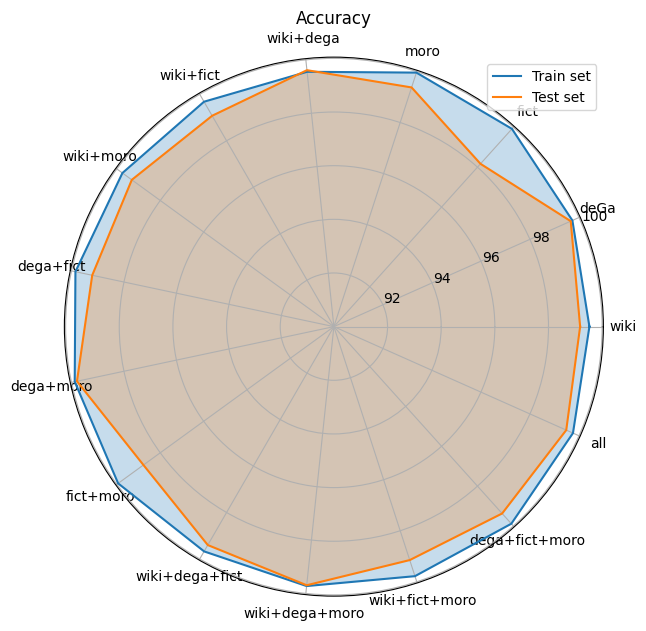

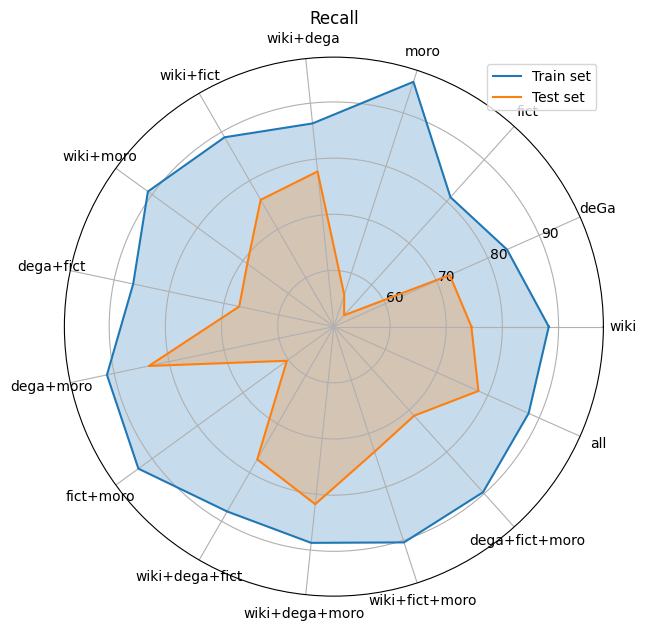

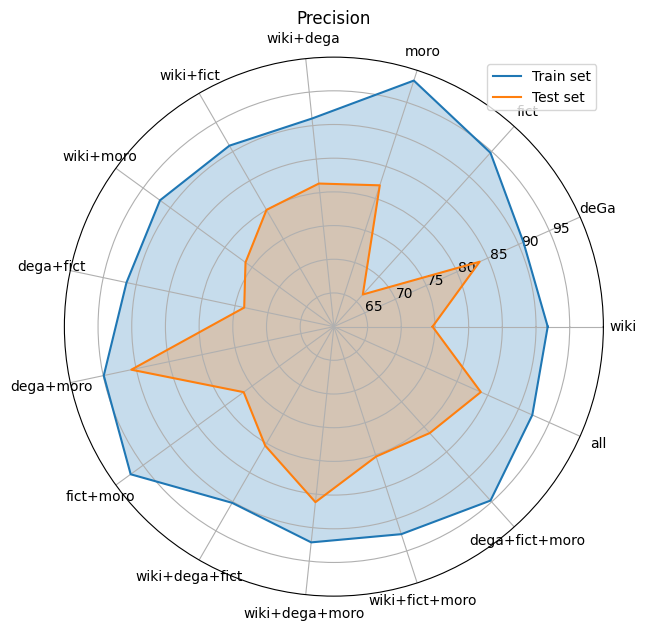

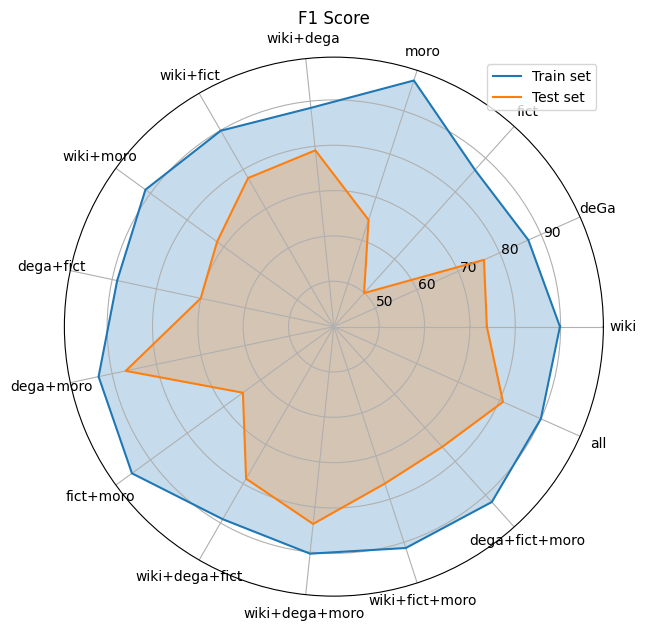

In [68]:
with open(f'{PATH_MODEL_EVAL}data.pkl', 'rb') as file:
    results = pickle.load(file)

datasets            = ['wiki', 'deGa', 'fict', 'moro', 'wiki+dega', 'wiki+fict', 'wiki+moro', 'dega+fict', 'dega+moro', 'fict+moro', 'wiki+dega+fict', 'wiki+dega+moro', 'wiki+fict+moro', 'dega+fict+moro', 'all']
train_accuracy      = []
test_accuracy       = []
train_recall        = []
test_recall         = []
train_precision     = []
test_precision      = []
train_f1_score      = []
test_f1_score       = []

for i in results:

    train_accuracy.append(np.mean(i['results_train']['accuracy']))
    train_recall.append(np.mean(i['results_train']['recall']))
    train_precision.append(np.mean(i['results_train']['precision']))
    train_f1_score.append(np.mean(i['results_train']['F1-score']))

    test_accuracy.append(np.mean(i['results_test']['accuracy']))
    test_recall.append(np.mean(i['results_test']['recall']))
    test_precision.append(np.mean(i['results_test']['precision']))
    test_f1_score.append(np.mean(i['results_test']['F1-score']))

datasets = np.array(datasets)
train_accuracy = np.array(train_accuracy)
test_accuracy = np.array(test_accuracy)
train_recall = np.array(train_recall)
test_recall = np.array(test_recall)
train_precision = np.array(train_precision)
test_precision = np.array(test_precision)
train_f1_score = np.array(train_f1_score)
test_f1_score = np.array(test_f1_score)
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

# Create spider plots

for metric in metrics:
    # Prepare train and test data
    if metric == 'Accuracy':
        train_data = train_accuracy
        test_data = test_accuracy
    elif metric == 'Recall':
        train_data = train_recall
        test_data = test_recall
    elif metric == 'Precision':
        train_data = train_precision
        test_data = test_precision
    elif metric == 'F1 Score':
        train_data = train_f1_score
        test_data = test_f1_score


    # Plot spider plot
    angles = np.linspace(0, 2 * np.pi, len(datasets), endpoint=False)
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles.tolist() + angles[:1].tolist(), train_data.tolist() + train_data[:1].tolist(), label='Train set')
    ax.plot(angles.tolist() + angles[:1].tolist(), test_data.tolist() + test_data[:1].tolist(), label='Test set')
    ax.fill(angles.tolist() + angles[:1].tolist(), train_data.tolist() + train_data[:1].tolist(), alpha=0.25)
    ax.fill(angles.tolist() + angles[:1].tolist(), test_data.tolist() + test_data[:1].tolist(), alpha=0.25)
    ax.set_xticks(angles)
    ax.set_xticklabels(datasets)
    bt = min(train_data.tolist() + test_data.tolist())//10 * 10
    ax.set_ylim(bottom = bt)
    plt.title(metric)
    plt.legend(loc='upper right')

# Show all the plots
plt.show()

As mentioned earlier, the datasets are heavily unbalanced, especially towards the "not an entity" (outside) class. 
Therefore, calculating the overall metrics of the model in the standard way is not meaningful. For this reason, the metrics are calculated in a balanced manner. For example, the balanced accuracy is obtained by averaging the accuracies of all classes. 
   
Firstly, it is possible to observe that there is no overfitting of the model on the dataset in any case, although some models did not generalize well 
It can be noticed that all the models trained on a dataset containing the "fiction" dataset experienced a significant decrease in all metrics. 

The model trained on all datasets except "fiction" achieved the best performance.


## NER Transformers

A transformer is a deep learning model that is different from the classical models since it adopts **self-attention.** It is used primarly in the fields of NLP and computer vision.
In general there are two big families of transformers:
- Transformer encoder layers, like BERT.
- Transformer decoder layers, like GPT.

Bert was pre-trained for two tasks:
- Language modeling;
- Next sentence prediction

As a result of this training process, BERT learnt latent representations of words and sentences in context. BERT can be **fine-tuned** with fewer resources on smaller datasets to optimize its performance on specific tasks such as NLP tasks (language inference, text classification) and sequence-to-sequence based language generation tasks (question-answering, conversational response generation).

In the case of Named Entity Recognition tasl, BERT is fine-tuned for Token Classification, that takes as input a sequence of tokens and the respective entity tag.

Since the dataset is already tokenized and cleaned by the authors, it is not applied any type of pre-processing.

Two different pre-trained italian models are used:
- bert italian xxl cased
- bert base multilingual.

For both of them was performed cross-validation to choose the most important hyperparameters.



In [14]:
def createDataset(train, test):

  '''
  Takes two dataframes and it creates an Hugging Face Dictionary of Datasets

  Parameters
  ----------
  train: DataFrame
    Train DataFrame
  test: DataFrame
    Test DataFrame

  Returns
  -------
  dataset_hf: DatasetDict
    Dictionary of Hugging Face Datasets
  '''
  
  train_dataset = Dataset.from_pandas(train)
  test_dataset = Dataset.from_pandas(test)
  dataset_hf = DatasetDict()
  
  dataset_hf['train'] = train_dataset
  dataset_hf['test'] = test_dataset

  return dataset_hf

The following code creates all the data structures that are needed to 
fine-tune the model.
The dataset used for the training phase comes form the merge of all the train datasets. Then, the model predicts and evaluates the performances over all the test sets.

In [15]:
# Create a dataset composed of all the train datasets
datasets_merged = pd.concat(datasets_train_dict_BIO.values(), ignore_index=True)

# Create of a dictionary that maps all the entity inside the dataset with an incremental id
entity_names = pd.unique(datasets_merged['Entity'])
entity_names_dict = {}
for i, label in enumerate(entity_names):
  entity_names_dict[label] = i

id2label = {}
for i, label in enumerate(entity_names):
  id2label[i] = label

# Creation of all the sentence and the respected labels for the entire dataset
sentences, labels, keys = get_sentences_list_from_df(datasets_merged)
train_dataset = pd.DataFrame(columns=['Tokens', 'Labels'])

# Creation of a DataFrame with all the sentences
for i in range(len(sentences)):
  train_dataset.at[i, 'Tokens'] = sentences[i]
  train_dataset.at[i, 'Labels'] = labels[i]

into a list of strings


853321it [00:39, 21440.54it/s]


In [16]:
# Controll of the possibility to use cuda
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Download bert models from hugging face
model_name_xxl = 'dbmdz/bert-base-italian-xxl-cased'
model_name_multi = 'bert-base-multilingual-cased'

model_xxl = AutoModelForTokenClassification.from_pretrained(model_name_xxl, num_labels=len(entity_names), label2id=entity_names_dict, id2label=id2label).to(device)
model_multi = AutoModelForTokenClassification.from_pretrained(model_name_multi, num_labels=len(entity_names), label2id=entity_names_dict, id2label=id2label).to(device)

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not init

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

In [17]:
def tokenize_and_align_labels(examples):

    '''
    Takes a batch of examples. Tokenize the examples and since the bert is performing a sub-tokenization we have to allign the original labels to the actual sub-tokens.

    Parameters
    ----------
    examples: dict
      Dictionary having as values for the key Tokens a list of list of tokenized senteces.

    Returns
    -------
    tokenized_inputs: dict
      dictionary that containt the input_ids created by the bert tokenizer and the respected labels for each token alligned as the initial ones.
  
    '''
    # Tokenization of the sentences
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["Tokens"]), truncation=True, is_split_into_words=True)

    # Alignment of the labels with the original tokens
    labels = []
    for i, label in enumerate(examples['Labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif label[word_idx] == '0':
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(entity_names_dict[label[word_idx]])
            else:
                label_ids.append(entity_names_dict[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [18]:
metric = evaluate.load("seqeval")

def compute_metrics(p):

    '''
    It calculates the metrics of a batch of predictions.

    Parameters
    ----------
    p: tuple
      Tuple composed of the predictions by the transformer and the respected original labels.

    Returns
    -------
    entity_metrics: dict
      dictionary of dictionaries that contains for each entity the respected computed metrics

    '''
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    entity_metrics = {}
    for entity_name in entity_names:

        # Take the predictions and the labels of the specific entity (when the original one was that entity)
        true_predictions = [[entity_names[p] for (p, l) in zip(prediction, label) if l != -100 and entity_names[l] == entity_name] for prediction, label in zip(predictions, labels)]
        true_labels = [[entity_names[l] for (p, l) in zip(prediction, label) if l != -100 and entity_names[l] == entity_name] for prediction, label in zip(predictions, labels)]

        # Compute the metrics for that specific entity
        results = metric.compute(predictions=true_predictions, references=true_labels)
        entity_metrics[entity_name] = {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

    return entity_metrics

In [19]:
def compute_mean_metrics_cv(results):

  '''
  It calculates the metrics of a cross-validation.

  Parameters
  ----------
  results: list
    list that contains all the metrics calculated for each entity every round of the cross-validation.

  Returns
  -------
  metrics: dict
    dictionary of dictionaries that contains for each entity the mean of the metrics.

  '''

  metrics = {}
  for entity_name in entity_names:
    metrics[entity_name] = {
            "precision": sum([scores[f'eval_{entity_name}']['precision'] for scores in results]) / len(results),
            "recall":  sum([scores[f'eval_{entity_name}']['recall'] for scores in results]) / len(results),
            "f1":  sum([scores[f'eval_{entity_name}']['f1'] for scores in results]) / len(results),
            "accuracy":  sum([scores[f'eval_{entity_name}']['accuracy'] for scores in results]) / len(results)
        }
  return metrics

### Cross-Validation
In the following part cross-validation is perfomed to find the best hyperparameters for the model.

This part is not needed to run since it requires a lot of time and all the next parts already take into account the results of the cross-validation step.

In [ ]:
# Definition of hyperparameters ranges.
learning_rates = [2e-5, 3e-5]
epochs = [2,3,4]

tokenizer = AutoTokenizer.from_pretrained(model_name_xxl)
data_collator = DataCollatorForTokenClassification(tokenizer)

results = []
# Perform of cross-validation
for lr in learning_rates:
  for epoch in epochs:
    results_cv = []
    for i in range(3):    # Cross-validation made of three rounds
      train, val = train_test_split(train_dataset, test_size=0.2, shuffle=True)
      dataset_hf = createDataset(train, val)
      tokenized_datasets = dataset_hf.map(tokenize_and_align_labels, batched=True)

      # Definition of the Transformer's arguments
      args = TrainingArguments(output_dir='ner',
                               evaluation_strategy = "no",
                               learning_rate=lr,
                               per_device_train_batch_size=32,
                               per_device_eval_batch_size=32,
                               num_train_epochs=epoch,
                               weight_decay=0.01,
                               push_to_hub=False,
                               disable_tqdm=False
                              )

      # Creation of the trainer
      trainer = Trainer(
          model_xxl,
          args,
          train_dataset=tokenized_datasets['train'],
          eval_dataset = tokenized_datasets['test'],
          data_collator=data_collator,
          compute_metrics=compute_metrics,
          tokenizer=tokenizer,
      )
      trainer.train()
      results_cv.append(trainer.evaluate())             # Add the matrics for that round to the results of the actual cross-validation
    results.append(compute_mean_metrics_cv(results_cv)) # Calculate the metrics' mean of the cross-validation

### Build the final model
In this snippets, the final model over the entire training set is built considering the hyperparameters obtained from the cross-validation phase.
The italian model is the first one to be trained.

In [20]:
# Creation of the train dataset
dataset_hf = Dataset.from_pandas(train_dataset)
# Download of the tokenizer and tokenization of the entire dataset.
tokenizer = AutoTokenizer.from_pretrained(model_name_xxl)
tokenized_dataset = dataset_hf.map(tokenize_and_align_labels, batched=True)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Definition of the training arguments
args = TrainingArguments(output_dir='ner',
                          evaluation_strategy = "no",
                          learning_rate=2e-5,
                          per_device_train_batch_size=32,
                          per_device_eval_batch_size=32,
                          num_train_epochs=4,
                          weight_decay=0.01,
                          push_to_hub=False,
                          disable_tqdm=False
                        )

# Creation of the trainer
trainer = Trainer(
    model_xxl,
    args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Training of the model
trainer.train()

Map:   0%|          | 0/27538 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=3444, training_loss=0.026757091664547983, metrics={'train_runtime': 520.2601, 'train_samples_per_second': 211.725, 'train_steps_per_second': 6.62, 'total_flos': 5794990109216748.0, 'train_loss': 0.026757091664547983, 'epoch': 4.0})

Then, the model is evaluated over all the test sets.

In [21]:
results_test = []

# The model is evaluated over all the possible test sets
for test in datasets_test_dict_BIO.values():

  # Creation of the test set
  sentences, labels, keys = get_sentences_list_from_df(test)
  test_dataset = pd.DataFrame(columns=['Tokens', 'Labels'])
  for i in range(len(sentences)):
    test_dataset.at[i, 'Tokens'] = sentences[i]
    test_dataset.at[i, 'Labels'] = labels[i]
  
  # Tokenization and alligment of the test set
  test_dataset = Dataset.from_pandas(test_dataset)
  test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)
  
  # Evaluation of the test set
  results_test.append(trainer.evaluate(test_dataset))

into a list of strings


27128it [00:01, 20082.37it/s]


Map:   0%|          | 0/837 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9956306223609326}" of type <class 'dict'> for key "eval/O" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9007832898172323, 'recall': 0.7549234135667396, 'f1': 0.8214285714285715, 'accuracy': 0.7549234135667396}

into a list of strings


21506it [00:01, 21467.10it/s]


Map:   0%|          | 0/807 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9947947071414672}" of type <class 'dict'> for key "eval/O" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8031914893617021, 'recall': 0.7259615384615384, 'f1': 0.7626262626262627, 'accuracy': 0.7115384615384616}

into a list of strings


82806it [00:03, 20926.19it/s]


Map:   0%|          | 0/2203 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9959855330043873}" of type <class 'dict'> for key "eval/O" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9874125874125874, 'recall': 0.9463806970509383, 'f1': 0.9664613278576317, 'accuracy': 0.9517426273458445}

into a list of strings


59220it [00:02, 21253.37it/s]


Map:   0%|          | 0/1804 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.993892853916343}" of type <class 'dict'> for key "eval/O" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9269938650306748, 'recall': 0.8560906515580736, 'f1': 0.8901325478645066, 'accuracy': 0.860056657223796}" 

In [22]:
# Creation of the merged test set concatenating all the test sets
datasets_test_merged = pd.concat(datasets_test_dict_BIO.values(), ignore_index=True)
sentences, labels, keys = get_sentences_list_from_df(datasets_test_merged)
test_dataset = pd.DataFrame(columns=['Tokens', 'Labels'])
for i in range(len(sentences)):
  test_dataset.at[i, 'Tokens'] = sentences[i]
  test_dataset.at[i, 'Labels'] = labels[i]

# Tokenization and allignment of the merged test set
test_dataset = Dataset.from_pandas(test_dataset)
test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

# Evaluation of the merged test set
trainer.evaluate(test_dataset)

into a list of strings


190660it [00:08, 21243.66it/s]


Map:   0%|          | 0/5648 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9951687137449277}" of type <class 'dict'> for key "eval/O" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9303840877914952, 'recall': 0.8542191435768262, 'f1': 0.8906762967826658, 'accuracy': 0.8567380352644837}

{'eval_loss': 0.04808639734983444,
 'eval_O': {'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'accuracy': 0.9951687137449277},
 'eval_B-ORG': {'precision': 0.9303840877914952,
  'recall': 0.8542191435768262,
  'f1': 0.8906762967826658,
  'accuracy': 0.8567380352644837},
 'eval_I-ORG': {'precision': 0.8538681948424068,
  'recall': 0.8441926345609065,
  'f1': 0.849002849002849,
  'accuracy': 0.8672566371681416},
 'eval_B-LOC': {'precision': 0.940410199556541,
  'recall': 0.9033546325878594,
  'f1': 0.9215100488864748,
  'accuracy': 0.9105431309904153},
 'eval_B-PER': {'precision': 0.9725776965265083,
  'recall': 0.9382716049382716,
  'f1': 0.955116696588869,
  'accuracy': 0.9432686654908877},
 'eval_I-LOC': {'precision': 0.8151898734177215,
  'recall': 0.8586666666666667,
  'f1': 0.8363636363636364,
  'accuracy': 0.8820564516129032},
 'eval_I-PER': {'precision': 0.9364820846905537,
  'recall': 0.9712837837837838,
  'f1': 0.9535655058043118,
  'accuracy': 0.9773857982813207},
 'eval_ru

We repeat the same for the multilingual model.

In [23]:
# Creation of the train dataset
dataset_hf = Dataset.from_pandas(train_dataset)

# Download of the tokenizer and tokenization of the entire dataset.
tokenizer = AutoTokenizer.from_pretrained(model_name_multi)
tokenized_dataset = dataset_hf.map(tokenize_and_align_labels, batched=True)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Definition of the training arguments
args = TrainingArguments(output_dir='ner',
                          evaluation_strategy = "no",
                          learning_rate=2e-5,
                          per_device_train_batch_size=16,
                          per_device_eval_batch_size=16,
                          num_train_epochs=4,
                          weight_decay=0.01,
                          push_to_hub=False,
                          disable_tqdm=False
                        )
# Creation of the trainer
trainer = Trainer(
    model_multi,
    args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Training of the model
trainer.train()

Map:   0%|          | 0/27538 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=6888, training_loss=0.02245235681949177, metrics={'train_runtime': 670.7267, 'train_samples_per_second': 164.228, 'train_steps_per_second': 10.269, 'total_flos': 5828259997826772.0, 'train_loss': 0.02245235681949177, 'epoch': 4.0})

In [24]:
results_test = []

# The model is evaluated over all the possible test sets
for test in datasets_test_dict_BIO.values():
  # Creation of the test set
  sentences, labels, keys = get_sentences_list_from_df(test)
  test_dataset = pd.DataFrame(columns=['Tokens', 'Labels'])
  for i in range(len(sentences)):
    test_dataset.at[i, 'Tokens'] = sentences[i]
    test_dataset.at[i, 'Labels'] = labels[i]
  
  # Tokenization and alligment of the test set
  test_dataset = Dataset.from_pandas(test_dataset)
  test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

  # Evaluation of the test set
  results_test.append(trainer.evaluate(test_dataset))

into a list of strings


27128it [00:01, 20384.70it/s]


Map:   0%|          | 0/837 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9958945677396323}" of type <class 'dict'> for key "eval/O" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9098591549295775, 'recall': 0.6578411405295316, 'f1': 0.7635933806146572, 'accuracy': 0.6619144602851323}

into a list of strings


21506it [00:01, 21094.84it/s]


Map:   0%|          | 0/807 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9938079208743714}" of type <class 'dict'> for key "eval/O" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8629441624365483, 'recall': 0.7870370370370371, 'f1': 0.8232445520581114, 'accuracy': 0.7777777777777778}

into a list of strings


82806it [00:04, 20455.15it/s]


Map:   0%|          | 0/2203 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9966028074160416}" of type <class 'dict'> for key "eval/O" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9907529722589168, 'recall': 0.9422110552763819, 'f1': 0.9658725048293626, 'accuracy': 0.9447236180904522}

into a list of strings


59220it [00:02, 21069.69it/s]


Map:   0%|          | 0/1804 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9940535334851797}" of type <class 'dict'> for key "eval/O" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.917684887459807, 'recall': 0.8201149425287356, 'f1': 0.8661608497723824, 'accuracy': 0.8241379310344827}"

In [25]:
# Creation of the merged test set concatenating all the test sets
datasets_test_merged = pd.concat(datasets_test_dict_BIO.values(), ignore_index=True)
sentences, labels, keys = get_sentences_list_from_df(datasets_test_merged)
test_dataset = pd.DataFrame(columns=['Tokens', 'Labels'])
for i in range(len(sentences)):
  test_dataset.at[i, 'Tokens'] = sentences[i]
  test_dataset.at[i, 'Labels'] = labels[i]

# Tokenization and allignment of the merged test set
test_dataset = Dataset.from_pandas(test_dataset)
test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

# Evaluation of the test set
trainer.evaluate(test_dataset)

into a list of strings


190660it [00:08, 21248.02it/s]


Map:   0%|          | 0/5648 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9954490739290557}" of type <class 'dict'> for key "eval/O" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9322625698324022, 'recall': 0.8233117483811286, 'f1': 0.8744064188635992, 'accuracy': 0.8260869565217391}

{'eval_loss': 0.0565798282623291,
 'eval_O': {'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'accuracy': 0.9954490739290557},
 'eval_B-ORG': {'precision': 0.9322625698324022,
  'recall': 0.8233117483811286,
  'f1': 0.8744064188635992,
  'accuracy': 0.8260869565217391},
 'eval_I-ORG': {'precision': 0.8354978354978355,
  'recall': 0.8201133144475921,
  'f1': 0.827734095782702,
  'accuracy': 0.840887174541948},
 'eval_B-LOC': {'precision': 0.9301060647266793,
  'recall': 0.8945854041328799,
  'f1': 0.912,
  'accuracy': 0.9011247711221554},
 'eval_B-PER': {'precision': 0.9679319371727748,
  'recall': 0.9121184088806661,
  'f1': 0.9391966978885538,
  'accuracy': 0.916127042861548},
 'eval_I-LOC': {'precision': 0.7675544794188862,
  'recall': 0.8453333333333334,
  'f1': 0.8045685279187818,
  'accuracy': 0.8618556701030928},
 'eval_I-PER': {'precision': 0.9252032520325203,
  'recall': 0.9611486486486487,
  'f1': 0.9428334714167357,
  'accuracy': 0.9737845567206864},
 'eval_runtime': 21.089

The results of the multilingual model are on average worse than the ones found with the Italian XXL model.
Thus, in the model evaluation they won't be taken into consideration.

In the above code there is not the code that trains the transformer on a single train set and evaluates the model on all the test sets. 
However, this was done and the results were saved into different files.
All these results,  will be plotted on the Model Evaluation part.

### Model evaluation


####"Merged" model evaluation

In these bar graphs, are plotted the results obtained by the transformer trained on all datasets together in a more detailed manner. Each graph represents a metric, each group of columns represents a test set, and each column represents a class. We can observe that the 'moro' test set is the easiest to classify, and the classes that are generally better classified across the various metrics are the entity types 'person,' while the most challenging to detect are the 'organization' types.


In [69]:
def transf_barplot(bars, group_names, column_names,  title):


    column_names = [i.replace('eval_', ' ') for i in column_names]
    # Set the positions and width of the bars
    bar_width = 0.1
    bar_positions = np.arange(len(group_names))
    # Plot the bars
    plt.figure()
    for i in range(len(bars)):
        plt.bar(bar_positions + (3-i)*bar_width, bars[i], width=bar_width, label=column_names[i])
    # Set the x-axis labels and title
    plt.xticks(bar_positions, group_names)
    plt.xlabel('Test Sets')
    plt.ylabel('Values (%)')
    plt.title(title)
    plt.ylim(50, 100)
    # Add a legend
    plt.legend()

In [70]:
PATH_MODEL_EVAL = '/content/KIND_project/model evaluation/'

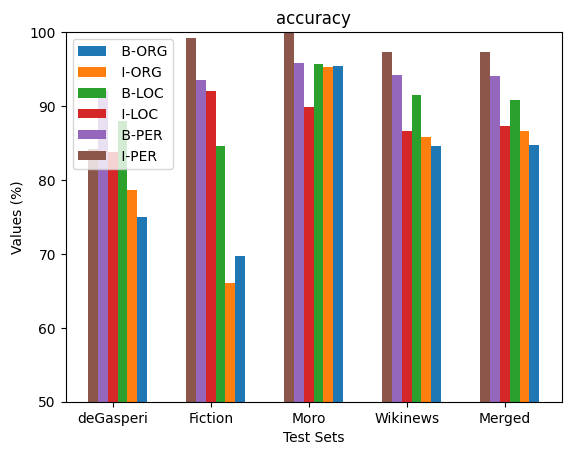

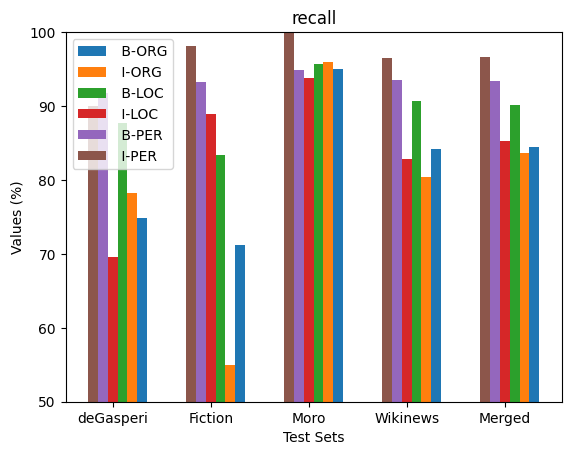

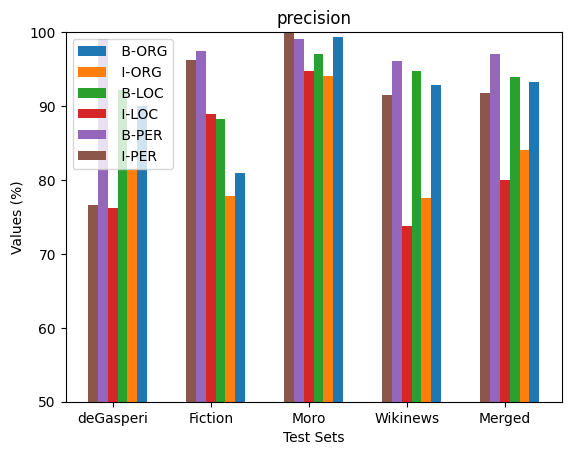

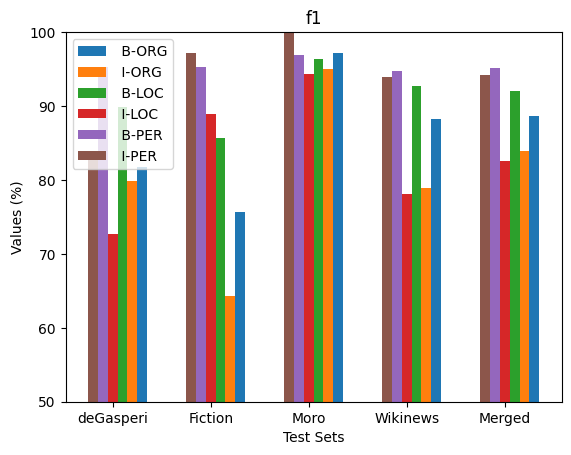

In [71]:
with open(f'{PATH_MODEL_EVAL}single.pkl', 'rb') as file:
    single = pickle.load(file)

with open(f'{PATH_MODEL_EVAL}all.pkl', 'rb') as file:
    all = pickle.load(file)

data_dicts = single + [all]
labels = ['eval_B-ORG', 'eval_I-ORG', 'eval_B-LOC', 'eval_I-LOC', 'eval_B-PER', 'eval_I-PER']
metrics = ['accuracy', 'recall', 'precision', 'f1']

graphs = []

for metric in metrics:
    bars = []
    for label in labels:
        values = []
        for res in data_dicts:
            values.append(res[label][metric]*100)
        bars.append(values)
    graphs.append(bars)



for i in range(len(graphs)):
    transf_barplot(graphs[i],['deGasperi', 'Fiction', 'Moro', 'Wikinews', 'Merged'], labels , metrics[i])

plt.show()

####"Single" vs "merged" models evaluation

In [74]:
def transformer_spiderplot(data, datasets):
    '''
    Generates spider plots for evaluation metrics based on the provided data and datasets.

    Parameters
    ----------
    data: list
        List of dictionaries containing evaluation metrics for each dataset.
    datasets: list
        List of dataset names corresponding to the evaluation metrics.

    Returns
    -------
    None
        Displays spider plots for each evaluation metric.
    '''

    accuracy = []
    recall = []
    precision = []
    f1_score = []

    labels = ['eval_B-LOC', 'eval_B-ORG', 'eval_B-PER', 'eval_I-LOC', 'eval_I-ORG', 'eval_I-PER']
    for i in data:
        acc = []
        rec = []
        pre = []
        f1 = []
        for j in labels:
            acc.append(i[j]['accuracy']*100)
            rec.append(i[j]['recall']*100)
            pre.append(i[j]['precision']*100)
            f1.append(i[j]['f1']*100)

        accuracy.append(np.mean(acc))
        recall.append(np.mean(rec))
        precision.append(np.mean(pre))
        f1_score.append(np.mean(f1))

    accuracy = np.array(accuracy)
    recall = np.array(recall)
    precision = np.array(precision)
    f1_score = np.array(f1_score)

    # Create spider plots
    metrics_name = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
    metrics = [accuracy, recall, precision, f1_score]


    for k in range(0, len(metrics)):
        i = metrics[k]
        j = metrics_name[k]
        # Plot spider plot
        angles = np.linspace(0, 2 * np.pi, len(datasets), endpoint=False)
        plt.figure(figsize = (7,7))
        ax = plt.subplot(111, polar=True)
        ax.plot(angles.tolist() + angles[:1].tolist(), i.tolist() + i[:1].tolist(), label='Train')
        ax.fill(angles.tolist() + angles[:1].tolist(), i.tolist() + i[:1].tolist(), alpha=0.25)
        ax.set_xticks(angles)
        ax.set_xticklabels(datasets)
        bt = min(i.tolist())//10 * 10
        ax.set_ylim(bottom = bt, top = 100)
        plt.title(j)
        plt.legend(loc='upper right')

    # Show all the plots
    plt.show()

In [75]:
def transformer_spiderplot_allmetrics(data, datasets, title):
    '''
    Generates spider plots for all evaluation metrics based on the provided data, datasets, and title.

    Parameters
    ----------
    data: list
        List of dictionaries containing evaluation metrics for each dataset.
    datasets: list
        List of dataset names corresponding to the evaluation metrics.
    title: str
        Title for the spider plot.

    Returns
    -------
    None
        Displays the spider plot for all evaluation metrics.
    '''
    accuracy = []
    recall = []
    precision = []
    f1_score = []

    labels = ['eval_B-LOC', 'eval_B-ORG', 'eval_B-PER', 'eval_I-LOC', 'eval_I-ORG', 'eval_I-PER']
    for i in data:
        acc = []
        rec = []
        pre = []
        f1 = []
        for j in labels:
            acc.append(i[j]['accuracy']*100)
            rec.append(i[j]['recall']*100)
            pre.append(i[j]['precision']*100)
            f1.append(i[j]['f1']*100)

        accuracy.append(np.mean(acc))
        recall.append(np.mean(rec))
        precision.append(np.mean(pre))
        f1_score.append(np.mean(f1))

    accuracy = np.array(accuracy)
    recall = np.array(recall)
    precision = np.array(precision)
    f1_score = np.array(f1_score)

    # Create spider plots
    metrics_name = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
    metrics = [accuracy, recall, precision, f1_score]

    # Plot spider plot
    angles = np.linspace(0, 2 * np.pi, len(datasets), endpoint=False)
    plt.figure(figsize = (7,7))
    ax = plt.subplot(111, polar=True)
    for k in range(0, len(metrics)):
        i = metrics[k]
        ax.plot(angles.tolist() + angles[:1].tolist(), i.tolist() + i[:1].tolist(), label=metrics_name[k])
        ax.fill(angles.tolist() + angles[:1].tolist(), i.tolist() + i[:1].tolist(), alpha=0.25)
    ax.set_xticks(angles)
    ax.set_xticklabels(datasets)
    bt = min(i.tolist())//10 * 10 - 5
    ax.set_ylim(bottom = bt, top = 100)
    plt.title(title)
    plt.legend(loc='upper right')

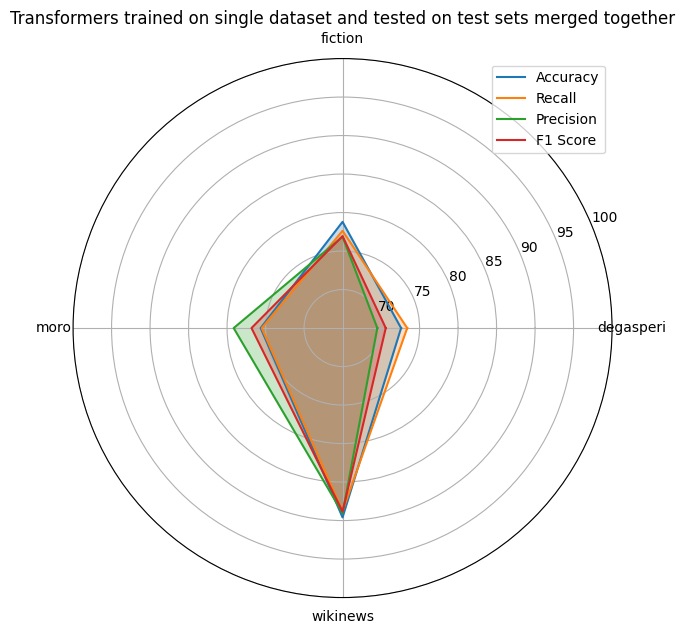

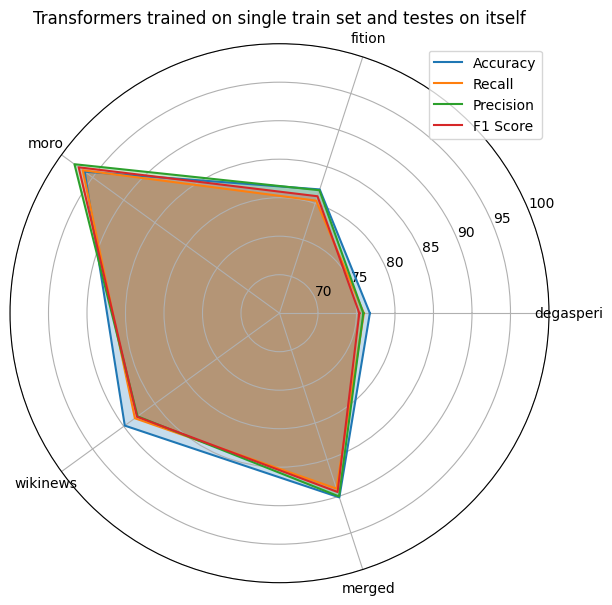

In [87]:
all_train_single_test = ['all_degasperi.pkl', 'all_fiction.pkl', 'all_moro.pkl', 'all_wikinews.pkl']
single_train_all_test = ['single_degasperi.pkl', 'single_fiction.pkl', 'single_moro.pkl', 'single_wikinews.pkl']

######################################################################################################################################################
# Transformers trained on single dataset and tested on test sets merged together
data1 = []
for i in all_train_single_test:
    with open(f'{PATH_MODEL_EVAL}{i}', 'rb') as file:
        single = pickle.load(file)
    data1.append(single)

transformer_spiderplot_allmetrics(data1, ['degasperi', 'fiction', 'moro', 'wikinews'], "Transformers trained on single dataset and tested on test sets merged together")
print()
######################################################################################################################################################
# Plots results of the transformers trained on the single datasets and tested on their relative test set
data2 = []
for i in range(len(single_train_all_test)):
    with open(f'{PATH_MODEL_EVAL}{single_train_all_test[i]}', 'rb') as file:
        single = pickle.load(file)
    data2.append(single[i])

with open(f'{PATH_MODEL_EVAL}all.pkl', 'rb') as file:
    all_on_all = pickle.load(file)
data2.append(all_on_all)

transformer_spiderplot_allmetrics(data2, ['degasperi', 'fition', 'moro', 'wikinews', 'merged'], "Transformers trained on single train set and testes on itself")

# Show all the plots
plt.show()

Five models were trained in total.
Four models are trained on each single dataset separately and tested on both all the different test sets and the merge of all the test sets.
It was also trained a transformer on a dataset composed of all the original datasets and it was used to classify all the test sets both separately and collectively.

The first plot shows the results of the transformers trained on each individual train set and tested over the merged test sets.
Furthermore, in the second plot is shown the result of all the transformers trained on a single dataset, with the name written on the plot, and test over the relative test set.
It is added also the transformer trained all over the merged train sets and test on the merged test sets.

The final consideration about the plots are:
- Moro is the one that performs better in the case of a transformer both trained and tested on that dataset;
- Comparing the result of the first plot with the results of the model trained over the merged train sets and tested over the merged test sets, it is possible to state that its performances are much better. This is what it is expected since the amout of data used is higher.

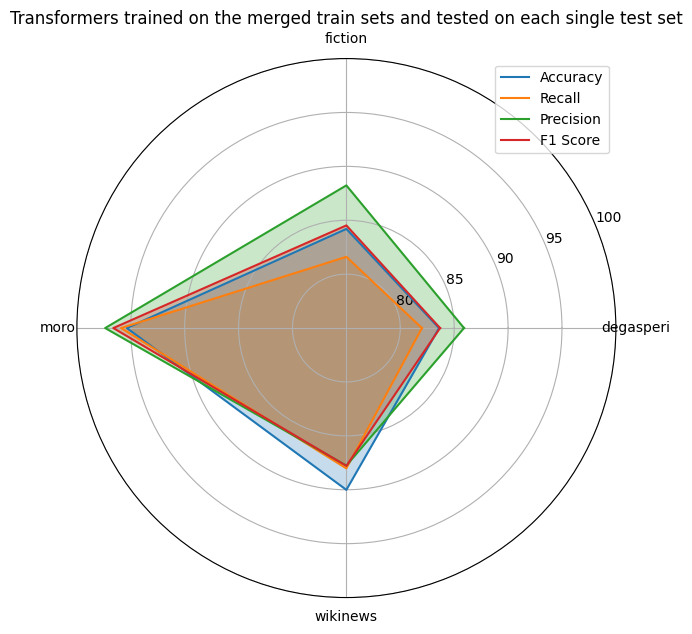

In [79]:
# Transformers trained on the merged train sets and tested on each single test set
data4 = []
with open(f'{PATH_MODEL_EVAL}single.pkl', 'rb') as file:
  single = pickle.load(file)

for result in single:
  data4.append(result)

transformer_spiderplot_allmetrics(data4, ['degasperi', 'fiction', 'moro', 'wikinews'], "Transformers trained on the merged train sets and tested on each single test set")
print()

This plot shows the performance of the transformer trained over the merged train sets and tested on each single test (the ones written on the circle plot).

As expected, the performances are at least, or better, the ones of the  model trained and tested on a single dataset.

For instance, Moro has much higher performances.

#### Comparison between CRF and Transformer

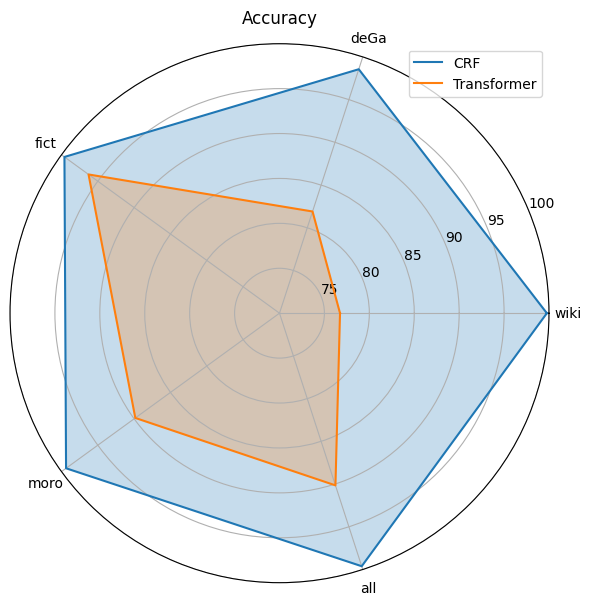

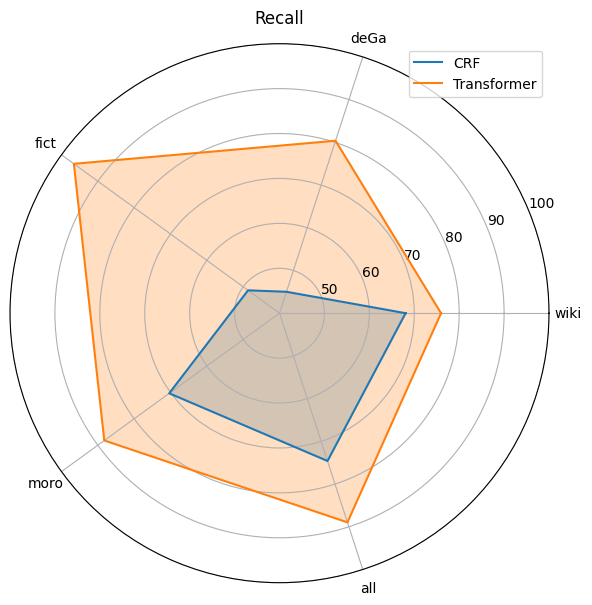

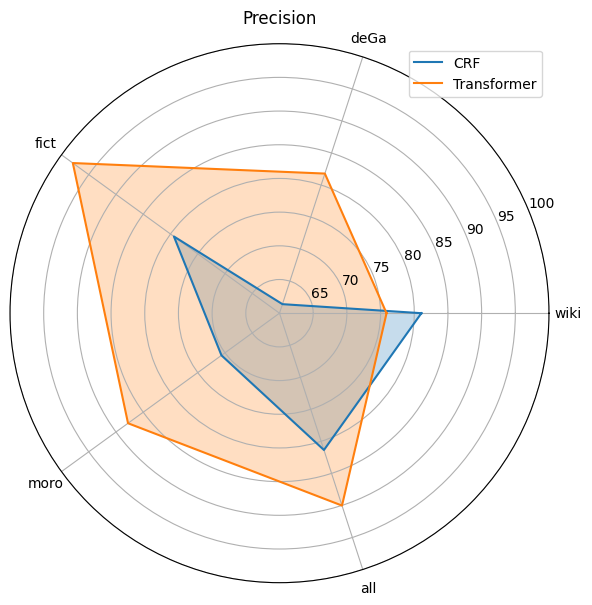

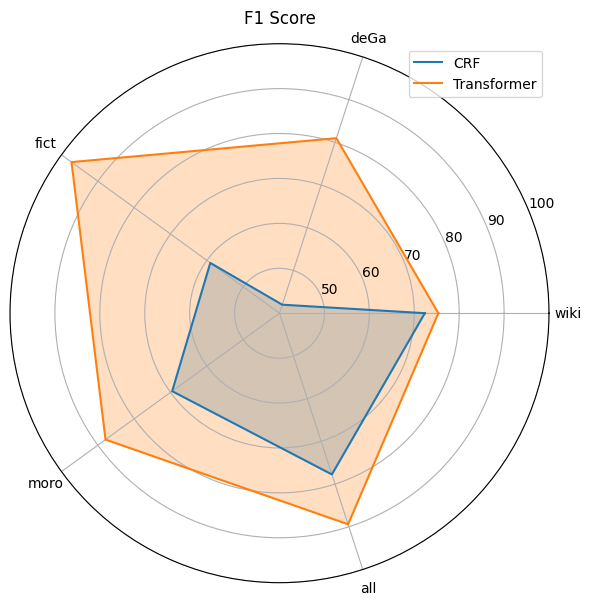

In [88]:
######################################################################################################################################################
# Plot the results of the CRF and the transformer, trained on the single datasets and merged  dataset, tested on the respective test sets
df_data = []
with open(f'{PATH_MODEL_EVAL}data.pkl', 'rb') as file:
    crf_data = pickle.load(file)

allowed = ['degasperi+', 'fiction+', 'moro+', 'wikinews+', 'wikinews+ degasperi+ fiction+ moro']
for i in range(len(allowed)):
    for j in crf_data:
        if j['dataset_name'] == allowed[i]:
            df_data.append(j['results_test'])

labels = ['eval_B-LOC', 'eval_B-ORG', 'eval_B-PER', 'eval_I-LOC', 'eval_I-ORG', 'eval_I-PER']
columns = ['set_of_feature', 'accuracy', 'recall', 'precision', 'F1-score']

data3 = []
for dict in data2:
    metrics_df = None
    for inner_dict in labels:
        AC = dict[inner_dict]['accuracy']
        RC = dict[inner_dict]['recall']
        PR = dict[inner_dict]['precision'] 
        F1 = dict[inner_dict]['f1']
        if metrics_df is None:
          metrics_df = pd.DataFrame([[inner_dict, AC, RC, PR, F1]], columns=columns)
        else:
          metrics_df = pd.concat([metrics_df,pd.DataFrame([[inner_dict, AC, RC, PR, F1]], columns=columns)])
    data3.append(metrics_df)


with open(f'{PATH_MODEL_EVAL}data.pkl', 'rb') as file:
    results = pickle.load(file)

datasets            = ['deGa', 'fict', 'moro', 'wiki' 'all']
CRF_accuracy      = []
transf_accuracy       = []
CRF_recall        = []
transf_recall         = []
CRF_precision     = []
transf_precision      = []
CRF_f1_score      = []
transf_f1_score       = []

for i in df_data:
    i.reset_index(drop=True, inplace=True)
    i.drop(i.index[2], inplace=True)
    CRF_accuracy.append(np.mean(i['accuracy']))
    CRF_recall.append(np.mean(i['recall']))
    CRF_precision.append(np.mean(i['precision']))
    CRF_f1_score.append(np.mean(i['F1-score']))

for i in data3:
    transf_accuracy.append(np.mean(i['accuracy'])*100)
    transf_recall.append(np.mean(i['recall'])*100)
    transf_precision.append(np.mean(i['precision'])*100)
    transf_f1_score.append(np.mean(i['F1-score'])*100)


datasets = np.array(datasets)
CRF_accuracy = np.array(CRF_accuracy)
transf_accuracy = np.array(transf_accuracy)
CRF_recall = np.array(CRF_recall)
transf_recall = np.array(transf_recall)
CRF_precision = np.array(CRF_precision)
transf_precision = np.array(transf_precision)
CRF_f1_score = np.array(CRF_f1_score)
transf_f1_score = np.array(transf_f1_score)
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

# Create spider plots

for metric in metrics:
    # Prepare train and test data
    if metric == 'Accuracy':
        CRF_data = CRF_accuracy
        transformer_data = transf_accuracy
    elif metric == 'Recall':
        CRF_data = CRF_recall
        transformer_data = transf_recall
    elif metric == 'Precision':
        CRF_data = CRF_precision
        transformer_data = transf_precision
    elif metric == 'F1 Score':
        CRF_data = CRF_f1_score
        transformer_data = transf_f1_score

    # Plot spider plot
    angles = np.linspace(0, 2 * np.pi, len(datasets), endpoint=False)
    plt.figure(figsize = (7,7))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles.tolist() + angles[:1].tolist(), CRF_data.tolist() + CRF_data[:1].tolist(), label='CRF')
    ax.plot(angles.tolist() + angles[:1].tolist(), transformer_data.tolist() + transformer_data[:1].tolist(), label='Transformer')
    ax.fill(angles.tolist() + angles[:1].tolist(), CRF_data.tolist() + CRF_data[:1].tolist(), alpha=0.25)
    ax.fill(angles.tolist() + angles[:1].tolist(), transformer_data.tolist() + transformer_data[:1].tolist(), alpha=0.25)
    ax.set_xticks(angles)
    ax.set_xticklabels(datasets)
    bt = min(CRF_data.tolist() + transformer_data.tolist())//10 * 10
    ax.set_ylim(bottom = bt, top=100)
    plt.title(metric)
    plt.legend(loc='upper right')

# Show all the plots
plt.show()

In these plots, it is possible to observe a comparison of the results between CFR and transformer models. In this case, each axis represents a dataset on which the model was trained and tested. 

As expected transformers generally outperform the CRFs in terms of precision, recall, and F1 score. Indeed it is a deep learning model and the state-of-art for what reguard any NLP task.

The CRFs achieve significantly better results in terms of accuracy.

Based on the meanings of these metrics, we can reasonably conclude that the CRF model might have better overall classification performance in terms of correctly classifying instances, but the transformer model is more effective in capturing positive instances (higher recall) and avoiding false positives (higher precision), leading to a better balance between the two (higher F1 score).